In [8]:
import jax
jax.config.update("jax_default_device",jax.devices()[1])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
#import keql_tools
#reload(keql_tools)
#from keql_tools import *
from Kernels import *
from EquationModel import *
from jax.scipy.linalg import solve
from EquationModel import *
from GP_sampler import *
from plotting import *
from evaluation_metrics import *

import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize

from LM_Solve import adaptive_refine_solution

## Utils

In [9]:
## Utils
# Build interior and boundary grids
def build_xy_grid(x_range,y_range,num_grid_x,num_grid_y):
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    full_y_grid = jnp.linspace(y_range[0],y_range[1],num_grid_y)

    x_interior = full_x_grid[1:-1]
    y_interior = full_y_grid[1:-1]
    
    x_boundary = full_x_grid[jnp.array([0,-1])]
    y_boundary = full_y_grid[jnp.array([0,-1])]

    #Get interior points
    x,y = jnp.meshgrid(x_interior,y_interior)
    xy_interior = jnp.vstack([x.flatten(),y.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    x,y = jnp.meshgrid(x_interior,y_boundary)
    xy_boundary_1 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_interior)
    xy_boundary_2 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_boundary)
    xy_boundary_3 = jnp.vstack([x.flatten(),y.flatten()]).T

    xy_boundary = jnp.vstack([xy_boundary_1,xy_boundary_2,xy_boundary_3])
    return xy_interior,xy_boundary

In [10]:
def get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, vmapped_rhs, seed):
    """
        Gets samples(functions) of GP. 

        Args:
            num_obs (list): List of integers of number of observed points per function.
            xy_int (jnp.array): Interior domain to get the sample.
            xy_bdy (jnp.array): Boundary domain.
            vmapped_u_true_functions (list): List of vmapped u true functions.
            vmapped_u_true_functions (list): List of vmapped f true functions.
            seed (int): Integer to fix the simulation.

        Returns:
            list: List of lists xy_obs, u_obs, f_obs.   
    """

    if len(num_obs) != len(vmapped_u_true_functions):
        raise Exception("len of list of provided observed points not same as len of list of provided functions.")
    
    num_f = len(vmapped_rhs)
    key = jax.random.PRNGKey(seed)
    seed = jax.random.randint(key=key, shape=(num_f,), minval=1, maxval=40)
    xy_obs, u_obs, f_obs =  [], [], []
    for i, num_ob in enumerate(num_obs):
        np.random.seed(seed[i])
        xy_sample_indsi = np.random.choice(list(np.arange(len(xy_int))),num_ob,replace = False)
        xy_obsi = jnp.vstack([xy_bdy,xy_int[xy_sample_indsi]])
        xy_obs.append(xy_obsi)
        u_obs.append(vmapped_u_true_functions[i](xy_obsi))
        f_obs.append(vmapped_rhs[i](xy_obsi))
    return xy_obs, u_obs, f_obs

In [11]:
# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

In [12]:
def run_exp(m, obs_pts,run):
    # Define grid to get samples from GP
    x_grid=jnp.linspace(0,1,25)
    y_grid=jnp.linspace(0,1,25)
    X,Y=jnp.meshgrid(x_grid,y_grid)
    pairs = jnp.vstack([X.ravel(), Y.ravel()]).T

    # Sample m training functions from a GP
    kernel_GP = get_gaussianRBF(0.5)
    u_true_functions = tuple(GP_sampler(num_samples = m,
                                            X = pairs, 
                                            kernel = kernel_GP,
                                            reg = 1e-12,
                                            seed = run
                                        )  
                                        )

    # Permeability field A
    def A(xy):
        x = xy[0]
        y = xy[1]
        return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

    # Compute f = Pu for any u
    def get_rhs_darcy(u):
        def Agradu(xy):
            return A(xy)*jax.grad(u)(xy)
        def Pu(xy):
            return jnp.trace(jax.jacfwd(Agradu)(xy))
        return Pu

    # Lists of m true u's and f's
    vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
    rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed

    # Define the num of ghost points for each u
    num_grid_points = 8
    # Ghost grid - Same per function
    xy_int,xy_bdy = build_xy_grid([0,1],[0,1],num_grid_points,num_grid_points)
    xy_all = jnp.vstack([xy_bdy,xy_int])

    # Number of observed points per u
    num_obs = [obs_pts]*m

    xy_obs, u_obs, f_obs = get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, rhs_functions, seed=2024)

    # Build interpolants for u's
    k_u = get_gaussianRBF(0.5)
    u_models = tuple([InducedRKHS(
        xy_all,
        feature_operators,
        k_u
        ) for i in range(m)])
    
    # Get necessary tuples
    observation_points = tuple(xy_obs)
    observation_values = tuple(u_obs)
    collocation_points = (xy_int,)*m

    rhs_values = tuple(rhs_func(xy_int) for rhs_func in rhs_functions)

    all_u_params_init = tuple([model.get_fitted_params(obs_loc,obs_val) for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

    grid_features_u_init = jnp.vstack([(model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
                len(xy_int),
                len(feature_operators),
                order = 'F'
            ) for model,model_params in zip(u_models,all_u_params_init) ])


    k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init,c=1)
    k_P_x_part = get_gaussianRBF(0.4)
    def k_P(x,y):
        return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

    class P_model():

        kernel_function = jit(
            get_kernel_block_ops(k_P,[eval_k],[eval_k])
        )

        num_params = len(grid_features_u_init)

        @jit
        def predict(input_data,params):
            K = P_model.kernel_function(input_data,input_data)
            return K@params
        
        def get_P_eval(input_data,params):
            def predict(prediction_points):
                K = P_model.kernel_function(prediction_points,input_data)
                return K@params
            return predict
        
    collocation_points = tuple([xy_int]*m)
    
    EqnModel  = OperatorPDEModel(
        P_model,
        u_models,
        observation_points,
        observation_values,
        collocation_points,
        feature_operators,
        rhs_values,
        datafit_weight = 5.,
    )

    params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(xy_int))])

    params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
        params_init.copy(),
        EqnModel,
        beta = 1e-8,
        max_iter = 501,
        init_alpha=3,
        line_search_increase_ratio=2.
    )

    p_adjusted,refinement_losses,reg_sequence = adaptive_refine_solution(params,EqnModel,1e-1,500)

    u_sols = EqnModel.get_u_params(p_adjusted)
    P_sol = EqnModel.get_P_params(p_adjusted)

    # Testing grid
    num_fine_grid = 50
    x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

    # Estimated P from 1.5 step method
    model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)    
    S_train = model_grid_features_all
    P_func = P_model.get_P_eval(S_train,P_sol)

    # Estimated P from 2 step method
    init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
    S_train_2 = init_P_features 
    K = P_model.kernel_function(S_train_2,S_train_2)
    P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.stacked_collocation_rhs)
    P_func2 = P_model.get_P_eval(S_train_2,P_params_naive)

    # P[\phi(w)](fine_grid)
    def evaluate_hatP(P_func, w, fine_grid, feature_operators):

        # Build S_test
        w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine_int) for operator in feature_operators]).T
        model_fine_features = jnp.hstack([fine_grid, w_features])
        S_test = model_fine_features


        #P_preds_model_features = P_model.kernel_function(S_test,S_train)@P_sol 
        P_preds = P_func(S_test)
        return P_preds
    
    # In sample errors

    # Get list of approximated functions ^U = [^u_1, ^u_2, ^u_3]
    true = [f(xy_fine_int) for f in rhs_functions]

    u_approx_funcs = [u_models[ind].get_eval_function(u_sols[ind]) 
                    for ind in range(m)]
    pred1_5 = [
        evaluate_hatP(
        P_func,
        u, xy_fine_int,feature_operators) for u in u_approx_funcs
    ]

    twostep_u_approx_funcs = [u_models[ind].get_eval_function(all_u_params_init[ind]) 
                    for ind in range(m)]
    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in twostep_u_approx_funcs
    ]
    in_sample_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)])) # RMSE
    in_sample_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))
    

    # Out of sample
    M = 50
    kernel_GP = get_gaussianRBF(0.2)
    # Sample M test functions from GP(0,K)
    w_test_functions = GP_sampler(num_samples = M,
                    X = pairs, 
                    kernel = kernel_GP,
                    reg = 1e-12,
                    seed = run
                    )
    vmapped_w_test_functions = tuple([jax.vmap(w) for w in w_test_functions]) # vmap'ed
    w_rhs_functions = tuple([jax.vmap(get_rhs_darcy(w)) for w in w_test_functions]) #vmap'ed

    # mean 
    true = [f_w(xy_fine_int) for f_w in w_rhs_functions]
    #pred = [evaluate_hatP(w, xy_fine_int, u_sols, P_sol,feature_operators) for w in w_test_functions]
    pred1_5 = [
        evaluate_hatP(
        lambda x:P_model.kernel_function(x,S_train)@P_sol,
        w, xy_fine_int,feature_operators) for w in w_test_functions
    ]

    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in w_test_functions
    ]

    out_sample_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
    out_sample_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))

    return in_sample_1_5, in_sample_2, out_sample_1_5, out_sample_2

## Structure to store the errors

We create a dictionary called `err` to store errors (nrmse) where we denote the keys as follows:

>  `1_5_mthd`: This is the main algorithm.

>  `2_obs`: This means that its parent method was trained using the observed functions at 2 points.

>  `i_dis`: List of list which contains the errors for P at the training functions.

>  `o_dis`: List of list which contains the errors for P at the testing functions.

In [13]:
err = {
    '1_5_mthd': {
        '2_obs': {'i_dis': [],'o_dis': []},
        '4_obs': {'i_dis': [],'o_dis': []},
        '8_obs': {'i_dis': [],'o_dis': []},
        '16_obs': {'i_dis': [],'o_dis': []}
                  },
    '2_mthd':   {
        '2_obs': {'i_dis': [],'o_dis': []},
        '4_obs': {'i_dis': [],'o_dis': []},
        '8_obs': {'i_dis': [],'o_dis': []},
        '16_obs': {'i_dis': [],'o_dis': []}
                }
}

In [14]:
# NUM_FUN_LIST = [2,4,8,16]
NUM_FUN_LIST = [16]
NUM_RUNS = 10
OBS_PTS_LIST = [2,4,8,16]

for obs_pt in OBS_PTS_LIST:
    for m in NUM_FUN_LIST:
        i_dis_1_5 = []
        i_dis_2 = []
        o_dis_1_5 = []
        o_dis_2 = []
        for run in range(NUM_RUNS):
            # Run
            res = run_exp(m, obs_pt, run)
            # Append
            i_dis_1_5.append(res[0])
            i_dis_2.append(res[1])
            o_dis_1_5.append(res[2])
            o_dis_2.append(res[3])
        # Append each list    
        err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'].append(i_dis_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['i_dis'].append(i_dis_2)
        err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'].append(o_dis_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['o_dis'].append(o_dis_2)    
    # Save after 
    jnp.save('err',err)

  3%|▎         | 17/501 [00:00<00:09, 51.40it/s]

Iteration 0, loss = 480.3, Jres = 495.3, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 244.3, Jres = 6.282e+03, alpha = 2.5, improvement_ratio = 0.528
Iteration 2, loss = 10.15, Jres = 1.241e+04, alpha = 2.083, improvement_ratio = 0.9864
Iteration 3, loss = 4.886, Jres = 1.113e+03, alpha = 1.736, improvement_ratio = 0.9965
Iteration 4, loss = 3.672, Jres = 53.13, alpha = 1.447, improvement_ratio = 0.9999
Iteration 5, loss = 2.822, Jres = 18.1, alpha = 1.206, improvement_ratio = 1.0


 16%|█▌        | 81/501 [00:00<00:02, 157.71it/s]

Iteration 50, loss = 0.002939, Jres = 6.483, alpha = 0.0004747, improvement_ratio = 0.7768


 25%|██▌       | 126/501 [00:00<00:01, 189.85it/s]

Iteration 100, loss = 2.058e-05, Jres = 0.2215, alpha = 1.486e-05, improvement_ratio = 0.7885


 39%|███▊      | 194/501 [00:01<00:01, 210.56it/s]

Iteration 150, loss = 1.294e-05, Jres = 0.07751, alpha = 4.147e-06, improvement_ratio = 0.7566


 48%|████▊     | 240/501 [00:01<00:01, 215.87it/s]

Iteration 200, loss = 1.136e-05, Jres = 0.0441, alpha = 2.88e-06, improvement_ratio = 0.7603


 57%|█████▋    | 285/501 [00:01<00:00, 218.18it/s]

Iteration 250, loss = 1.089e-05, Jres = 0.02478, alpha = 2.4e-06, improvement_ratio = 0.7953


 66%|██████▌   | 331/501 [00:01<00:00, 220.06it/s]

Iteration 300, loss = 1.074e-05, Jres = 0.02379, alpha = 1.666e-06, improvement_ratio = 0.7333


 75%|███████▌  | 377/501 [00:02<00:00, 220.46it/s]

Iteration 350, loss = 1.071e-05, Jres = 0.01661, alpha = 1.389e-06, improvement_ratio = 0.7653


 84%|████████▍ | 423/501 [00:02<00:00, 219.94it/s]

Iteration 400, loss = 1.074e-05, Jres = 0.01095, alpha = 1e-06, improvement_ratio = 0.6892


 98%|█████████▊| 490/501 [00:02<00:00, 218.37it/s]

Iteration 450, loss = 1.079e-05, Jres = 0.006118, alpha = 8.333e-07, improvement_ratio = 0.8628


100%|██████████| 501/501 [00:02<00:00, 189.86it/s]


Iteration 500, loss = 1.082e-05, Jres = 0.002753, alpha = 8.333e-07, improvement_ratio = 0.9327


  7%|▋         | 36/501 [00:00<00:02, 180.27it/s]

Iteration 0, loss = 375.3, Jres = 333.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 306.3, Jres = 6.053e+03, alpha = 10.0, improvement_ratio = 0.2125
Iteration 2, loss = 20.36, Jres = 1.974e+04, alpha = 8.333, improvement_ratio = 0.9758
Iteration 3, loss = 9.459, Jres = 1.975e+03, alpha = 6.944, improvement_ratio = 1.001
Iteration 4, loss = 6.972, Jres = 171.6, alpha = 5.787, improvement_ratio = 1.018
Iteration 5, loss = 5.687, Jres = 71.28, alpha = 4.823, improvement_ratio = 1.013


 15%|█▌        | 77/501 [00:00<00:02, 193.57it/s]

Iteration 50, loss = 0.01229, Jres = 13.58, alpha = 0.001319, improvement_ratio = 0.8181


 27%|██▋       | 137/501 [00:00<00:01, 197.69it/s]

Iteration 100, loss = 0.0001084, Jres = 1.489, alpha = 7.132e-05, improvement_ratio = 0.7839


 35%|███▌      | 177/501 [00:00<00:01, 198.74it/s]

Iteration 150, loss = 1.629e-05, Jres = 0.3314, alpha = 1.152e-05, improvement_ratio = 0.6745


 47%|████▋     | 237/501 [00:01<00:01, 199.28it/s]

Iteration 200, loss = 1.04e-05, Jres = 0.1179, alpha = 4.629e-06, improvement_ratio = 0.7322


 55%|█████▌    | 277/501 [00:01<00:01, 199.46it/s]

Iteration 250, loss = 9.689e-06, Jres = 0.04447, alpha = 2.679e-06, improvement_ratio = 0.7903


 67%|██████▋   | 337/501 [00:01<00:00, 199.57it/s]

Iteration 300, loss = 9.52e-06, Jres = 0.02999, alpha = 1.55e-06, improvement_ratio = 0.7316


 75%|███████▌  | 377/501 [00:01<00:00, 199.52it/s]

Iteration 350, loss = 9.492e-06, Jres = 0.01597, alpha = 1.077e-06, improvement_ratio = 0.7924


 87%|████████▋ | 437/501 [00:02<00:00, 199.60it/s]

Iteration 400, loss = 9.503e-06, Jres = 0.004755, alpha = 8.333e-07, improvement_ratio = 0.9314


 95%|█████████▌| 478/501 [00:02<00:00, 199.80it/s]

Iteration 450, loss = 9.514e-06, Jres = 0.001584, alpha = 8.333e-07, improvement_ratio = 0.9767


100%|██████████| 501/501 [00:02<00:00, 197.74it/s]


Iteration 500, loss = 9.522e-06, Jres = 0.0007998, alpha = 8.333e-07, improvement_ratio = 0.9871


  4%|▍         | 21/501 [00:00<00:02, 200.03it/s]

Iteration 0, loss = 198.8, Jres = 375.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 84.02, Jres = 4.752e+03, alpha = 2.5, improvement_ratio = 0.6148
Iteration 2, loss = 4.675, Jres = 7.011e+03, alpha = 2.083, improvement_ratio = 0.9834
Iteration 3, loss = 2.24, Jres = 662.8, alpha = 1.736, improvement_ratio = 1.015
Iteration 4, loss = 1.668, Jres = 41.59, alpha = 1.447, improvement_ratio = 1.023
Iteration 5, loss = 1.324, Jres = 13.29, alpha = 1.206, improvement_ratio = 1.013


 17%|█▋        | 83/501 [00:00<00:02, 199.64it/s]

Iteration 50, loss = 0.001603, Jres = 5.439, alpha = 0.0004747, improvement_ratio = 0.8326


 25%|██▍       | 124/501 [00:00<00:01, 199.92it/s]

Iteration 100, loss = 2.527e-05, Jres = 0.6698, alpha = 2.568e-05, improvement_ratio = 0.8012


 37%|███▋      | 184/501 [00:00<00:01, 199.25it/s]

Iteration 150, loss = 7.076e-06, Jres = 0.1272, alpha = 5.971e-06, improvement_ratio = 0.7891


 45%|████▍     | 224/501 [00:01<00:01, 199.17it/s]

Iteration 200, loss = 5.615e-06, Jres = 0.07087, alpha = 2e-06, improvement_ratio = 0.7234


 57%|█████▋    | 284/501 [00:01<00:01, 199.49it/s]

Iteration 250, loss = 5.36e-06, Jres = 0.02876, alpha = 1.666e-06, improvement_ratio = 0.738


 65%|██████▍   | 324/501 [00:01<00:00, 199.54it/s]

Iteration 300, loss = 5.311e-06, Jres = 0.01754, alpha = 1.666e-06, improvement_ratio = 0.7807


 77%|███████▋  | 384/501 [00:01<00:00, 199.63it/s]

Iteration 350, loss = 5.293e-06, Jres = 0.01663, alpha = 1.389e-06, improvement_ratio = 0.7455


 85%|████████▍ | 424/501 [00:02<00:00, 199.64it/s]

Iteration 400, loss = 5.286e-06, Jres = 0.01589, alpha = 1.157e-06, improvement_ratio = 0.7198


 97%|█████████▋| 484/501 [00:02<00:00, 199.65it/s]

Iteration 450, loss = 5.285e-06, Jres = 0.01364, alpha = 1e-06, improvement_ratio = 0.7309


100%|██████████| 501/501 [00:02<00:00, 199.49it/s]


Iteration 500, loss = 5.289e-06, Jres = 0.008484, alpha = 8.333e-07, improvement_ratio = 0.8249


  4%|▍         | 21/501 [00:00<00:02, 201.41it/s]

Iteration 0, loss = 372.3, Jres = 385.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 237.4, Jres = 5.118e+03, alpha = 2.5, improvement_ratio = 0.403
Iteration 2, loss = 12.34, Jres = 1.212e+04, alpha = 2.083, improvement_ratio = 0.9805
Iteration 3, loss = 5.688, Jres = 1.218e+03, alpha = 1.736, improvement_ratio = 0.9959
Iteration 4, loss = 4.403, Jres = 76.23, alpha = 1.447, improvement_ratio = 1.01
Iteration 5, loss = 3.485, Jres = 22.14, alpha = 1.206, improvement_ratio = 1.012


 17%|█▋        | 84/501 [00:00<00:02, 199.91it/s]

Iteration 50, loss = 0.004121, Jres = 9.146, alpha = 0.0006836, improvement_ratio = 0.8114


 25%|██▍       | 125/501 [00:00<00:01, 199.70it/s]

Iteration 100, loss = 4.776e-05, Jres = 0.9032, alpha = 2.568e-05, improvement_ratio = 0.7695


 37%|███▋      | 187/501 [00:00<00:01, 204.46it/s]

Iteration 150, loss = 1.169e-05, Jres = 0.1184, alpha = 4.976e-06, improvement_ratio = 0.8102


 46%|████▌     | 229/501 [00:01<00:01, 207.17it/s]

Iteration 200, loss = 1.027e-05, Jres = 0.04398, alpha = 2e-06, improvement_ratio = 0.7789


 54%|█████▍    | 272/501 [00:01<00:01, 208.00it/s]

Iteration 250, loss = 1.013e-05, Jres = 0.02963, alpha = 1.157e-06, improvement_ratio = 0.7367


 67%|██████▋   | 336/501 [00:01<00:00, 208.48it/s]

Iteration 300, loss = 1.014e-05, Jres = 0.02267, alpha = 1e-06, improvement_ratio = 0.7698


 75%|███████▌  | 378/501 [00:01<00:00, 207.62it/s]

Iteration 350, loss = 1.018e-05, Jres = 0.01302, alpha = 8.333e-07, improvement_ratio = 0.857


 88%|████████▊ | 441/501 [00:02<00:00, 208.11it/s]

Iteration 400, loss = 1.022e-05, Jres = 0.007228, alpha = 8.333e-07, improvement_ratio = 0.9186


 96%|█████████▋| 483/501 [00:02<00:00, 203.32it/s]

Iteration 450, loss = 1.026e-05, Jres = 0.004041, alpha = 8.333e-07, improvement_ratio = 0.9547


100%|██████████| 501/501 [00:02<00:00, 204.82it/s]


Iteration 500, loss = 1.029e-05, Jres = 0.002316, alpha = 8.333e-07, improvement_ratio = 0.9742


  8%|▊         | 41/501 [00:00<00:02, 201.45it/s]

Iteration 0, loss = 248.4, Jres = 356.1, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 182.4, Jres = 5.006e+03, alpha = 2.5, improvement_ratio = 0.2912
Iteration 2, loss = 7.924, Jres = 1.288e+04, alpha = 2.083, improvement_ratio = 0.9794
Iteration 3, loss = 2.621, Jres = 1.283e+03, alpha = 1.736, improvement_ratio = 1.011
Iteration 4, loss = 1.915, Jres = 87.3, alpha = 1.447, improvement_ratio = 1.028
Iteration 5, loss = 1.534, Jres = 22.27, alpha = 1.206, improvement_ratio = 1.02


 17%|█▋        | 83/501 [00:00<00:02, 201.25it/s]

Iteration 50, loss = 0.003408, Jres = 9.66, alpha = 0.0006836, improvement_ratio = 0.8175


 25%|██▍       | 125/501 [00:00<00:01, 200.25it/s]

Iteration 100, loss = 6.094e-05, Jres = 1.181, alpha = 3.697e-05, improvement_ratio = 0.7752


 38%|███▊      | 188/501 [00:00<00:01, 200.31it/s]

Iteration 150, loss = 1.275e-05, Jres = 0.2715, alpha = 8.599e-06, improvement_ratio = 0.7962


 46%|████▌     | 230/501 [00:01<00:01, 200.68it/s]

Iteration 200, loss = 8.782e-06, Jres = 0.1314, alpha = 2.88e-06, improvement_ratio = 0.7727


 54%|█████▍    | 272/501 [00:01<00:01, 200.28it/s]

Iteration 250, loss = 8.253e-06, Jres = 0.05574, alpha = 1.666e-06, improvement_ratio = 0.7595


 67%|██████▋   | 335/501 [00:01<00:00, 201.37it/s]

Iteration 300, loss = 8.106e-06, Jres = 0.037, alpha = 1.157e-06, improvement_ratio = 0.7765


 75%|███████▌  | 377/501 [00:01<00:00, 200.79it/s]

Iteration 350, loss = 8.017e-06, Jres = 0.02474, alpha = 8.333e-07, improvement_ratio = 0.804


 88%|████████▊ | 440/501 [00:02<00:00, 200.01it/s]

Iteration 400, loss = 7.954e-06, Jres = 0.01533, alpha = 8.333e-07, improvement_ratio = 0.8517


 96%|█████████▌| 481/501 [00:02<00:00, 199.81it/s]

Iteration 450, loss = 7.909e-06, Jres = 0.01016, alpha = 8.333e-07, improvement_ratio = 0.8792


100%|██████████| 501/501 [00:02<00:00, 200.29it/s]


Iteration 500, loss = 7.876e-06, Jres = 0.007145, alpha = 8.333e-07, improvement_ratio = 0.897


  8%|▊         | 42/501 [00:00<00:02, 208.75it/s]

Iteration 0, loss = 217.1, Jres = 306.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 155.5, Jres = 5.018e+03, alpha = 2.5, improvement_ratio = 0.2981
Iteration 2, loss = 5.372, Jres = 1.248e+04, alpha = 2.083, improvement_ratio = 0.9782
Iteration 3, loss = 1.529, Jres = 1.296e+03, alpha = 1.736, improvement_ratio = 0.9984
Iteration 4, loss = 1.196, Jres = 65.85, alpha = 1.447, improvement_ratio = 1.011
Iteration 5, loss = 1.011, Jres = 9.575, alpha = 1.206, improvement_ratio = 1.006


 17%|█▋        | 85/501 [00:00<00:01, 208.45it/s]

Iteration 50, loss = 0.001676, Jres = 7.977, alpha = 0.0005696, improvement_ratio = 0.8576


 26%|██▌       | 129/501 [00:00<00:01, 209.98it/s]

Iteration 100, loss = 8.854e-06, Jres = 0.2896, alpha = 1.238e-05, improvement_ratio = 0.6956


 35%|███▍      | 173/501 [00:00<00:01, 209.70it/s]

Iteration 150, loss = 5.709e-06, Jres = 0.06727, alpha = 2.4e-06, improvement_ratio = 0.7411


 47%|████▋     | 237/501 [00:01<00:01, 209.35it/s]

Iteration 200, loss = 5.372e-06, Jres = 0.02685, alpha = 1.157e-06, improvement_ratio = 0.7437


 56%|█████▌    | 279/501 [00:01<00:01, 208.42it/s]

Iteration 250, loss = 5.356e-06, Jres = 0.008967, alpha = 8.333e-07, improvement_ratio = 0.8165


 64%|██████▍   | 321/501 [00:01<00:00, 206.61it/s]

Iteration 300, loss = 5.383e-06, Jres = 0.00465, alpha = 8.333e-07, improvement_ratio = 0.8804


 77%|███████▋  | 384/501 [00:01<00:00, 206.37it/s]

Iteration 350, loss = 5.409e-06, Jres = 0.002904, alpha = 8.333e-07, improvement_ratio = 0.9159


 85%|████████▌ | 426/501 [00:02<00:00, 207.50it/s]

Iteration 400, loss = 5.43e-06, Jres = 0.001952, alpha = 8.333e-07, improvement_ratio = 0.9394


 98%|█████████▊| 489/501 [00:02<00:00, 206.28it/s]

Iteration 450, loss = 5.448e-06, Jres = 0.001354, alpha = 8.333e-07, improvement_ratio = 0.9564


100%|██████████| 501/501 [00:02<00:00, 207.65it/s]


Iteration 500, loss = 5.463e-06, Jres = 0.0009534, alpha = 8.333e-07, improvement_ratio = 0.9688


  4%|▍         | 19/501 [00:00<00:02, 185.21it/s]

Iteration 0, loss = 192.5, Jres = 374.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 127.8, Jres = 4.998e+03, alpha = 10.0, improvement_ratio = 0.3994
Iteration 2, loss = 13.51, Jres = 1.214e+04, alpha = 8.333, improvement_ratio = 0.967
Iteration 3, loss = 6.951, Jres = 1.22e+03, alpha = 6.944, improvement_ratio = 1.003
Iteration 4, loss = 4.711, Jres = 124.5, alpha = 5.787, improvement_ratio = 1.027
Iteration 5, loss = 3.467, Jres = 62.62, alpha = 4.823, improvement_ratio = 1.025


 16%|█▌        | 80/501 [00:00<00:02, 197.83it/s]

Iteration 50, loss = 0.006622, Jres = 13.88, alpha = 0.001582, improvement_ratio = 0.7476


 28%|██▊       | 141/501 [00:00<00:01, 199.48it/s]

Iteration 100, loss = 0.0001354, Jres = 2.652, alpha = 0.0001027, improvement_ratio = 0.7516


 36%|███▌      | 181/501 [00:00<00:01, 199.50it/s]

Iteration 150, loss = 1.988e-05, Jres = 0.483, alpha = 1.99e-05, improvement_ratio = 0.6659


 44%|████▍     | 222/501 [00:01<00:01, 199.66it/s]

Iteration 200, loss = 1.038e-05, Jres = 0.2642, alpha = 7.999e-06, improvement_ratio = 0.7827


 56%|█████▋    | 283/501 [00:01<00:01, 199.69it/s]

Iteration 250, loss = 7.254e-06, Jres = 0.1658, alpha = 3.858e-06, improvement_ratio = 0.7293


 65%|██████▍   | 324/501 [00:01<00:00, 199.62it/s]

Iteration 300, loss = 6.435e-06, Jres = 0.07503, alpha = 2.679e-06, improvement_ratio = 0.7572


 77%|███████▋  | 384/501 [00:01<00:00, 199.65it/s]

Iteration 350, loss = 6.261e-06, Jres = 0.04037, alpha = 1.86e-06, improvement_ratio = 0.7811


 85%|████████▍ | 424/501 [00:02<00:00, 199.67it/s]

Iteration 400, loss = 6.226e-06, Jres = 0.0309, alpha = 1.292e-06, improvement_ratio = 0.796


 97%|█████████▋| 484/501 [00:02<00:00, 199.58it/s]

Iteration 450, loss = 6.228e-06, Jres = 0.01885, alpha = 8.333e-07, improvement_ratio = 0.8542


100%|██████████| 501/501 [00:02<00:00, 199.09it/s]


Iteration 500, loss = 6.243e-06, Jres = 0.008041, alpha = 8.333e-07, improvement_ratio = 0.9364


  4%|▍         | 21/501 [00:00<00:02, 204.53it/s]

Iteration 0, loss = 198.1, Jres = 322.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 131.8, Jres = 3.525e+03, alpha = 2.5, improvement_ratio = 0.37
Iteration 2, loss = 7.956, Jres = 8.462e+03, alpha = 2.083, improvement_ratio = 0.9817
Iteration 3, loss = 4.347, Jres = 821.2, alpha = 1.736, improvement_ratio = 1.002
Iteration 4, loss = 3.253, Jres = 50.98, alpha = 1.447, improvement_ratio = 1.03
Iteration 5, loss = 2.44, Jres = 25.6, alpha = 1.206, improvement_ratio = 1.032


 17%|█▋        | 87/501 [00:00<00:01, 213.68it/s]

Iteration 50, loss = 0.001111, Jres = 4.415, alpha = 0.0004747, improvement_ratio = 0.8199


 26%|██▋       | 132/501 [00:00<00:01, 217.53it/s]

Iteration 100, loss = 1.423e-05, Jres = 0.3403, alpha = 1.238e-05, improvement_ratio = 0.6815


 35%|███▌      | 176/501 [00:00<00:01, 217.17it/s]

Iteration 150, loss = 5.911e-06, Jres = 0.06746, alpha = 5.971e-06, improvement_ratio = 0.7817


 48%|████▊     | 242/501 [00:01<00:01, 218.71it/s]

Iteration 200, loss = 5.158e-06, Jres = 0.03004, alpha = 1.389e-06, improvement_ratio = 0.7782


 57%|█████▋    | 286/501 [00:01<00:00, 218.15it/s]

Iteration 250, loss = 5.096e-06, Jres = 0.01459, alpha = 8.333e-07, improvement_ratio = 0.8266


 66%|██████▌   | 330/501 [00:01<00:00, 217.82it/s]

Iteration 300, loss = 5.097e-06, Jres = 0.005237, alpha = 8.333e-07, improvement_ratio = 0.9339


 75%|███████▍  | 374/501 [00:01<00:00, 216.95it/s]

Iteration 350, loss = 5.102e-06, Jres = 0.0021, alpha = 8.333e-07, improvement_ratio = 0.9753


 88%|████████▊ | 441/501 [00:02<00:00, 216.61it/s]

Iteration 400, loss = 5.105e-06, Jres = 0.0009468, alpha = 8.333e-07, improvement_ratio = 0.9903


 97%|█████████▋| 485/501 [00:02<00:00, 216.08it/s]

Iteration 450, loss = 5.107e-06, Jres = 0.0004727, alpha = 8.333e-07, improvement_ratio = 0.9962


100%|██████████| 501/501 [00:02<00:00, 216.64it/s]


Iteration 500, loss = 5.109e-06, Jres = 0.0002548, alpha = 8.333e-07, improvement_ratio = 0.9987


  4%|▍         | 21/501 [00:00<00:02, 202.99it/s]

Iteration 0, loss = 138.4, Jres = 223.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 76.72, Jres = 2.516e+03, alpha = 2.5, improvement_ratio = 0.5023
Iteration 2, loss = 6.696, Jres = 5.262e+03, alpha = 2.083, improvement_ratio = 0.9805
Iteration 3, loss = 4.143, Jres = 516.1, alpha = 1.736, improvement_ratio = 1.011
Iteration 4, loss = 3.214, Jres = 39.67, alpha = 1.447, improvement_ratio = 1.033
Iteration 5, loss = 2.525, Jres = 17.25, alpha = 1.206, improvement_ratio = 1.031


 17%|█▋        | 84/501 [00:00<00:02, 205.95it/s]

Iteration 50, loss = 0.001359, Jres = 4.006, alpha = 0.0005696, improvement_ratio = 0.7863


 25%|██▌       | 126/501 [00:00<00:01, 207.94it/s]

Iteration 100, loss = 2.71e-05, Jres = 0.4384, alpha = 2.568e-05, improvement_ratio = 0.7382


 38%|███▊      | 189/501 [00:00<00:01, 203.32it/s]

Iteration 150, loss = 6.366e-06, Jres = 0.07147, alpha = 3.456e-06, improvement_ratio = 0.6792


 46%|████▌     | 231/501 [00:01<00:01, 202.50it/s]

Iteration 200, loss = 5.426e-06, Jres = 0.0252, alpha = 1.157e-06, improvement_ratio = 0.8001


 54%|█████▍    | 273/501 [00:01<00:01, 201.51it/s]

Iteration 250, loss = 5.261e-06, Jres = 0.005944, alpha = 8.333e-07, improvement_ratio = 0.9081


 67%|██████▋   | 336/501 [00:01<00:00, 200.66it/s]

Iteration 300, loss = 5.231e-06, Jres = 0.002579, alpha = 8.333e-07, improvement_ratio = 0.9588


 75%|███████▌  | 378/501 [00:01<00:00, 201.94it/s]

Iteration 350, loss = 5.222e-06, Jres = 0.001513, alpha = 8.333e-07, improvement_ratio = 0.9783


 88%|████████▊ | 441/501 [00:02<00:00, 201.33it/s]

Iteration 400, loss = 5.219e-06, Jres = 0.00109, alpha = 8.333e-07, improvement_ratio = 0.9852


 96%|█████████▋| 483/501 [00:02<00:00, 201.04it/s]

Iteration 450, loss = 5.218e-06, Jres = 0.0008977, alpha = 8.333e-07, improvement_ratio = 0.9874


100%|██████████| 501/501 [00:02<00:00, 202.30it/s]


Iteration 500, loss = 5.217e-06, Jres = 0.0007801, alpha = 8.333e-07, improvement_ratio = 0.9885


  8%|▊         | 41/501 [00:00<00:02, 201.03it/s]

Iteration 0, loss = 167.1, Jres = 281.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 67.27, Jres = 1.932e+03, alpha = 2.083, improvement_ratio = 0.8115
Iteration 2, loss = 6.918, Jres = 3.529e+03, alpha = 1.736, improvement_ratio = 0.9935
Iteration 3, loss = 3.96, Jres = 377.3, alpha = 1.447, improvement_ratio = 1.004
Iteration 4, loss = 3.109, Jres = 37.29, alpha = 1.206, improvement_ratio = 1.009
Iteration 5, loss = 2.55, Jres = 11.1, alpha = 1.005, improvement_ratio = 1.007


 17%|█▋        | 83/501 [00:00<00:02, 200.93it/s]

Iteration 50, loss = 0.001361, Jres = 4.163, alpha = 0.0003297, improvement_ratio = 0.8377


 25%|██▍       | 125/501 [00:00<00:01, 201.93it/s]

Iteration 100, loss = 1.999e-05, Jres = 0.1696, alpha = 1.783e-05, improvement_ratio = 0.7976


 38%|███▊      | 188/501 [00:00<00:01, 202.65it/s]

Iteration 150, loss = 7.853e-06, Jres = 0.05445, alpha = 4.976e-06, improvement_ratio = 0.7574


 46%|████▌     | 230/501 [00:01<00:01, 202.81it/s]

Iteration 200, loss = 6.766e-06, Jres = 0.02068, alpha = 2e-06, improvement_ratio = 0.778


 54%|█████▍    | 272/501 [00:01<00:01, 201.49it/s]

Iteration 250, loss = 6.571e-06, Jres = 0.007682, alpha = 8.333e-07, improvement_ratio = 0.852


 67%|██████▋   | 335/501 [00:01<00:00, 200.32it/s]

Iteration 300, loss = 6.567e-06, Jres = 0.002452, alpha = 8.333e-07, improvement_ratio = 0.9436


 75%|███████▌  | 377/501 [00:01<00:00, 200.02it/s]

Iteration 350, loss = 6.583e-06, Jres = 0.0009273, alpha = 8.333e-07, improvement_ratio = 0.977


 88%|████████▊ | 441/501 [00:02<00:00, 205.01it/s]

Iteration 400, loss = 6.598e-06, Jres = 0.0003668, alpha = 8.333e-07, improvement_ratio = 0.9905


 96%|█████████▋| 483/501 [00:02<00:00, 206.95it/s]

Iteration 450, loss = 6.609e-06, Jres = 0.0001532, alpha = 8.333e-07, improvement_ratio = 0.9958


100%|██████████| 501/501 [00:02<00:00, 202.61it/s]


Iteration 500, loss = 6.617e-06, Jres = 6.786e-05, alpha = 8.333e-07, improvement_ratio = 0.9981


  2%|▏         | 9/501 [00:00<00:13, 35.91it/s]

Iteration 0, loss = 263.3, Jres = 283.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 133.3, Jres = 1.899e+03, alpha = 2.5, improvement_ratio = 0.5903
Iteration 2, loss = 12.91, Jres = 4.894e+03, alpha = 2.083, improvement_ratio = 0.9709
Iteration 3, loss = 7.052, Jres = 543.3, alpha = 1.736, improvement_ratio = 0.9934
Iteration 4, loss = 5.339, Jres = 60.7, alpha = 1.447, improvement_ratio = 1.01
Iteration 5, loss = 4.232, Jres = 22.82, alpha = 1.206, improvement_ratio = 1.009


 13%|█▎        | 65/501 [00:01<00:05, 72.97it/s]

Iteration 50, loss = 0.00403, Jres = 5.168, alpha = 0.0005696, improvement_ratio = 0.8492


 23%|██▎       | 113/501 [00:01<00:05, 75.39it/s]

Iteration 100, loss = 4.652e-05, Jres = 0.4052, alpha = 1.783e-05, improvement_ratio = 0.7061


 32%|███▏      | 161/501 [00:02<00:04, 76.13it/s]

Iteration 150, loss = 1.307e-05, Jres = 0.08312, alpha = 2.88e-06, improvement_ratio = 0.6802


 42%|████▏     | 209/501 [00:02<00:03, 75.91it/s]

Iteration 200, loss = 1.103e-05, Jres = 0.03127, alpha = 1e-06, improvement_ratio = 0.773


 53%|█████▎    | 265/501 [00:03<00:03, 75.36it/s]

Iteration 250, loss = 1.081e-05, Jres = 0.009794, alpha = 8.333e-07, improvement_ratio = 0.8605


 62%|██████▏   | 313/501 [00:04<00:02, 75.28it/s]

Iteration 300, loss = 1.077e-05, Jres = 0.003351, alpha = 8.333e-07, improvement_ratio = 0.9453


 72%|███████▏  | 361/501 [00:04<00:01, 75.30it/s]

Iteration 350, loss = 1.076e-05, Jres = 0.001206, alpha = 8.333e-07, improvement_ratio = 0.9803


 82%|████████▏ | 409/501 [00:05<00:01, 75.26it/s]

Iteration 400, loss = 1.076e-05, Jres = 0.0004641, alpha = 8.333e-07, improvement_ratio = 0.9925


 93%|█████████▎| 465/501 [00:06<00:00, 75.20it/s]

Iteration 450, loss = 1.076e-05, Jres = 0.0001922, alpha = 8.333e-07, improvement_ratio = 0.9969


100%|██████████| 501/501 [00:06<00:00, 73.43it/s]


Iteration 500, loss = 1.076e-05, Jres = 8.544e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


  2%|▏         | 8/501 [00:00<00:06, 72.61it/s]

Iteration 0, loss = 260.8, Jres = 487.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 109.6, Jres = 3.009e+03, alpha = 2.5, improvement_ratio = 0.6776
Iteration 2, loss = 11.45, Jres = 5.224e+03, alpha = 2.083, improvement_ratio = 0.9798
Iteration 3, loss = 6.662, Jres = 553.8, alpha = 1.736, improvement_ratio = 1.014
Iteration 4, loss = 5.173, Jres = 56.98, alpha = 1.447, improvement_ratio = 1.025
Iteration 5, loss = 4.216, Jres = 21.98, alpha = 1.206, improvement_ratio = 1.021


 13%|█▎        | 64/501 [00:00<00:05, 75.28it/s]

Iteration 50, loss = 0.001908, Jres = 5.649, alpha = 0.0003956, improvement_ratio = 0.8574


 22%|██▏       | 112/501 [00:01<00:05, 75.70it/s]

Iteration 100, loss = 4.17e-05, Jres = 0.5128, alpha = 2.14e-05, improvement_ratio = 0.807


 32%|███▏      | 160/501 [00:02<00:04, 75.79it/s]

Iteration 150, loss = 1.291e-05, Jres = 0.1939, alpha = 4.147e-06, improvement_ratio = 0.7559


 43%|████▎     | 216/501 [00:02<00:03, 75.86it/s]

Iteration 200, loss = 1.063e-05, Jres = 0.0449, alpha = 1.666e-06, improvement_ratio = 0.659


 53%|█████▎    | 264/501 [00:03<00:03, 75.52it/s]

Iteration 250, loss = 1.018e-05, Jres = 0.01523, alpha = 8.333e-07, improvement_ratio = 0.8611


 62%|██████▏   | 312/501 [00:04<00:02, 75.37it/s]

Iteration 300, loss = 1.01e-05, Jres = 0.002694, alpha = 8.333e-07, improvement_ratio = 0.9722


 72%|███████▏  | 360/501 [00:04<00:01, 75.31it/s]

Iteration 350, loss = 1.008e-05, Jres = 0.0007127, alpha = 8.333e-07, improvement_ratio = 0.9923


 83%|████████▎ | 416/501 [00:05<00:01, 75.21it/s]

Iteration 400, loss = 1.008e-05, Jres = 0.0002267, alpha = 8.333e-07, improvement_ratio = 0.9973


 93%|█████████▎| 464/501 [00:06<00:00, 75.32it/s]

Iteration 450, loss = 1.008e-05, Jres = 8.018e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


100%|██████████| 501/501 [00:06<00:00, 75.40it/s]


Iteration 500, loss = 1.008e-05, Jres = 3.053e-05, alpha = 8.333e-07, improvement_ratio = 0.9995


  3%|▎         | 16/501 [00:00<00:06, 75.82it/s]

Iteration 0, loss = 196.2, Jres = 495.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 72.6, Jres = 3.086e+03, alpha = 2.5, improvement_ratio = 0.7051
Iteration 2, loss = 7.757, Jres = 4.341e+03, alpha = 2.083, improvement_ratio = 0.9865
Iteration 3, loss = 4.508, Jres = 424.8, alpha = 1.736, improvement_ratio = 1.036
Iteration 4, loss = 3.392, Jres = 48.74, alpha = 1.447, improvement_ratio = 1.04
Iteration 5, loss = 2.696, Jres = 22.34, alpha = 1.206, improvement_ratio = 1.029


 13%|█▎        | 64/501 [00:00<00:05, 76.52it/s]

Iteration 50, loss = 0.002264, Jres = 6.239, alpha = 0.0005696, improvement_ratio = 0.8404


 22%|██▏       | 112/501 [00:01<00:05, 75.96it/s]

Iteration 100, loss = 4.254e-05, Jres = 0.9172, alpha = 2.568e-05, improvement_ratio = 0.7703


 32%|███▏      | 160/501 [00:02<00:04, 75.96it/s]

Iteration 150, loss = 1.127e-05, Jres = 0.1692, alpha = 5.971e-06, improvement_ratio = 0.7853


 43%|████▎     | 216/501 [00:02<00:03, 75.76it/s]

Iteration 200, loss = 8.728e-06, Jres = 0.06701, alpha = 2e-06, improvement_ratio = 0.778


 53%|█████▎    | 264/501 [00:03<00:03, 75.96it/s]

Iteration 250, loss = 8.29e-06, Jres = 0.01672, alpha = 8.333e-07, improvement_ratio = 0.8699


 62%|██████▏   | 312/501 [00:04<00:02, 75.59it/s]

Iteration 300, loss = 8.234e-06, Jres = 0.00283, alpha = 8.333e-07, improvement_ratio = 0.9755


 72%|███████▏  | 360/501 [00:04<00:01, 75.32it/s]

Iteration 350, loss = 8.225e-06, Jres = 0.0008243, alpha = 8.333e-07, improvement_ratio = 0.9913


 83%|████████▎ | 416/501 [00:05<00:01, 75.22it/s]

Iteration 400, loss = 8.224e-06, Jres = 0.0003086, alpha = 8.333e-07, improvement_ratio = 0.9961


 93%|█████████▎| 464/501 [00:06<00:00, 75.24it/s]

Iteration 450, loss = 8.224e-06, Jres = 0.0001357, alpha = 8.333e-07, improvement_ratio = 0.9984


100%|██████████| 501/501 [00:06<00:00, 75.74it/s]


Iteration 500, loss = 8.224e-06, Jres = 6.627e-05, alpha = 8.333e-07, improvement_ratio = 0.9997


  2%|▏         | 8/501 [00:00<00:06, 71.64it/s]

Iteration 0, loss = 226.1, Jres = 365.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 102.1, Jres = 2.503e+03, alpha = 2.5, improvement_ratio = 0.6392
Iteration 2, loss = 9.265, Jres = 4.931e+03, alpha = 2.083, improvement_ratio = 0.9813
Iteration 3, loss = 5.714, Jres = 483.9, alpha = 1.736, improvement_ratio = 1.002
Iteration 4, loss = 4.53, Jres = 45.24, alpha = 1.447, improvement_ratio = 1.014
Iteration 5, loss = 3.705, Jres = 19.73, alpha = 1.206, improvement_ratio = 1.013


 13%|█▎        | 64/501 [00:00<00:05, 75.35it/s]

Iteration 50, loss = 0.002608, Jres = 5.694, alpha = 0.0004747, improvement_ratio = 0.7652


 22%|██▏       | 112/501 [00:01<00:05, 75.47it/s]

Iteration 100, loss = 3.157e-05, Jres = 0.3228, alpha = 1.486e-05, improvement_ratio = 0.6777


 32%|███▏      | 160/501 [00:02<00:04, 75.44it/s]

Iteration 150, loss = 1.284e-05, Jres = 0.1044, alpha = 5.971e-06, improvement_ratio = 0.7854


 43%|████▎     | 216/501 [00:02<00:03, 75.43it/s]

Iteration 200, loss = 9.851e-06, Jres = 0.03978, alpha = 2e-06, improvement_ratio = 0.8029


 53%|█████▎    | 264/501 [00:03<00:03, 75.19it/s]

Iteration 250, loss = 9.271e-06, Jres = 0.01617, alpha = 1e-06, improvement_ratio = 0.7976


 62%|██████▏   | 312/501 [00:04<00:02, 74.98it/s]

Iteration 300, loss = 9.172e-06, Jres = 0.004256, alpha = 8.333e-07, improvement_ratio = 0.9312


 72%|███████▏  | 360/501 [00:04<00:01, 74.92it/s]

Iteration 350, loss = 9.148e-06, Jres = 0.001665, alpha = 8.333e-07, improvement_ratio = 0.9717


 83%|████████▎ | 416/501 [00:05<00:01, 74.95it/s]

Iteration 400, loss = 9.139e-06, Jres = 0.0006911, alpha = 8.333e-07, improvement_ratio = 0.9885


 93%|█████████▎| 464/501 [00:06<00:00, 74.93it/s]

Iteration 450, loss = 9.137e-06, Jres = 0.0002942, alpha = 8.333e-07, improvement_ratio = 0.9954


100%|██████████| 501/501 [00:06<00:00, 75.14it/s]


Iteration 500, loss = 9.136e-06, Jres = 0.000128, alpha = 8.333e-07, improvement_ratio = 0.9983


  2%|▏         | 8/501 [00:00<00:06, 72.40it/s]

Iteration 0, loss = 165.4, Jres = 362.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 47.88, Jres = 2.151e+03, alpha = 2.5, improvement_ratio = 0.7881
Iteration 2, loss = 5.836, Jres = 2.79e+03, alpha = 2.083, improvement_ratio = 0.9828
Iteration 3, loss = 4.013, Jres = 266.8, alpha = 1.736, improvement_ratio = 1.0
Iteration 4, loss = 3.256, Jres = 31.76, alpha = 1.447, improvement_ratio = 1.006
Iteration 5, loss = 2.691, Jres = 15.53, alpha = 1.206, improvement_ratio = 1.005


 13%|█▎        | 64/501 [00:00<00:05, 75.21it/s]

Iteration 50, loss = 0.001798, Jres = 4.27, alpha = 0.0003956, improvement_ratio = 0.8556


 22%|██▏       | 112/501 [00:01<00:05, 75.50it/s]

Iteration 100, loss = 2.262e-05, Jres = 0.2836, alpha = 2.14e-05, improvement_ratio = 0.7983


 32%|███▏      | 160/501 [00:02<00:04, 75.47it/s]

Iteration 150, loss = 8.876e-06, Jres = 0.1307, alpha = 4.976e-06, improvement_ratio = 0.7423


 43%|████▎     | 216/501 [00:02<00:03, 75.49it/s]

Iteration 200, loss = 7.019e-06, Jres = 0.03476, alpha = 1.389e-06, improvement_ratio = 0.7851


 53%|█████▎    | 264/501 [00:03<00:03, 75.13it/s]

Iteration 250, loss = 6.827e-06, Jres = 0.00409, alpha = 8.333e-07, improvement_ratio = 0.9495


 62%|██████▏   | 312/501 [00:04<00:02, 75.02it/s]

Iteration 300, loss = 6.815e-06, Jres = 0.0009065, alpha = 8.333e-07, improvement_ratio = 0.9877


 72%|███████▏  | 360/501 [00:04<00:01, 75.04it/s]

Iteration 350, loss = 6.818e-06, Jres = 0.0002693, alpha = 8.333e-07, improvement_ratio = 0.9956


 83%|████████▎ | 416/501 [00:05<00:01, 75.03it/s]

Iteration 400, loss = 6.822e-06, Jres = 8.712e-05, alpha = 8.333e-07, improvement_ratio = 0.998


 93%|█████████▎| 464/501 [00:06<00:00, 75.01it/s]

Iteration 450, loss = 6.825e-06, Jres = 2.962e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


100%|██████████| 501/501 [00:06<00:00, 75.16it/s]


Iteration 500, loss = 6.827e-06, Jres = 1.05e-05, alpha = 8.333e-07, improvement_ratio = 0.9994


  2%|▏         | 8/501 [00:00<00:06, 72.93it/s]

Iteration 0, loss = 134.6, Jres = 280.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 60.3, Jres = 1.638e+03, alpha = 2.5, improvement_ratio = 0.6773
Iteration 2, loss = 9.696, Jres = 3.199e+03, alpha = 2.083, improvement_ratio = 0.9722
Iteration 3, loss = 5.918, Jres = 359.0, alpha = 1.736, improvement_ratio = 1.016
Iteration 4, loss = 4.161, Jres = 50.5, alpha = 1.447, improvement_ratio = 1.035
Iteration 5, loss = 3.016, Jres = 26.22, alpha = 1.206, improvement_ratio = 1.03


 13%|█▎        | 64/501 [00:00<00:05, 76.49it/s]

Iteration 50, loss = 0.001677, Jres = 3.975, alpha = 0.0004747, improvement_ratio = 0.8344


 22%|██▏       | 112/501 [00:01<00:05, 75.81it/s]

Iteration 100, loss = 3.049e-05, Jres = 0.5159, alpha = 2.14e-05, improvement_ratio = 0.6731


 32%|███▏      | 160/501 [00:02<00:04, 75.60it/s]

Iteration 150, loss = 8.775e-06, Jres = 0.1386, alpha = 4.976e-06, improvement_ratio = 0.8013


 42%|████▏     | 208/501 [00:02<00:03, 74.59it/s]

Iteration 200, loss = 6.692e-06, Jres = 0.04211, alpha = 1.389e-06, improvement_ratio = 0.7904


 53%|█████▎    | 264/501 [00:03<00:03, 74.64it/s]

Iteration 250, loss = 6.508e-06, Jres = 0.006756, alpha = 8.333e-07, improvement_ratio = 0.9291


 62%|██████▏   | 312/501 [00:04<00:02, 75.24it/s]

Iteration 300, loss = 6.496e-06, Jres = 0.00119, alpha = 8.333e-07, improvement_ratio = 0.9849


 72%|███████▏  | 360/501 [00:04<00:01, 74.69it/s]

Iteration 350, loss = 6.498e-06, Jres = 0.0002753, alpha = 8.333e-07, improvement_ratio = 0.9953


 83%|████████▎ | 416/501 [00:05<00:01, 74.98it/s]

Iteration 400, loss = 6.502e-06, Jres = 7.219e-05, alpha = 8.333e-07, improvement_ratio = 0.9978


 93%|█████████▎| 464/501 [00:06<00:00, 75.18it/s]

Iteration 450, loss = 6.504e-06, Jres = 2.089e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


100%|██████████| 501/501 [00:06<00:00, 75.20it/s]


Iteration 500, loss = 6.506e-06, Jres = 6.576e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


  2%|▏         | 8/501 [00:00<00:06, 72.15it/s]

Iteration 0, loss = 282.0, Jres = 701.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 62.48, Jres = 3.491e+03, alpha = 2.083, improvement_ratio = 0.8652
Iteration 2, loss = 7.806, Jres = 3.39e+03, alpha = 1.736, improvement_ratio = 0.9825
Iteration 3, loss = 5.159, Jres = 320.3, alpha = 1.447, improvement_ratio = 1.006
Iteration 4, loss = 4.084, Jres = 37.84, alpha = 1.206, improvement_ratio = 1.016
Iteration 5, loss = 3.342, Jres = 17.99, alpha = 1.005, improvement_ratio = 1.013


 13%|█▎        | 64/501 [00:00<00:05, 75.21it/s]

Iteration 50, loss = 0.001698, Jres = 6.208, alpha = 0.0003297, improvement_ratio = 0.868


 22%|██▏       | 112/501 [00:01<00:05, 75.41it/s]

Iteration 100, loss = 3.393e-05, Jres = 0.4243, alpha = 1.783e-05, improvement_ratio = 0.7802


 32%|███▏      | 160/501 [00:02<00:04, 75.27it/s]

Iteration 150, loss = 1.5e-05, Jres = 0.1541, alpha = 4.147e-06, improvement_ratio = 0.7443


 43%|████▎     | 216/501 [00:02<00:03, 75.28it/s]

Iteration 200, loss = 1.218e-05, Jres = 0.06617, alpha = 2e-06, improvement_ratio = 0.7886


 53%|█████▎    | 264/501 [00:03<00:03, 74.86it/s]

Iteration 250, loss = 1.15e-05, Jres = 0.01765, alpha = 8.333e-07, improvement_ratio = 0.8759


 62%|██████▏   | 312/501 [00:04<00:02, 74.75it/s]

Iteration 300, loss = 1.14e-05, Jres = 0.002704, alpha = 8.333e-07, improvement_ratio = 0.9759


 72%|███████▏  | 360/501 [00:04<00:01, 74.91it/s]

Iteration 350, loss = 1.138e-05, Jres = 0.0007197, alpha = 8.333e-07, improvement_ratio = 0.994


 83%|████████▎ | 416/501 [00:05<00:01, 75.15it/s]

Iteration 400, loss = 1.137e-05, Jres = 0.0002568, alpha = 8.333e-07, improvement_ratio = 0.9991


 93%|█████████▎| 464/501 [00:06<00:00, 75.26it/s]

Iteration 450, loss = 1.138e-05, Jres = 0.0001174, alpha = 8.333e-07, improvement_ratio = 1.001


100%|██████████| 501/501 [00:06<00:00, 75.07it/s]


Iteration 500, loss = 1.138e-05, Jres = 6.585e-05, alpha = 8.333e-07, improvement_ratio = 1.002


  3%|▎         | 16/501 [00:00<00:06, 75.26it/s]

Iteration 0, loss = 255.5, Jres = 487.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 146.0, Jres = 3.321e+03, alpha = 2.5, improvement_ratio = 0.4869
Iteration 2, loss = 9.865, Jres = 7.027e+03, alpha = 2.083, improvement_ratio = 0.9808
Iteration 3, loss = 5.038, Jres = 673.9, alpha = 1.736, improvement_ratio = 1.007
Iteration 4, loss = 3.754, Jres = 56.13, alpha = 1.447, improvement_ratio = 1.019
Iteration 5, loss = 2.933, Jres = 23.58, alpha = 1.206, improvement_ratio = 1.017


 13%|█▎        | 64/501 [00:00<00:05, 75.85it/s]

Iteration 50, loss = 0.004237, Jres = 6.935, alpha = 0.0006836, improvement_ratio = 0.7639


 22%|██▏       | 112/501 [00:01<00:05, 75.82it/s]

Iteration 100, loss = 5.957e-05, Jres = 0.657, alpha = 2.568e-05, improvement_ratio = 0.7955


 32%|███▏      | 160/501 [00:02<00:04, 75.49it/s]

Iteration 150, loss = 1.984e-05, Jres = 0.2359, alpha = 8.599e-06, improvement_ratio = 0.7971


 43%|████▎     | 216/501 [00:02<00:03, 75.93it/s]

Iteration 200, loss = 1.336e-05, Jres = 0.1332, alpha = 3.456e-06, improvement_ratio = 0.7313


 53%|█████▎    | 264/501 [00:03<00:03, 75.97it/s]

Iteration 250, loss = 1.195e-05, Jres = 0.0646, alpha = 1.389e-06, improvement_ratio = 0.7347


 62%|██████▏   | 312/501 [00:04<00:02, 75.06it/s]

Iteration 300, loss = 1.164e-05, Jres = 0.01093, alpha = 8.333e-07, improvement_ratio = 0.9143


 72%|███████▏  | 360/501 [00:04<00:01, 74.88it/s]

Iteration 350, loss = 1.16e-05, Jres = 0.003949, alpha = 8.333e-07, improvement_ratio = 0.9615


 83%|████████▎ | 416/501 [00:05<00:01, 74.94it/s]

Iteration 400, loss = 1.16e-05, Jres = 0.001984, alpha = 8.333e-07, improvement_ratio = 0.9804


 93%|█████████▎| 464/501 [00:06<00:00, 76.34it/s]

Iteration 450, loss = 1.16e-05, Jres = 0.001141, alpha = 8.333e-07, improvement_ratio = 0.9898


100%|██████████| 501/501 [00:06<00:00, 75.54it/s]


Iteration 500, loss = 1.16e-05, Jres = 0.0006974, alpha = 8.333e-07, improvement_ratio = 0.9948


  2%|▏         | 8/501 [00:00<00:06, 72.72it/s]

Iteration 0, loss = 188.8, Jres = 279.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 96.9, Jres = 1.828e+03, alpha = 2.5, improvement_ratio = 0.6288
Iteration 2, loss = 9.569, Jres = 4.231e+03, alpha = 2.083, improvement_ratio = 0.9819
Iteration 3, loss = 4.522, Jres = 481.2, alpha = 1.736, improvement_ratio = 1.013
Iteration 4, loss = 3.312, Jres = 61.04, alpha = 1.447, improvement_ratio = 1.017
Iteration 5, loss = 2.704, Jres = 23.27, alpha = 1.206, improvement_ratio = 1.011


 13%|█▎        | 64/501 [00:00<00:05, 74.92it/s]

Iteration 50, loss = 0.002945, Jres = 6.013, alpha = 0.0004747, improvement_ratio = 0.8091


 22%|██▏       | 112/501 [00:01<00:05, 75.18it/s]

Iteration 100, loss = 2.961e-05, Jres = 0.4379, alpha = 1.783e-05, improvement_ratio = 0.7599


 32%|███▏      | 160/501 [00:02<00:04, 75.19it/s]

Iteration 150, loss = 1.038e-05, Jres = 0.09747, alpha = 3.456e-06, improvement_ratio = 0.7907


 43%|████▎     | 216/501 [00:02<00:03, 74.95it/s]

Iteration 200, loss = 8.92e-06, Jres = 0.02871, alpha = 8.333e-07, improvement_ratio = 0.8242


 53%|█████▎    | 264/501 [00:03<00:03, 74.70it/s]

Iteration 250, loss = 8.795e-06, Jres = 0.003532, alpha = 8.333e-07, improvement_ratio = 0.9685


 62%|██████▏   | 312/501 [00:04<00:02, 74.66it/s]

Iteration 300, loss = 8.786e-06, Jres = 0.0008765, alpha = 8.333e-07, improvement_ratio = 0.991


 72%|███████▏  | 360/501 [00:04<00:01, 74.56it/s]

Iteration 350, loss = 8.789e-06, Jres = 0.0002828, alpha = 8.333e-07, improvement_ratio = 0.9967


 81%|████████▏ | 408/501 [00:05<00:01, 74.45it/s]

Iteration 400, loss = 8.792e-06, Jres = 0.0001178, alpha = 8.333e-07, improvement_ratio = 0.9988


 93%|█████████▎| 464/501 [00:06<00:00, 74.46it/s]

Iteration 450, loss = 8.794e-06, Jres = 6.197e-05, alpha = 8.333e-07, improvement_ratio = 1.0


100%|██████████| 501/501 [00:06<00:00, 74.77it/s]


Iteration 500, loss = 8.795e-06, Jres = 3.828e-05, alpha = 8.333e-07, improvement_ratio = 1.001


  2%|▏         | 8/501 [00:00<00:06, 72.31it/s]

Iteration 0, loss = 287.5, Jres = 523.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 95.66, Jres = 2.834e+03, alpha = 2.083, improvement_ratio = 0.8025
Iteration 2, loss = 11.75, Jres = 3.961e+03, alpha = 1.736, improvement_ratio = 0.9824
Iteration 3, loss = 6.081, Jres = 434.9, alpha = 1.447, improvement_ratio = 1.021
Iteration 4, loss = 4.294, Jres = 56.09, alpha = 1.206, improvement_ratio = 1.023
Iteration 5, loss = 3.224, Jres = 23.26, alpha = 1.005, improvement_ratio = 1.015


 13%|█▎        | 64/501 [00:00<00:05, 75.24it/s]

Iteration 50, loss = 0.002698, Jres = 6.655, alpha = 0.0003956, improvement_ratio = 0.8326


 22%|██▏       | 112/501 [00:01<00:05, 75.47it/s]

Iteration 100, loss = 3.721e-05, Jres = 0.5404, alpha = 1.783e-05, improvement_ratio = 0.8129


 32%|███▏      | 160/501 [00:02<00:04, 75.56it/s]

Iteration 150, loss = 1.328e-05, Jres = 0.1172, alpha = 3.456e-06, improvement_ratio = 0.7465


 43%|████▎     | 216/501 [00:02<00:03, 75.56it/s]

Iteration 200, loss = 1.166e-05, Jres = 0.04394, alpha = 1.157e-06, improvement_ratio = 0.7363


 53%|█████▎    | 264/501 [00:03<00:03, 75.08it/s]

Iteration 250, loss = 1.138e-05, Jres = 0.00725, alpha = 8.333e-07, improvement_ratio = 0.9081


 62%|██████▏   | 312/501 [00:04<00:02, 74.94it/s]

Iteration 300, loss = 1.133e-05, Jres = 0.002252, alpha = 8.333e-07, improvement_ratio = 0.9609


 72%|███████▏  | 360/501 [00:04<00:01, 74.97it/s]

Iteration 350, loss = 1.131e-05, Jres = 0.0008017, alpha = 8.333e-07, improvement_ratio = 0.9852


 83%|████████▎ | 416/501 [00:05<00:01, 74.97it/s]

Iteration 400, loss = 1.131e-05, Jres = 0.0003115, alpha = 8.333e-07, improvement_ratio = 0.9944


 93%|█████████▎| 464/501 [00:06<00:00, 75.04it/s]

Iteration 450, loss = 1.13e-05, Jres = 0.0001299, alpha = 8.333e-07, improvement_ratio = 0.9979


100%|██████████| 501/501 [00:06<00:00, 75.14it/s]


Iteration 500, loss = 1.13e-05, Jres = 5.733e-05, alpha = 8.333e-07, improvement_ratio = 0.9993


  1%|          | 3/501 [00:00<00:47, 10.40it/s]

Iteration 0, loss = 185.3, Jres = 427.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 41.19, Jres = 1.331e+03, alpha = 2.083, improvement_ratio = 1.044
Iteration 2, loss = 11.36, Jres = 1.392e+03, alpha = 1.736, improvement_ratio = 0.9875
Iteration 3, loss = 6.809, Jres = 182.2, alpha = 1.447, improvement_ratio = 1.027


  1%|▏         | 7/501 [00:00<00:33, 14.88it/s]

Iteration 4, loss = 4.676, Jres = 53.84, alpha = 1.206, improvement_ratio = 1.027
Iteration 5, loss = 3.447, Jres = 30.85, alpha = 1.005, improvement_ratio = 1.02


 11%|█         | 53/501 [00:03<00:24, 18.27it/s]

Iteration 50, loss = 0.002099, Jres = 5.686, alpha = 0.0003297, improvement_ratio = 0.8022


 21%|██        | 103/501 [00:05<00:21, 18.22it/s]

Iteration 100, loss = 2.906e-05, Jres = 0.7316, alpha = 1.032e-05, improvement_ratio = 0.7319


 31%|███       | 153/501 [00:08<00:19, 18.20it/s]

Iteration 150, loss = 1.28e-05, Jres = 0.2496, alpha = 2.4e-06, improvement_ratio = 0.7778


 41%|████      | 203/501 [00:11<00:16, 18.19it/s]

Iteration 200, loss = 1.126e-05, Jres = 0.04078, alpha = 8.333e-07, improvement_ratio = 0.9211


 50%|█████     | 253/501 [00:14<00:13, 18.19it/s]

Iteration 250, loss = 1.118e-05, Jres = 0.005077, alpha = 8.333e-07, improvement_ratio = 0.9872


 60%|██████    | 303/501 [00:16<00:10, 18.24it/s]

Iteration 300, loss = 1.118e-05, Jres = 0.001118, alpha = 8.333e-07, improvement_ratio = 0.9961


 70%|███████   | 353/501 [00:19<00:08, 18.20it/s]

Iteration 350, loss = 1.118e-05, Jres = 0.0003171, alpha = 8.333e-07, improvement_ratio = 0.998


 80%|████████  | 403/501 [00:22<00:05, 18.26it/s]

Iteration 400, loss = 1.119e-05, Jres = 0.0001019, alpha = 8.333e-07, improvement_ratio = 0.9986


 90%|█████████ | 453/501 [00:25<00:02, 18.15it/s]

Iteration 450, loss = 1.119e-05, Jres = 3.551e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


100%|██████████| 501/501 [00:27<00:00, 18.11it/s]


Iteration 500, loss = 1.119e-05, Jres = 1.314e-05, alpha = 8.333e-07, improvement_ratio = 0.9992


  1%|          | 4/501 [00:00<00:28, 17.31it/s]

Iteration 0, loss = 376.8, Jres = 640.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 238.0, Jres = 3.084e+03, alpha = 2.5, improvement_ratio = 0.4163
Iteration 2, loss = 13.92, Jres = 8.111e+03, alpha = 2.083, improvement_ratio = 0.9774
Iteration 3, loss = 6.501, Jres = 816.8, alpha = 1.736, improvement_ratio = 0.9964


  2%|▏         | 8/501 [00:00<00:27, 17.88it/s]

Iteration 4, loss = 4.809, Jres = 73.54, alpha = 1.447, improvement_ratio = 1.013
Iteration 5, loss = 3.796, Jres = 29.18, alpha = 1.206, improvement_ratio = 1.012


 11%|█         | 54/501 [00:02<00:24, 18.20it/s]

Iteration 50, loss = 0.004556, Jres = 8.658, alpha = 0.0005696, improvement_ratio = 0.7131


 21%|██        | 104/501 [00:05<00:21, 18.18it/s]

Iteration 100, loss = 0.0001228, Jres = 1.498, alpha = 3.081e-05, improvement_ratio = 0.6951


 31%|███       | 154/501 [00:08<00:19, 18.16it/s]

Iteration 150, loss = 2.439e-05, Jres = 0.5015, alpha = 5.971e-06, improvement_ratio = 0.8024


 41%|████      | 204/501 [00:11<00:16, 18.25it/s]

Iteration 200, loss = 1.69e-05, Jres = 0.2038, alpha = 2e-06, improvement_ratio = 0.8081


 51%|█████     | 254/501 [00:13<00:13, 18.17it/s]

Iteration 250, loss = 1.557e-05, Jres = 0.04642, alpha = 8.333e-07, improvement_ratio = 0.892


 61%|██████    | 304/501 [00:16<00:10, 18.20it/s]

Iteration 300, loss = 1.547e-05, Jres = 0.008425, alpha = 8.333e-07, improvement_ratio = 0.9676


 71%|███████   | 354/501 [00:19<00:08, 18.18it/s]

Iteration 350, loss = 1.547e-05, Jres = 0.002254, alpha = 8.333e-07, improvement_ratio = 0.989


 81%|████████  | 404/501 [00:22<00:05, 18.15it/s]

Iteration 400, loss = 1.547e-05, Jres = 0.0006779, alpha = 8.333e-07, improvement_ratio = 0.9956


 91%|█████████ | 454/501 [00:24<00:02, 18.19it/s]

Iteration 450, loss = 1.548e-05, Jres = 0.0002174, alpha = 8.333e-07, improvement_ratio = 0.9978


100%|██████████| 501/501 [00:27<00:00, 18.18it/s]


Iteration 500, loss = 1.548e-05, Jres = 7.265e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


  1%|          | 4/501 [00:00<00:28, 17.52it/s]

Iteration 0, loss = 222.6, Jres = 472.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 57.07, Jres = 1.789e+03, alpha = 2.083, improvement_ratio = 0.9301
Iteration 2, loss = 10.32, Jres = 2.213e+03, alpha = 1.736, improvement_ratio = 0.987
Iteration 3, loss = 5.698, Jres = 255.2, alpha = 1.447, improvement_ratio = 1.026


  2%|▏         | 8/501 [00:00<00:27, 17.94it/s]

Iteration 4, loss = 3.978, Jres = 54.14, alpha = 1.206, improvement_ratio = 1.024
Iteration 5, loss = 3.045, Jres = 26.42, alpha = 1.005, improvement_ratio = 1.017


 11%|█         | 54/501 [00:02<00:24, 18.23it/s]

Iteration 50, loss = 0.002343, Jres = 6.009, alpha = 0.0003297, improvement_ratio = 0.8535


 21%|██        | 104/501 [00:05<00:21, 18.27it/s]

Iteration 100, loss = 5.234e-05, Jres = 0.904, alpha = 2.568e-05, improvement_ratio = 0.689


 31%|███       | 154/501 [00:08<00:19, 18.25it/s]

Iteration 150, loss = 1.283e-05, Jres = 0.3406, alpha = 3.456e-06, improvement_ratio = 0.7507


 41%|████      | 204/501 [00:11<00:16, 18.23it/s]

Iteration 200, loss = 1.065e-05, Jres = 0.05867, alpha = 8.333e-07, improvement_ratio = 0.8398


 51%|█████     | 254/501 [00:13<00:13, 18.13it/s]

Iteration 250, loss = 1.051e-05, Jres = 0.00481, alpha = 8.333e-07, improvement_ratio = 0.9778


 61%|██████    | 304/501 [00:16<00:10, 18.09it/s]

Iteration 300, loss = 1.05e-05, Jres = 0.0009247, alpha = 8.333e-07, improvement_ratio = 0.9941


 71%|███████   | 354/501 [00:19<00:08, 18.09it/s]

Iteration 350, loss = 1.051e-05, Jres = 0.0002314, alpha = 8.333e-07, improvement_ratio = 0.9973


 81%|████████  | 404/501 [00:22<00:05, 18.11it/s]

Iteration 400, loss = 1.052e-05, Jres = 6.529e-05, alpha = 8.333e-07, improvement_ratio = 0.9982


 91%|█████████ | 454/501 [00:25<00:02, 18.09it/s]

Iteration 450, loss = 1.052e-05, Jres = 1.97e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


100%|██████████| 501/501 [00:27<00:00, 18.15it/s]


Iteration 500, loss = 1.052e-05, Jres = 6.222e-06, alpha = 8.333e-07, improvement_ratio = 0.9989


  1%|          | 4/501 [00:00<00:28, 17.16it/s]

Iteration 0, loss = 314.2, Jres = 605.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 87.26, Jres = 2.175e+03, alpha = 2.083, improvement_ratio = 0.8491
Iteration 2, loss = 9.229, Jres = 3.142e+03, alpha = 1.736, improvement_ratio = 0.9816
Iteration 3, loss = 5.513, Jres = 331.7, alpha = 1.447, improvement_ratio = 1.003


  2%|▏         | 8/501 [00:00<00:27, 17.73it/s]

Iteration 4, loss = 4.462, Jres = 44.22, alpha = 1.206, improvement_ratio = 1.006
Iteration 5, loss = 3.765, Jres = 17.94, alpha = 1.005, improvement_ratio = 1.003


 11%|█         | 54/501 [00:02<00:24, 18.12it/s]

Iteration 50, loss = 0.004363, Jres = 7.487, alpha = 0.0004747, improvement_ratio = 0.8383


 21%|██        | 104/501 [00:05<00:21, 18.12it/s]

Iteration 100, loss = 4.589e-05, Jres = 0.4909, alpha = 1.486e-05, improvement_ratio = 0.7899


 31%|███       | 154/501 [00:08<00:19, 18.13it/s]

Iteration 150, loss = 2.122e-05, Jres = 0.1879, alpha = 4.976e-06, improvement_ratio = 0.7356


 41%|████      | 204/501 [00:11<00:16, 18.13it/s]

Iteration 200, loss = 1.605e-05, Jres = 0.07358, alpha = 2e-06, improvement_ratio = 0.8081


 51%|█████     | 254/501 [00:14<00:13, 18.10it/s]

Iteration 250, loss = 1.491e-05, Jres = 0.008717, alpha = 8.333e-07, improvement_ratio = 0.9618


 61%|██████    | 304/501 [00:16<00:10, 18.08it/s]

Iteration 300, loss = 1.484e-05, Jres = 0.001398, alpha = 8.333e-07, improvement_ratio = 0.9911


 71%|███████   | 354/501 [00:19<00:08, 18.10it/s]

Iteration 350, loss = 1.485e-05, Jres = 0.0003635, alpha = 8.333e-07, improvement_ratio = 0.9965


 81%|████████  | 404/501 [00:22<00:05, 18.10it/s]

Iteration 400, loss = 1.486e-05, Jres = 9.973e-05, alpha = 8.333e-07, improvement_ratio = 0.9981


 91%|█████████ | 454/501 [00:25<00:02, 18.10it/s]

Iteration 450, loss = 1.487e-05, Jres = 2.971e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


100%|██████████| 501/501 [00:27<00:00, 18.11it/s]


Iteration 500, loss = 1.487e-05, Jres = 9.717e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


  1%|          | 4/501 [00:00<00:28, 17.31it/s]

Iteration 0, loss = 303.4, Jres = 586.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 85.03, Jres = 2.295e+03, alpha = 2.083, improvement_ratio = 0.8558
Iteration 2, loss = 14.1, Jres = 3.021e+03, alpha = 1.736, improvement_ratio = 0.9798
Iteration 3, loss = 8.446, Jres = 330.4, alpha = 1.447, improvement_ratio = 1.009


  2%|▏         | 8/501 [00:00<00:27, 17.87it/s]

Iteration 4, loss = 6.083, Jres = 59.31, alpha = 1.206, improvement_ratio = 1.014
Iteration 5, loss = 4.624, Jres = 28.37, alpha = 1.005, improvement_ratio = 1.01


 11%|█         | 54/501 [00:02<00:24, 18.33it/s]

Iteration 50, loss = 0.002971, Jres = 7.455, alpha = 0.0003956, improvement_ratio = 0.8528


 21%|██        | 104/501 [00:05<00:21, 18.34it/s]

Iteration 100, loss = 4.867e-05, Jres = 1.18, alpha = 1.486e-05, improvement_ratio = 0.8068


 31%|███       | 154/501 [00:08<00:18, 18.32it/s]

Iteration 150, loss = 1.613e-05, Jres = 0.2969, alpha = 4.147e-06, improvement_ratio = 0.7842


 41%|████      | 204/501 [00:11<00:16, 18.36it/s]

Iteration 200, loss = 1.313e-05, Jres = 0.09719, alpha = 1.157e-06, improvement_ratio = 0.7762


 51%|█████     | 254/501 [00:13<00:13, 18.32it/s]

Iteration 250, loss = 1.284e-05, Jres = 0.009999, alpha = 8.333e-07, improvement_ratio = 0.9584


 61%|██████    | 304/501 [00:16<00:10, 18.34it/s]

Iteration 300, loss = 1.283e-05, Jres = 0.002223, alpha = 8.333e-07, improvement_ratio = 0.9883


 71%|███████   | 354/501 [00:19<00:08, 18.31it/s]

Iteration 350, loss = 1.284e-05, Jres = 0.0006023, alpha = 8.333e-07, improvement_ratio = 0.9959


 81%|████████  | 404/501 [00:22<00:05, 18.33it/s]

Iteration 400, loss = 1.284e-05, Jres = 0.0001823, alpha = 8.333e-07, improvement_ratio = 0.9981


 91%|█████████ | 454/501 [00:24<00:02, 18.32it/s]

Iteration 450, loss = 1.284e-05, Jres = 6.021e-05, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [00:27<00:00, 18.33it/s]


Iteration 500, loss = 1.285e-05, Jres = 2.134e-05, alpha = 8.333e-07, improvement_ratio = 0.9994


  1%|          | 4/501 [00:00<00:29, 17.08it/s]

Iteration 0, loss = 201.7, Jres = 602.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 43.18, Jres = 1.946e+03, alpha = 2.083, improvement_ratio = 0.9902
Iteration 2, loss = 9.738, Jres = 1.799e+03, alpha = 1.736, improvement_ratio = 0.9919
Iteration 3, loss = 5.847, Jres = 211.7, alpha = 1.447, improvement_ratio = 1.027


  2%|▏         | 8/501 [00:00<00:28, 17.60it/s]

Iteration 4, loss = 4.265, Jres = 50.59, alpha = 1.206, improvement_ratio = 1.022
Iteration 5, loss = 3.339, Jres = 26.39, alpha = 1.005, improvement_ratio = 1.014


 11%|█         | 54/501 [00:03<00:24, 18.07it/s]

Iteration 50, loss = 0.002172, Jres = 6.644, alpha = 0.0002747, improvement_ratio = 0.8153


 21%|██        | 104/501 [00:05<00:21, 18.08it/s]

Iteration 100, loss = 2.965e-05, Jres = 0.8764, alpha = 1.486e-05, improvement_ratio = 0.7937


 31%|███       | 154/501 [00:08<00:19, 18.25it/s]

Iteration 150, loss = 1.321e-05, Jres = 0.3055, alpha = 3.456e-06, improvement_ratio = 0.8009


 41%|████      | 204/501 [00:11<00:16, 18.25it/s]

Iteration 200, loss = 1.088e-05, Jres = 0.169, alpha = 1.157e-06, improvement_ratio = 0.7612


 51%|█████     | 254/501 [00:13<00:13, 18.23it/s]

Iteration 250, loss = 1.054e-05, Jres = 0.02069, alpha = 8.333e-07, improvement_ratio = 0.9492


 61%|██████    | 304/501 [00:16<00:10, 18.27it/s]

Iteration 300, loss = 1.052e-05, Jres = 0.004734, alpha = 8.333e-07, improvement_ratio = 0.9858


 71%|███████   | 354/501 [00:19<00:08, 18.26it/s]

Iteration 350, loss = 1.052e-05, Jres = 0.001322, alpha = 8.333e-07, improvement_ratio = 0.9951


 81%|████████  | 404/501 [00:22<00:05, 18.23it/s]

Iteration 400, loss = 1.053e-05, Jres = 0.0004046, alpha = 8.333e-07, improvement_ratio = 0.9979


 91%|█████████ | 454/501 [00:24<00:02, 18.24it/s]

Iteration 450, loss = 1.053e-05, Jres = 0.0001323, alpha = 8.333e-07, improvement_ratio = 0.9989


100%|██████████| 501/501 [00:27<00:00, 18.21it/s]


Iteration 500, loss = 1.054e-05, Jres = 4.567e-05, alpha = 8.333e-07, improvement_ratio = 0.9993


  1%|          | 4/501 [00:00<00:29, 17.11it/s]

Iteration 0, loss = 241.1, Jres = 606.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 79.75, Jres = 2.182e+03, alpha = 2.5, improvement_ratio = 0.7862
Iteration 2, loss = 10.9, Jres = 3.237e+03, alpha = 2.083, improvement_ratio = 0.9807
Iteration 3, loss = 6.261, Jres = 342.6, alpha = 1.736, improvement_ratio = 1.014


  2%|▏         | 8/501 [00:00<00:27, 17.70it/s]

Iteration 4, loss = 4.513, Jres = 64.29, alpha = 1.447, improvement_ratio = 1.021
Iteration 5, loss = 3.504, Jres = 32.61, alpha = 1.206, improvement_ratio = 1.017


 11%|█         | 54/501 [00:03<00:24, 18.09it/s]

Iteration 50, loss = 0.003061, Jres = 6.798, alpha = 0.0003956, improvement_ratio = 0.7788


 21%|██        | 104/501 [00:05<00:21, 18.11it/s]

Iteration 100, loss = 4.805e-05, Jres = 1.014, alpha = 2.14e-05, improvement_ratio = 0.7753


 31%|███       | 154/501 [00:08<00:19, 18.14it/s]

Iteration 150, loss = 1.503e-05, Jres = 0.2549, alpha = 3.456e-06, improvement_ratio = 0.6781


 41%|████      | 204/501 [00:11<00:16, 18.12it/s]

Iteration 200, loss = 1.211e-05, Jres = 0.08457, alpha = 1e-06, improvement_ratio = 0.7201


 51%|█████     | 254/501 [00:14<00:13, 18.06it/s]

Iteration 250, loss = 1.185e-05, Jres = 0.006351, alpha = 8.333e-07, improvement_ratio = 0.9785


 61%|██████    | 304/501 [00:16<00:10, 18.05it/s]

Iteration 300, loss = 1.184e-05, Jres = 0.001114, alpha = 8.333e-07, improvement_ratio = 0.9948


 71%|███████   | 354/501 [00:19<00:08, 18.06it/s]

Iteration 350, loss = 1.184e-05, Jres = 0.0002501, alpha = 8.333e-07, improvement_ratio = 0.9977


 81%|████████  | 404/501 [00:22<00:05, 18.09it/s]

Iteration 400, loss = 1.184e-05, Jres = 6.306e-05, alpha = 8.333e-07, improvement_ratio = 0.9984


 91%|█████████ | 454/501 [00:25<00:02, 18.11it/s]

Iteration 450, loss = 1.184e-05, Jres = 1.726e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


100%|██████████| 501/501 [00:27<00:00, 18.09it/s]


Iteration 500, loss = 1.184e-05, Jres = 5.049e-06, alpha = 8.333e-07, improvement_ratio = 0.9989


  1%|          | 4/501 [00:00<00:28, 17.19it/s]

Iteration 0, loss = 245.9, Jres = 378.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 85.12, Jres = 1.459e+03, alpha = 2.083, improvement_ratio = 0.8727
Iteration 2, loss = 13.49, Jres = 2.828e+03, alpha = 1.736, improvement_ratio = 0.9752
Iteration 3, loss = 7.167, Jres = 337.0, alpha = 1.447, improvement_ratio = 1.016


  2%|▏         | 8/501 [00:00<00:27, 17.78it/s]

Iteration 4, loss = 5.087, Jres = 62.48, alpha = 1.206, improvement_ratio = 1.021
Iteration 5, loss = 3.991, Jres = 27.7, alpha = 1.005, improvement_ratio = 1.015


 11%|█         | 54/501 [00:02<00:24, 18.10it/s]

Iteration 50, loss = 0.002502, Jres = 5.166, alpha = 0.0003297, improvement_ratio = 0.7652


 21%|██        | 104/501 [00:05<00:21, 18.14it/s]

Iteration 100, loss = 2.787e-05, Jres = 0.4205, alpha = 1.032e-05, improvement_ratio = 0.8016


 31%|███       | 154/501 [00:08<00:19, 18.13it/s]

Iteration 150, loss = 1.303e-05, Jres = 0.1176, alpha = 2.4e-06, improvement_ratio = 0.6848


 41%|████      | 204/501 [00:11<00:16, 18.12it/s]

Iteration 200, loss = 1.15e-05, Jres = 0.02343, alpha = 8.333e-07, improvement_ratio = 0.9181


 51%|█████     | 254/501 [00:14<00:13, 18.12it/s]

Iteration 250, loss = 1.14e-05, Jres = 0.002137, alpha = 8.333e-07, improvement_ratio = 0.9913


 61%|██████    | 304/501 [00:16<00:10, 18.18it/s]

Iteration 300, loss = 1.139e-05, Jres = 0.0004393, alpha = 8.333e-07, improvement_ratio = 0.9971


 71%|███████   | 354/501 [00:19<00:08, 18.10it/s]

Iteration 350, loss = 1.14e-05, Jres = 0.00011, alpha = 8.333e-07, improvement_ratio = 0.9982


 81%|████████  | 404/501 [00:22<00:05, 18.13it/s]

Iteration 400, loss = 1.141e-05, Jres = 2.948e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


 91%|█████████ | 454/501 [00:25<00:02, 18.15it/s]

Iteration 450, loss = 1.141e-05, Jres = 8.336e-06, alpha = 8.333e-07, improvement_ratio = 0.9988


100%|██████████| 501/501 [00:27<00:00, 18.14it/s]


Iteration 500, loss = 1.141e-05, Jres = 2.477e-06, alpha = 8.333e-07, improvement_ratio = 0.9989


  1%|          | 4/501 [00:00<00:28, 17.17it/s]

Iteration 0, loss = 265.3, Jres = 528.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 67.88, Jres = 1.774e+03, alpha = 2.083, improvement_ratio = 0.9953
Iteration 2, loss = 17.68, Jres = 1.934e+03, alpha = 1.736, improvement_ratio = 0.9947
Iteration 3, loss = 10.2, Jres = 247.6, alpha = 1.447, improvement_ratio = 1.038


  2%|▏         | 8/501 [00:00<00:27, 17.70it/s]

Iteration 4, loss = 7.204, Jres = 65.95, alpha = 1.206, improvement_ratio = 1.029
Iteration 5, loss = 5.507, Jres = 32.84, alpha = 1.005, improvement_ratio = 1.018


 11%|█         | 54/501 [00:02<00:24, 18.09it/s]

Iteration 50, loss = 0.00213, Jres = 3.691, alpha = 0.0002747, improvement_ratio = 0.8566


 21%|██        | 104/501 [00:05<00:21, 18.13it/s]

Iteration 100, loss = 4.044e-05, Jres = 0.6758, alpha = 1.486e-05, improvement_ratio = 0.7867


 31%|███       | 154/501 [00:08<00:19, 18.17it/s]

Iteration 150, loss = 1.689e-05, Jres = 0.2212, alpha = 3.456e-06, improvement_ratio = 0.6794


 41%|████      | 204/501 [00:11<00:16, 18.13it/s]

Iteration 200, loss = 1.363e-05, Jres = 0.09822, alpha = 8.333e-07, improvement_ratio = 0.835


 51%|█████     | 254/501 [00:14<00:13, 18.16it/s]

Iteration 250, loss = 1.332e-05, Jres = 0.005651, alpha = 8.333e-07, improvement_ratio = 0.9866


 61%|██████    | 304/501 [00:16<00:10, 18.16it/s]

Iteration 300, loss = 1.33e-05, Jres = 0.001285, alpha = 8.333e-07, improvement_ratio = 0.9957


 71%|███████   | 354/501 [00:19<00:08, 18.15it/s]

Iteration 350, loss = 1.33e-05, Jres = 0.0004069, alpha = 8.333e-07, improvement_ratio = 0.9981


 81%|████████  | 404/501 [00:22<00:05, 18.15it/s]

Iteration 400, loss = 1.33e-05, Jres = 0.0001446, alpha = 8.333e-07, improvement_ratio = 0.9989


 91%|█████████ | 454/501 [00:25<00:02, 18.13it/s]

Iteration 450, loss = 1.331e-05, Jres = 5.548e-05, alpha = 8.333e-07, improvement_ratio = 0.9994


100%|██████████| 501/501 [00:27<00:00, 18.14it/s]


Iteration 500, loss = 1.331e-05, Jres = 2.242e-05, alpha = 8.333e-07, improvement_ratio = 0.9996


  1%|          | 4/501 [00:00<00:28, 17.30it/s]

Iteration 0, loss = 285.8, Jres = 686.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 61.37, Jres = 2.12e+03, alpha = 2.083, improvement_ratio = 0.9322
Iteration 2, loss = 11.75, Jres = 2.225e+03, alpha = 1.736, improvement_ratio = 0.9816
Iteration 3, loss = 7.488, Jres = 244.6, alpha = 1.447, improvement_ratio = 1.016


  2%|▏         | 8/501 [00:00<00:27, 17.92it/s]

Iteration 4, loss = 5.785, Jres = 51.37, alpha = 1.206, improvement_ratio = 1.016
Iteration 5, loss = 4.676, Jres = 25.24, alpha = 1.005, improvement_ratio = 1.01


 11%|█         | 54/501 [00:02<00:24, 18.15it/s]

Iteration 50, loss = 0.003457, Jres = 6.3, alpha = 0.0003297, improvement_ratio = 0.8061


 21%|██        | 104/501 [00:05<00:21, 18.17it/s]

Iteration 100, loss = 5.045e-05, Jres = 1.104, alpha = 1.486e-05, improvement_ratio = 0.6823


 31%|███       | 154/501 [00:08<00:19, 18.15it/s]

Iteration 150, loss = 1.916e-05, Jres = 0.3054, alpha = 4.147e-06, improvement_ratio = 0.7937


 41%|████      | 204/501 [00:11<00:16, 18.12it/s]

Iteration 200, loss = 1.494e-05, Jres = 0.1092, alpha = 8.333e-07, improvement_ratio = 0.8202


 51%|█████     | 254/501 [00:13<00:13, 18.15it/s]

Iteration 250, loss = 1.46e-05, Jres = 0.009934, alpha = 8.333e-07, improvement_ratio = 0.9706


 61%|██████    | 304/501 [00:16<00:10, 18.16it/s]

Iteration 300, loss = 1.457e-05, Jres = 0.002188, alpha = 8.333e-07, improvement_ratio = 0.9915


 71%|███████   | 354/501 [00:19<00:08, 18.17it/s]

Iteration 350, loss = 1.457e-05, Jres = 0.0005817, alpha = 8.333e-07, improvement_ratio = 0.9966


 81%|████████  | 404/501 [00:22<00:05, 18.15it/s]

Iteration 400, loss = 1.457e-05, Jres = 0.0001695, alpha = 8.333e-07, improvement_ratio = 0.9981


 91%|█████████ | 454/501 [00:25<00:02, 18.13it/s]

Iteration 450, loss = 1.457e-05, Jres = 5.285e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


100%|██████████| 501/501 [00:27<00:00, 18.15it/s]


Iteration 500, loss = 1.458e-05, Jres = 1.739e-05, alpha = 8.333e-07, improvement_ratio = 0.999


  0%|          | 1/501 [00:00<04:37,  1.80it/s]

Iteration 0, loss = 310.9, Jres = 919.2, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<03:26,  2.42it/s]

Iteration 1, loss = 47.8, Jres = 1.662e+03, alpha = 2.083, improvement_ratio = 1.129


  1%|          | 3/501 [00:01<03:03,  2.72it/s]

Iteration 2, loss = 18.17, Jres = 795.9, alpha = 1.736, improvement_ratio = 1.012


  1%|          | 4/501 [00:01<02:52,  2.89it/s]

Iteration 3, loss = 11.12, Jres = 172.8, alpha = 1.447, improvement_ratio = 1.028


  1%|          | 5/501 [00:01<02:45,  2.99it/s]

Iteration 4, loss = 7.726, Jres = 73.01, alpha = 1.206, improvement_ratio = 1.022


  1%|          | 6/501 [00:02<02:42,  3.05it/s]

Iteration 5, loss = 5.746, Jres = 43.19, alpha = 1.005, improvement_ratio = 1.017


 10%|█         | 51/501 [00:16<02:21,  3.19it/s]

Iteration 50, loss = 0.003357, Jres = 3.134, alpha = 0.0002747, improvement_ratio = 0.8727


 20%|██        | 101/501 [00:31<02:05,  3.19it/s]

Iteration 100, loss = 4.671e-05, Jres = 0.4292, alpha = 1.032e-05, improvement_ratio = 0.6911


 30%|███       | 151/501 [00:47<01:49,  3.19it/s]

Iteration 150, loss = 2.066e-05, Jres = 0.1381, alpha = 2.4e-06, improvement_ratio = 0.7641


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 1.845e-05, Jres = 0.02191, alpha = 8.333e-07, improvement_ratio = 0.9384


 50%|█████     | 251/501 [01:19<01:18,  3.19it/s]

Iteration 250, loss = 1.824e-05, Jres = 0.001599, alpha = 8.333e-07, improvement_ratio = 0.996


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 1.822e-05, Jres = 0.0003403, alpha = 8.333e-07, improvement_ratio = 0.9984


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 1.822e-05, Jres = 8.909e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


 80%|████████  | 401/501 [02:06<00:31,  3.18it/s]

Iteration 400, loss = 1.822e-05, Jres = 2.453e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 1.822e-05, Jres = 6.938e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 1.822e-05, Jres = 2.006e-06, alpha = 8.333e-07, improvement_ratio = 0.9991



  0%|          | 1/501 [00:00<02:42,  3.07it/s]

Iteration 0, loss = 270.8, Jres = 691.7, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:39,  3.13it/s]

Iteration 1, loss = 41.9, Jres = 1.503e+03, alpha = 2.083, improvement_ratio = 1.133


  1%|          | 3/501 [00:00<02:37,  3.15it/s]

Iteration 2, loss = 13.54, Jres = 1.105e+03, alpha = 1.736, improvement_ratio = 0.9883


  1%|          | 4/501 [00:01<02:37,  3.16it/s]

Iteration 3, loss = 8.291, Jres = 165.1, alpha = 1.447, improvement_ratio = 1.019


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 5.816, Jres = 61.28, alpha = 1.206, improvement_ratio = 1.018


  1%|          | 6/501 [00:01<02:36,  3.17it/s]

Iteration 5, loss = 4.406, Jres = 35.62, alpha = 1.005, improvement_ratio = 1.015


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.002468, Jres = 3.86, alpha = 0.0002747, improvement_ratio = 0.8665


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 4.375e-05, Jres = 0.7176, alpha = 1.783e-05, improvement_ratio = 0.7995


 30%|███       | 151/501 [00:47<01:50,  3.18it/s]

Iteration 150, loss = 1.651e-05, Jres = 0.2493, alpha = 2.88e-06, improvement_ratio = 0.7534


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 1.432e-05, Jres = 0.04664, alpha = 8.333e-07, improvement_ratio = 0.8961


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 1.413e-05, Jres = 0.002922, alpha = 8.333e-07, improvement_ratio = 0.9935


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 1.412e-05, Jres = 0.0004827, alpha = 8.333e-07, improvement_ratio = 0.9984


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 1.412e-05, Jres = 0.0001109, alpha = 8.333e-07, improvement_ratio = 0.9991


 80%|████████  | 401/501 [02:06<00:31,  3.18it/s]

Iteration 400, loss = 1.412e-05, Jres = 2.883e-05, alpha = 8.333e-07, improvement_ratio = 0.9993


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 1.413e-05, Jres = 7.975e-06, alpha = 8.333e-07, improvement_ratio = 0.9993


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 1.413e-05, Jres = 2.299e-06, alpha = 8.333e-07, improvement_ratio = 0.9994



  0%|          | 1/501 [00:00<02:39,  3.13it/s]

Iteration 0, loss = 240.3, Jres = 627.5, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:38,  3.16it/s]

Iteration 1, loss = 45.55, Jres = 1.208e+03, alpha = 2.083, improvement_ratio = 1.192


  1%|          | 3/501 [00:00<02:37,  3.17it/s]

Iteration 2, loss = 18.2, Jres = 651.7, alpha = 1.736, improvement_ratio = 1.03


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 10.99, Jres = 167.3, alpha = 1.447, improvement_ratio = 1.034


  1%|          | 5/501 [00:01<02:36,  3.18it/s]

Iteration 4, loss = 7.733, Jres = 71.78, alpha = 1.206, improvement_ratio = 1.022


  1%|          | 6/501 [00:01<02:35,  3.18it/s]

Iteration 5, loss = 5.801, Jres = 39.43, alpha = 1.005, improvement_ratio = 1.015


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.003569, Jres = 3.726, alpha = 0.0002747, improvement_ratio = 0.8521


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 2.411e-05, Jres = 0.3518, alpha = 5.971e-06, improvement_ratio = 0.7791


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 1.612e-05, Jres = 0.0928, alpha = 1.157e-06, improvement_ratio = 0.8115


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 1.539e-05, Jres = 0.003703, alpha = 8.333e-07, improvement_ratio = 0.9931


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 1.533e-05, Jres = 0.0005618, alpha = 8.333e-07, improvement_ratio = 0.9982


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 1.533e-05, Jres = 0.0001412, alpha = 8.333e-07, improvement_ratio = 0.9988


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 1.533e-05, Jres = 3.779e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 80%|████████  | 401/501 [02:06<00:31,  3.18it/s]

Iteration 400, loss = 1.534e-05, Jres = 1.041e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 1.534e-05, Jres = 2.94e-06, alpha = 8.333e-07, improvement_ratio = 0.9992


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 1.534e-05, Jres = 8.482e-07, alpha = 8.333e-07, improvement_ratio = 0.9992



  0%|          | 1/501 [00:00<02:43,  3.06it/s]

Iteration 0, loss = 282.5, Jres = 736.4, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:39,  3.13it/s]

Iteration 1, loss = 38.21, Jres = 1.491e+03, alpha = 2.083, improvement_ratio = 1.16


  1%|          | 3/501 [00:00<02:37,  3.15it/s]

Iteration 2, loss = 14.87, Jres = 777.0, alpha = 1.736, improvement_ratio = 0.9988


  1%|          | 4/501 [00:01<02:37,  3.16it/s]

Iteration 3, loss = 9.254, Jres = 147.3, alpha = 1.447, improvement_ratio = 1.021


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 6.572, Jres = 66.31, alpha = 1.206, improvement_ratio = 1.017


  1%|          | 6/501 [00:01<02:35,  3.17it/s]

Iteration 5, loss = 5.089, Jres = 38.58, alpha = 1.005, improvement_ratio = 1.012


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.003228, Jres = 3.68, alpha = 0.0002747, improvement_ratio = 0.827


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 3.322e-05, Jres = 0.3303, alpha = 1.032e-05, improvement_ratio = 0.7876


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 1.748e-05, Jres = 0.09179, alpha = 1.666e-06, improvement_ratio = 0.811


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 1.587e-05, Jres = 0.005942, alpha = 8.333e-07, improvement_ratio = 0.9845


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 1.578e-05, Jres = 0.0008778, alpha = 8.333e-07, improvement_ratio = 0.997


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 1.579e-05, Jres = 0.0002357, alpha = 8.333e-07, improvement_ratio = 0.9982


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 1.579e-05, Jres = 6.071e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


 80%|████████  | 401/501 [02:05<00:31,  3.18it/s]

Iteration 400, loss = 1.58e-05, Jres = 1.566e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 1.58e-05, Jres = 4.142e-06, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 1.58e-05, Jres = 1.13e-06, alpha = 8.333e-07, improvement_ratio = 0.9991



  0%|          | 1/501 [00:00<02:42,  3.08it/s]

Iteration 0, loss = 272.6, Jres = 916.7, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:38,  3.14it/s]

Iteration 1, loss = 47.04, Jres = 1.709e+03, alpha = 2.083, improvement_ratio = 1.086


  1%|          | 3/501 [00:00<02:37,  3.16it/s]

Iteration 2, loss = 15.34, Jres = 997.2, alpha = 1.736, improvement_ratio = 1.005


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 8.881, Jres = 183.8, alpha = 1.447, improvement_ratio = 1.032


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 6.234, Jres = 70.94, alpha = 1.206, improvement_ratio = 1.026


  1%|          | 6/501 [00:01<02:35,  3.18it/s]

Iteration 5, loss = 4.821, Jres = 38.69, alpha = 1.005, improvement_ratio = 1.018


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.003389, Jres = 2.863, alpha = 0.0002747, improvement_ratio = 0.8721


 20%|██        | 101/501 [00:31<02:05,  3.19it/s]

Iteration 100, loss = 4.155e-05, Jres = 0.3648, alpha = 1.238e-05, improvement_ratio = 0.7005


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 1.832e-05, Jres = 0.16, alpha = 2.4e-06, improvement_ratio = 0.7777


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 1.6e-05, Jres = 0.014, alpha = 8.333e-07, improvement_ratio = 0.9705


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 1.584e-05, Jres = 0.001407, alpha = 8.333e-07, improvement_ratio = 0.9964


 60%|██████    | 301/501 [01:34<01:02,  3.19it/s]

Iteration 300, loss = 1.583e-05, Jres = 0.0003625, alpha = 8.333e-07, improvement_ratio = 0.9983


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 1.584e-05, Jres = 0.0001051, alpha = 8.333e-07, improvement_ratio = 0.9989


 80%|████████  | 401/501 [02:05<00:31,  3.18it/s]

Iteration 400, loss = 1.584e-05, Jres = 3.206e-05, alpha = 8.333e-07, improvement_ratio = 0.9992


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 1.584e-05, Jres = 1.022e-05, alpha = 8.333e-07, improvement_ratio = 0.9993


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 1.585e-05, Jres = 3.37e-06, alpha = 8.333e-07, improvement_ratio = 0.9993



  0%|          | 1/501 [00:00<02:44,  3.05it/s]

Iteration 0, loss = 239.5, Jres = 658.3, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:39,  3.12it/s]

Iteration 1, loss = 47.14, Jres = 1.218e+03, alpha = 2.083, improvement_ratio = 1.197


  1%|          | 3/501 [00:00<02:38,  3.15it/s]

Iteration 2, loss = 19.95, Jres = 683.2, alpha = 1.736, improvement_ratio = 1.027


  1%|          | 4/501 [00:01<02:37,  3.16it/s]

Iteration 3, loss = 11.95, Jres = 170.6, alpha = 1.447, improvement_ratio = 1.042


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 8.249, Jres = 79.29, alpha = 1.206, improvement_ratio = 1.03


  1%|          | 6/501 [00:01<02:36,  3.17it/s]

Iteration 5, loss = 6.237, Jres = 44.84, alpha = 1.005, improvement_ratio = 1.019


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.003334, Jres = 2.729, alpha = 0.0002747, improvement_ratio = 0.8939


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 3.026e-05, Jres = 0.2475, alpha = 5.971e-06, improvement_ratio = 0.7855


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 1.714e-05, Jres = 0.1105, alpha = 1e-06, improvement_ratio = 0.7677


 40%|████      | 201/501 [01:03<01:34,  3.19it/s]

Iteration 200, loss = 1.634e-05, Jres = 0.004661, alpha = 8.333e-07, improvement_ratio = 0.992


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 1.628e-05, Jres = 0.0006257, alpha = 8.333e-07, improvement_ratio = 0.9984


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 1.628e-05, Jres = 0.0001513, alpha = 8.333e-07, improvement_ratio = 0.999


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 1.628e-05, Jres = 4.272e-05, alpha = 8.333e-07, improvement_ratio = 0.9992


 80%|████████  | 401/501 [02:05<00:31,  3.18it/s]

Iteration 400, loss = 1.629e-05, Jres = 1.257e-05, alpha = 8.333e-07, improvement_ratio = 0.9993


 90%|█████████ | 451/501 [02:21<00:15,  3.19it/s]

Iteration 450, loss = 1.629e-05, Jres = 3.775e-06, alpha = 8.333e-07, improvement_ratio = 0.9993


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 1.629e-05, Jres = 1.154e-06, alpha = 8.333e-07, improvement_ratio = 0.9994



  0%|          | 1/501 [00:00<02:41,  3.10it/s]

Iteration 0, loss = 265.5, Jres = 868.6, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:38,  3.15it/s]

Iteration 1, loss = 48.3, Jres = 1.547e+03, alpha = 2.083, improvement_ratio = 1.103


  1%|          | 3/501 [00:00<02:37,  3.16it/s]

Iteration 2, loss = 17.13, Jres = 812.4, alpha = 1.736, improvement_ratio = 1.022


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 9.232, Jres = 192.3, alpha = 1.447, improvement_ratio = 1.034


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 6.149, Jres = 79.44, alpha = 1.206, improvement_ratio = 1.023


  1%|          | 6/501 [00:01<02:35,  3.18it/s]

Iteration 5, loss = 4.624, Jres = 40.88, alpha = 1.005, improvement_ratio = 1.014


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.003097, Jres = 4.004, alpha = 0.0003297, improvement_ratio = 0.7947


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 3.687e-05, Jres = 0.4668, alpha = 8.599e-06, improvement_ratio = 0.8034


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 1.735e-05, Jres = 0.2371, alpha = 2.4e-06, improvement_ratio = 0.7498


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 1.541e-05, Jres = 0.02431, alpha = 8.333e-07, improvement_ratio = 0.9651


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 1.528e-05, Jres = 0.0022, alpha = 8.333e-07, improvement_ratio = 0.9961


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 1.527e-05, Jres = 0.0004499, alpha = 8.333e-07, improvement_ratio = 0.9983


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 1.528e-05, Jres = 0.0001139, alpha = 8.333e-07, improvement_ratio = 0.9988


 80%|████████  | 401/501 [02:05<00:31,  3.19it/s]

Iteration 400, loss = 1.528e-05, Jres = 3.12e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 90%|█████████ | 451/501 [02:21<00:15,  3.19it/s]

Iteration 450, loss = 1.528e-05, Jres = 8.951e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 1.529e-05, Jres = 2.658e-06, alpha = 8.333e-07, improvement_ratio = 0.9992



  0%|          | 1/501 [00:00<02:39,  3.13it/s]

Iteration 0, loss = 230.7, Jres = 685.4, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:38,  3.16it/s]

Iteration 1, loss = 46.47, Jres = 1.346e+03, alpha = 2.083, improvement_ratio = 1.111


  1%|          | 3/501 [00:00<02:37,  3.17it/s]

Iteration 2, loss = 17.49, Jres = 791.3, alpha = 1.736, improvement_ratio = 1.016


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 10.41, Jres = 175.3, alpha = 1.447, improvement_ratio = 1.034


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 7.305, Jres = 73.44, alpha = 1.206, improvement_ratio = 1.027


  1%|          | 6/501 [00:01<02:35,  3.18it/s]

Iteration 5, loss = 5.487, Jres = 40.99, alpha = 1.005, improvement_ratio = 1.019


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.003126, Jres = 5.877, alpha = 0.0002747, improvement_ratio = 0.8344


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 3.023e-05, Jres = 0.6873, alpha = 5.971e-06, improvement_ratio = 0.801


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 1.561e-05, Jres = 0.1622, alpha = 1.157e-06, improvement_ratio = 0.7498


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 1.479e-05, Jres = 0.004768, alpha = 8.333e-07, improvement_ratio = 0.9924


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 1.474e-05, Jres = 0.0006941, alpha = 8.333e-07, improvement_ratio = 0.9984


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 1.473e-05, Jres = 0.0001858, alpha = 8.333e-07, improvement_ratio = 0.9988


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 1.474e-05, Jres = 5.186e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 80%|████████  | 401/501 [02:06<00:31,  3.18it/s]

Iteration 400, loss = 1.474e-05, Jres = 1.443e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 1.474e-05, Jres = 4.05e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 1.474e-05, Jres = 1.155e-06, alpha = 8.333e-07, improvement_ratio = 0.9992



  0%|          | 1/501 [00:00<02:43,  3.06it/s]

Iteration 0, loss = 199.2, Jres = 591.7, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:39,  3.13it/s]

Iteration 1, loss = 28.05, Jres = 1.258e+03, alpha = 2.083, improvement_ratio = 1.144


  1%|          | 3/501 [00:00<02:37,  3.15it/s]

Iteration 2, loss = 10.31, Jres = 759.7, alpha = 1.736, improvement_ratio = 0.9968


  1%|          | 4/501 [00:01<02:37,  3.16it/s]

Iteration 3, loss = 6.798, Jres = 131.2, alpha = 1.447, improvement_ratio = 1.022


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 5.183, Jres = 49.64, alpha = 1.206, improvement_ratio = 1.019


  1%|          | 6/501 [00:01<02:36,  3.17it/s]

Iteration 5, loss = 4.173, Jres = 27.9, alpha = 1.005, improvement_ratio = 1.014


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.002349, Jres = 2.512, alpha = 0.0002747, improvement_ratio = 0.8917


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 1.908e-05, Jres = 0.2804, alpha = 4.976e-06, improvement_ratio = 0.8082


 30%|███       | 151/501 [00:47<01:50,  3.18it/s]

Iteration 150, loss = 1.257e-05, Jres = 0.07179, alpha = 1.157e-06, improvement_ratio = 0.6815


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 1.204e-05, Jres = 0.003384, alpha = 8.333e-07, improvement_ratio = 0.9893


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 1.201e-05, Jres = 0.000468, alpha = 8.333e-07, improvement_ratio = 0.9978


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 1.201e-05, Jres = 0.0001073, alpha = 8.333e-07, improvement_ratio = 0.9988


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 1.201e-05, Jres = 2.783e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


 80%|████████  | 401/501 [02:06<00:31,  3.18it/s]

Iteration 400, loss = 1.202e-05, Jres = 7.678e-06, alpha = 8.333e-07, improvement_ratio = 0.9992


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 1.202e-05, Jres = 2.224e-06, alpha = 8.333e-07, improvement_ratio = 0.9993


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 1.202e-05, Jres = 6.705e-07, alpha = 8.333e-07, improvement_ratio = 0.9994



  0%|          | 1/501 [00:00<02:41,  3.09it/s]

Iteration 0, loss = 319.1, Jres = 851.6, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:38,  3.14it/s]

Iteration 1, loss = 62.92, Jres = 1.753e+03, alpha = 2.083, improvement_ratio = 1.069


  1%|          | 3/501 [00:00<02:37,  3.16it/s]

Iteration 2, loss = 18.8, Jres = 1.401e+03, alpha = 1.736, improvement_ratio = 0.9941


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 11.29, Jres = 216.2, alpha = 1.447, improvement_ratio = 1.023


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 8.122, Jres = 73.96, alpha = 1.206, improvement_ratio = 1.018


  1%|          | 6/501 [00:01<02:35,  3.17it/s]

Iteration 5, loss = 6.288, Jres = 40.0, alpha = 1.005, improvement_ratio = 1.012


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.003898, Jres = 4.343, alpha = 0.0002747, improvement_ratio = 0.8265


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 4.115e-05, Jres = 0.6703, alpha = 8.599e-06, improvement_ratio = 0.772


 30%|███       | 151/501 [00:47<01:50,  3.18it/s]

Iteration 150, loss = 2.04e-05, Jres = 0.1176, alpha = 2e-06, improvement_ratio = 0.6815


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 1.823e-05, Jres = 0.01101, alpha = 8.333e-07, improvement_ratio = 0.9737


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 1.811e-05, Jres = 0.001419, alpha = 8.333e-07, improvement_ratio = 0.9953


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 1.811e-05, Jres = 0.0003193, alpha = 8.333e-07, improvement_ratio = 0.9979


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 1.811e-05, Jres = 8.138e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


 80%|████████  | 401/501 [02:06<00:31,  3.18it/s]

Iteration 400, loss = 1.812e-05, Jres = 2.184e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 1.812e-05, Jres = 6.067e-06, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 1.812e-05, Jres = 1.737e-06, alpha = 8.333e-07, improvement_ratio = 0.9991



  6%|▌         | 29/501 [00:00<00:03, 150.94it/s]

Iteration 0, loss = 480.0, Jres = 493.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 234.9, Jres = 6.057e+03, alpha = 2.5, improvement_ratio = 0.5506
Iteration 2, loss = 10.7, Jres = 1.162e+04, alpha = 2.083, improvement_ratio = 0.9865
Iteration 3, loss = 5.343, Jres = 1.045e+03, alpha = 1.736, improvement_ratio = 0.9973
Iteration 4, loss = 4.047, Jres = 53.74, alpha = 1.447, improvement_ratio = 0.9996
Iteration 5, loss = 3.132, Jres = 19.09, alpha = 1.206, improvement_ratio = 1.0


 18%|█▊        | 90/501 [00:00<00:02, 189.65it/s]

Iteration 50, loss = 0.005405, Jres = 7.811, alpha = 0.0006836, improvement_ratio = 0.7954


 26%|██▌       | 131/501 [00:00<00:01, 195.67it/s]

Iteration 100, loss = 4.811e-05, Jres = 0.7857, alpha = 2.568e-05, improvement_ratio = 0.7905


 34%|███▍      | 172/501 [00:00<00:01, 198.08it/s]

Iteration 150, loss = 1.607e-05, Jres = 0.14, alpha = 4.147e-06, improvement_ratio = 0.7907


 47%|████▋     | 234/501 [00:01<00:01, 199.90it/s]

Iteration 200, loss = 1.346e-05, Jres = 0.06418, alpha = 1.666e-06, improvement_ratio = 0.7323


 55%|█████▍    | 274/501 [00:01<00:01, 199.49it/s]

Iteration 250, loss = 1.304e-05, Jres = 0.02413, alpha = 1e-06, improvement_ratio = 0.7999


 67%|██████▋   | 335/501 [00:01<00:00, 199.70it/s]

Iteration 300, loss = 1.297e-05, Jres = 0.006096, alpha = 8.333e-07, improvement_ratio = 0.9367


 75%|███████▌  | 376/501 [00:01<00:00, 200.28it/s]

Iteration 350, loss = 1.296e-05, Jres = 0.001832, alpha = 8.333e-07, improvement_ratio = 0.981


 87%|████████▋ | 438/501 [00:02<00:00, 199.86it/s]

Iteration 400, loss = 1.296e-05, Jres = 0.0006193, alpha = 8.333e-07, improvement_ratio = 0.994


 96%|█████████▌| 479/501 [00:02<00:00, 200.70it/s]

Iteration 450, loss = 1.296e-05, Jres = 0.0002332, alpha = 8.333e-07, improvement_ratio = 0.9982


100%|██████████| 501/501 [00:02<00:00, 195.40it/s]


Iteration 500, loss = 1.296e-05, Jres = 9.644e-05, alpha = 8.333e-07, improvement_ratio = 0.9997


  8%|▊         | 39/501 [00:00<00:02, 192.70it/s]

Iteration 0, loss = 372.8, Jres = 332.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 275.8, Jres = 5.797e+03, alpha = 10.0, improvement_ratio = 0.3008
Iteration 2, loss = 21.28, Jres = 1.736e+04, alpha = 8.333, improvement_ratio = 0.9756
Iteration 3, loss = 10.48, Jres = 1.75e+03, alpha = 6.944, improvement_ratio = 1.003
Iteration 4, loss = 7.622, Jres = 176.5, alpha = 5.787, improvement_ratio = 1.019
Iteration 5, loss = 6.173, Jres = 78.98, alpha = 4.823, improvement_ratio = 1.013


 16%|█▌        | 80/501 [00:00<00:02, 197.75it/s]

Iteration 50, loss = 0.0133, Jres = 15.02, alpha = 0.001582, improvement_ratio = 0.7995


 28%|██▊       | 140/501 [00:00<00:01, 199.02it/s]

Iteration 100, loss = 8.333e-05, Jres = 1.239, alpha = 4.953e-05, improvement_ratio = 0.6936


 36%|███▌      | 181/501 [00:00<00:01, 199.70it/s]

Iteration 150, loss = 1.566e-05, Jres = 0.3116, alpha = 9.599e-06, improvement_ratio = 0.7496


 44%|████▍     | 221/501 [00:01<00:01, 199.09it/s]

Iteration 200, loss = 1.123e-05, Jres = 0.08923, alpha = 3.858e-06, improvement_ratio = 0.8024


 56%|█████▌    | 281/501 [00:01<00:01, 198.44it/s]

Iteration 250, loss = 1.016e-05, Jres = 0.04314, alpha = 2.232e-06, improvement_ratio = 0.7841


 64%|██████▍   | 322/501 [00:01<00:00, 198.59it/s]

Iteration 300, loss = 9.917e-06, Jres = 0.0268, alpha = 1.077e-06, improvement_ratio = 0.7287


 76%|███████▌  | 382/501 [00:01<00:00, 197.92it/s]

Iteration 350, loss = 9.867e-06, Jres = 0.006434, alpha = 8.333e-07, improvement_ratio = 0.9228


 84%|████████▍ | 422/501 [00:02<00:00, 197.81it/s]

Iteration 400, loss = 9.858e-06, Jres = 0.001924, alpha = 8.333e-07, improvement_ratio = 0.979


 96%|█████████▌| 482/501 [00:02<00:00, 197.30it/s]

Iteration 450, loss = 9.856e-06, Jres = 0.0007616, alpha = 8.333e-07, improvement_ratio = 0.9927


100%|██████████| 501/501 [00:02<00:00, 197.88it/s]


Iteration 500, loss = 9.856e-06, Jres = 0.0003787, alpha = 8.333e-07, improvement_ratio = 0.9967


  4%|▍         | 21/501 [00:00<00:02, 200.60it/s]

Iteration 0, loss = 194.7, Jres = 386.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 69.92, Jres = 4.545e+03, alpha = 2.5, improvement_ratio = 0.6865
Iteration 2, loss = 4.714, Jres = 5.958e+03, alpha = 2.083, improvement_ratio = 0.9844
Iteration 3, loss = 2.419, Jres = 564.2, alpha = 1.736, improvement_ratio = 1.021
Iteration 4, loss = 1.801, Jres = 40.0, alpha = 1.447, improvement_ratio = 1.025
Iteration 5, loss = 1.434, Jres = 13.8, alpha = 1.206, improvement_ratio = 1.013


 16%|█▋        | 82/501 [00:00<00:02, 199.10it/s]

Iteration 50, loss = 0.00259, Jres = 8.107, alpha = 0.0006836, improvement_ratio = 0.8287


 24%|██▍       | 122/501 [00:00<00:01, 199.39it/s]

Iteration 100, loss = 3.168e-05, Jres = 0.8554, alpha = 3.081e-05, improvement_ratio = 0.7605


 36%|███▋      | 182/501 [00:00<00:01, 199.61it/s]

Iteration 150, loss = 7.885e-06, Jres = 0.1421, alpha = 4.976e-06, improvement_ratio = 0.755


 44%|████▍     | 222/501 [00:01<00:01, 199.59it/s]

Iteration 200, loss = 6.427e-06, Jres = 0.05156, alpha = 1.666e-06, improvement_ratio = 0.7739


 56%|█████▋    | 282/501 [00:01<00:01, 199.56it/s]

Iteration 250, loss = 6.165e-06, Jres = 0.009919, alpha = 8.333e-07, improvement_ratio = 0.9003


 64%|██████▍   | 322/501 [00:01<00:00, 199.60it/s]

Iteration 300, loss = 6.136e-06, Jres = 0.002358, alpha = 8.333e-07, improvement_ratio = 0.9699


 76%|███████▌  | 382/501 [00:01<00:00, 199.64it/s]

Iteration 350, loss = 6.13e-06, Jres = 0.0008007, alpha = 8.333e-07, improvement_ratio = 0.9892


 84%|████████▍ | 422/501 [00:02<00:00, 199.58it/s]

Iteration 400, loss = 6.127e-06, Jres = 0.000333, alpha = 8.333e-07, improvement_ratio = 0.9957


 96%|█████████▌| 482/501 [00:02<00:00, 199.61it/s]

Iteration 450, loss = 6.126e-06, Jres = 0.0001607, alpha = 8.333e-07, improvement_ratio = 0.9983


100%|██████████| 501/501 [00:02<00:00, 199.51it/s]


Iteration 500, loss = 6.125e-06, Jres = 8.572e-05, alpha = 8.333e-07, improvement_ratio = 0.9995


  4%|▍         | 21/501 [00:00<00:02, 202.12it/s]

Iteration 0, loss = 366.9, Jres = 395.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 206.5, Jres = 4.914e+03, alpha = 2.5, improvement_ratio = 0.49
Iteration 2, loss = 12.58, Jres = 1.046e+04, alpha = 2.083, improvement_ratio = 0.9799
Iteration 3, loss = 5.935, Jres = 1.067e+03, alpha = 1.736, improvement_ratio = 0.9956
Iteration 4, loss = 4.549, Jres = 79.66, alpha = 1.447, improvement_ratio = 1.008
Iteration 5, loss = 3.602, Jres = 23.58, alpha = 1.206, improvement_ratio = 1.01


 17%|█▋        | 84/501 [00:00<00:02, 203.01it/s]

Iteration 50, loss = 0.006298, Jres = 11.38, alpha = 0.0008203, improvement_ratio = 0.8097


 25%|██▌       | 126/501 [00:00<00:01, 204.00it/s]

Iteration 100, loss = 8.341e-05, Jres = 0.9307, alpha = 3.697e-05, improvement_ratio = 0.7932


 38%|███▊      | 189/501 [00:00<00:01, 205.62it/s]

Iteration 150, loss = 1.618e-05, Jres = 0.1777, alpha = 7.166e-06, improvement_ratio = 0.7987


 46%|████▌     | 231/501 [00:01<00:01, 205.51it/s]

Iteration 200, loss = 1.237e-05, Jres = 0.0521, alpha = 1.666e-06, improvement_ratio = 0.8024


 55%|█████▍    | 274/501 [00:01<00:01, 207.01it/s]

Iteration 250, loss = 1.206e-05, Jres = 0.01244, alpha = 8.333e-07, improvement_ratio = 0.8989


 67%|██████▋   | 337/501 [00:01<00:00, 207.36it/s]

Iteration 300, loss = 1.206e-05, Jres = 0.003261, alpha = 8.333e-07, improvement_ratio = 0.98


 76%|███████▌  | 379/501 [00:01<00:00, 207.88it/s]

Iteration 350, loss = 1.209e-05, Jres = 0.001307, alpha = 8.333e-07, improvement_ratio = 0.9935


 88%|████████▊ | 442/501 [00:02<00:00, 208.10it/s]

Iteration 400, loss = 1.211e-05, Jres = 0.0006829, alpha = 8.333e-07, improvement_ratio = 0.9973


 97%|█████████▋| 484/501 [00:02<00:00, 208.02it/s]

Iteration 450, loss = 1.212e-05, Jres = 0.0004256, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [00:02<00:00, 206.39it/s]


Iteration 500, loss = 1.213e-05, Jres = 0.0003005, alpha = 8.333e-07, improvement_ratio = 1.0


  8%|▊         | 40/501 [00:00<00:02, 199.17it/s]

Iteration 0, loss = 246.4, Jres = 356.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 179.6, Jres = 5e+03, alpha = 2.5, improvement_ratio = 0.2954
Iteration 2, loss = 7.756, Jres = 1.277e+04, alpha = 2.083, improvement_ratio = 0.9804
Iteration 3, loss = 2.606, Jres = 1.254e+03, alpha = 1.736, improvement_ratio = 1.013
Iteration 4, loss = 1.894, Jres = 82.75, alpha = 1.447, improvement_ratio = 1.029
Iteration 5, loss = 1.52, Jres = 20.48, alpha = 1.206, improvement_ratio = 1.021


 16%|█▋        | 82/501 [00:00<00:02, 199.93it/s]

Iteration 50, loss = 0.004669, Jres = 10.99, alpha = 0.001181, improvement_ratio = 0.7957


 25%|██▍       | 123/501 [00:00<00:01, 200.67it/s]

Iteration 100, loss = 4.972e-05, Jres = 1.281, alpha = 2.568e-05, improvement_ratio = 0.7568


 37%|███▋      | 186/501 [00:00<00:01, 200.33it/s]

Iteration 150, loss = 1.386e-05, Jres = 0.3106, alpha = 8.599e-06, improvement_ratio = 0.7837


 46%|████▌     | 228/501 [00:01<00:01, 200.37it/s]

Iteration 200, loss = 8.968e-06, Jres = 0.1275, alpha = 2.88e-06, improvement_ratio = 0.6641


 58%|█████▊    | 291/501 [00:01<00:01, 199.91it/s]

Iteration 250, loss = 8.26e-06, Jres = 0.05574, alpha = 2e-06, improvement_ratio = 0.7591


 66%|██████▌   | 331/501 [00:01<00:00, 199.65it/s]

Iteration 300, loss = 8.136e-06, Jres = 0.03614, alpha = 1.389e-06, improvement_ratio = 0.741


 74%|███████▍  | 371/501 [00:01<00:00, 199.47it/s]

Iteration 350, loss = 8.098e-06, Jres = 0.02241, alpha = 1.157e-06, improvement_ratio = 0.7963


 87%|████████▋ | 435/501 [00:02<00:00, 202.22it/s]

Iteration 400, loss = 8.087e-06, Jres = 0.01304, alpha = 8.333e-07, improvement_ratio = 0.8686


 95%|█████████▌| 477/501 [00:02<00:00, 200.91it/s]

Iteration 450, loss = 8.087e-06, Jres = 0.006429, alpha = 8.333e-07, improvement_ratio = 0.9381


100%|██████████| 501/501 [00:02<00:00, 200.45it/s]


Iteration 500, loss = 8.092e-06, Jres = 0.003866, alpha = 8.333e-07, improvement_ratio = 0.965


  8%|▊         | 42/501 [00:00<00:02, 206.99it/s]

Iteration 0, loss = 212.0, Jres = 313.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 128.4, Jres = 5.12e+03, alpha = 2.5, improvement_ratio = 0.4117
Iteration 2, loss = 4.546, Jres = 1.121e+04, alpha = 2.083, improvement_ratio = 0.9802
Iteration 3, loss = 1.513, Jres = 1.127e+03, alpha = 1.736, improvement_ratio = 0.9995
Iteration 4, loss = 1.185, Jres = 56.56, alpha = 1.447, improvement_ratio = 1.012
Iteration 5, loss = 1.004, Jres = 9.743, alpha = 1.206, improvement_ratio = 1.007


 17%|█▋        | 86/501 [00:00<00:01, 209.99it/s]

Iteration 50, loss = 0.001475, Jres = 5.834, alpha = 0.0004747, improvement_ratio = 0.8228


 26%|██▌       | 130/501 [00:00<00:01, 211.26it/s]

Iteration 100, loss = 1.394e-05, Jres = 0.3264, alpha = 1.783e-05, improvement_ratio = 0.7067


 35%|███▍      | 174/501 [00:00<00:01, 212.22it/s]

Iteration 150, loss = 6.224e-06, Jres = 0.07656, alpha = 3.456e-06, improvement_ratio = 0.7687


 48%|████▊     | 240/501 [00:01<00:01, 212.19it/s]

Iteration 200, loss = 5.653e-06, Jres = 0.02714, alpha = 1.389e-06, improvement_ratio = 0.7876


 57%|█████▋    | 284/501 [00:01<00:01, 211.70it/s]

Iteration 250, loss = 5.566e-06, Jres = 0.002656, alpha = 8.333e-07, improvement_ratio = 0.9714


 65%|██████▌   | 328/501 [00:01<00:00, 211.59it/s]

Iteration 300, loss = 5.568e-06, Jres = 0.0006021, alpha = 8.333e-07, improvement_ratio = 0.992


 74%|███████▍  | 372/501 [00:01<00:00, 211.39it/s]

Iteration 350, loss = 5.575e-06, Jres = 0.0001901, alpha = 8.333e-07, improvement_ratio = 0.9967


 87%|████████▋ | 438/501 [00:02<00:00, 212.08it/s]

Iteration 400, loss = 5.579e-06, Jres = 6.734e-05, alpha = 8.333e-07, improvement_ratio = 0.9984


 96%|█████████▌| 482/501 [00:02<00:00, 211.67it/s]

Iteration 450, loss = 5.582e-06, Jres = 2.642e-05, alpha = 8.333e-07, improvement_ratio = 0.9992


100%|██████████| 501/501 [00:02<00:00, 211.39it/s]


Iteration 500, loss = 5.584e-06, Jres = 1.133e-05, alpha = 8.333e-07, improvement_ratio = 0.9997


  8%|▊         | 39/501 [00:00<00:02, 194.14it/s]

Iteration 0, loss = 187.5, Jres = 374.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 127.7, Jres = 5.319e+03, alpha = 10.0, improvement_ratio = 0.3627
Iteration 2, loss = 11.74, Jres = 1.267e+04, alpha = 8.333, improvement_ratio = 0.969
Iteration 3, loss = 5.96, Jres = 1.254e+03, alpha = 6.944, improvement_ratio = 0.9996
Iteration 4, loss = 4.178, Jres = 112.4, alpha = 5.787, improvement_ratio = 1.023
Iteration 5, loss = 3.178, Jres = 53.39, alpha = 4.823, improvement_ratio = 1.021


 16%|█▌        | 79/501 [00:00<00:02, 197.66it/s]

Iteration 50, loss = 0.006313, Jres = 17.17, alpha = 0.001582, improvement_ratio = 0.8439


 28%|██▊       | 139/501 [00:00<00:01, 198.87it/s]

Iteration 100, loss = 8.879e-05, Jres = 1.612, alpha = 8.559e-05, improvement_ratio = 0.7983


 36%|███▌      | 179/501 [00:00<00:01, 199.30it/s]

Iteration 150, loss = 1.353e-05, Jres = 0.3946, alpha = 1.382e-05, improvement_ratio = 0.7719


 48%|████▊     | 239/501 [00:01<00:01, 199.43it/s]

Iteration 200, loss = 8.317e-06, Jres = 0.1956, alpha = 6.666e-06, improvement_ratio = 0.7715


 56%|█████▌    | 279/501 [00:01<00:01, 199.63it/s]

Iteration 250, loss = 6.52e-06, Jres = 0.1089, alpha = 3.215e-06, improvement_ratio = 0.8029


 68%|██████▊   | 339/501 [00:01<00:00, 199.64it/s]

Iteration 300, loss = 5.912e-06, Jres = 0.04928, alpha = 1.55e-06, improvement_ratio = 0.7856


 76%|███████▌  | 379/501 [00:01<00:00, 199.52it/s]

Iteration 350, loss = 5.801e-06, Jres = 0.02269, alpha = 1.077e-06, improvement_ratio = 0.7905


 88%|████████▊ | 439/501 [00:02<00:00, 199.57it/s]

Iteration 400, loss = 5.775e-06, Jres = 0.009417, alpha = 8.333e-07, improvement_ratio = 0.8997


 96%|█████████▌| 479/501 [00:02<00:00, 199.55it/s]

Iteration 450, loss = 5.766e-06, Jres = 0.004039, alpha = 8.333e-07, improvement_ratio = 0.9585


100%|██████████| 501/501 [00:02<00:00, 199.00it/s]


Iteration 500, loss = 5.762e-06, Jres = 0.001923, alpha = 8.333e-07, improvement_ratio = 0.9816


  8%|▊         | 40/501 [00:00<00:02, 199.29it/s]

Iteration 0, loss = 175.3, Jres = 355.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 75.75, Jres = 3.337e+03, alpha = 2.5, improvement_ratio = 0.6126
Iteration 2, loss = 5.975, Jres = 5.522e+03, alpha = 2.083, improvement_ratio = 0.9844
Iteration 3, loss = 3.776, Jres = 519.3, alpha = 1.736, improvement_ratio = 1.006
Iteration 4, loss = 2.903, Jres = 40.49, alpha = 1.447, improvement_ratio = 1.025
Iteration 5, loss = 2.238, Jres = 21.15, alpha = 1.206, improvement_ratio = 1.026


 16%|█▌        | 81/501 [00:00<00:02, 199.44it/s]

Iteration 50, loss = 0.0009513, Jres = 4.728, alpha = 0.0003956, improvement_ratio = 0.8008


 24%|██▍       | 122/501 [00:00<00:01, 199.65it/s]

Iteration 100, loss = 2.383e-05, Jres = 0.3659, alpha = 2.14e-05, improvement_ratio = 0.6961


 37%|███▋      | 183/501 [00:00<00:01, 199.65it/s]

Iteration 150, loss = 6.762e-06, Jres = 0.1016, alpha = 5.971e-06, improvement_ratio = 0.7835


 45%|████▍     | 223/501 [00:01<00:01, 199.45it/s]

Iteration 200, loss = 5.36e-06, Jres = 0.03362, alpha = 1.157e-06, improvement_ratio = 0.7594


 56%|█████▋    | 283/501 [00:01<00:01, 198.73it/s]

Iteration 250, loss = 5.289e-06, Jres = 0.004673, alpha = 8.333e-07, improvement_ratio = 0.9209


 64%|██████▍   | 323/501 [00:01<00:00, 199.21it/s]

Iteration 300, loss = 5.294e-06, Jres = 0.001855, alpha = 8.333e-07, improvement_ratio = 0.9626


 76%|███████▋  | 383/501 [00:01<00:00, 199.51it/s]

Iteration 350, loss = 5.3e-06, Jres = 0.0008493, alpha = 8.333e-07, improvement_ratio = 0.9816


 85%|████████▍ | 424/501 [00:02<00:00, 199.75it/s]

Iteration 400, loss = 5.304e-06, Jres = 0.0004198, alpha = 8.333e-07, improvement_ratio = 0.9911


 97%|█████████▋| 484/501 [00:02<00:00, 199.64it/s]

Iteration 450, loss = 5.307e-06, Jres = 0.0002191, alpha = 8.333e-07, improvement_ratio = 0.9959


100%|██████████| 501/501 [00:02<00:00, 199.41it/s]


Iteration 500, loss = 5.308e-06, Jres = 0.0001194, alpha = 8.333e-07, improvement_ratio = 0.9984


  4%|▍         | 21/501 [00:00<00:02, 204.93it/s]

Iteration 0, loss = 137.8, Jres = 221.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 71.91, Jres = 2.473e+03, alpha = 2.5, improvement_ratio = 0.5368
Iteration 2, loss = 6.331, Jres = 4.938e+03, alpha = 2.083, improvement_ratio = 0.9799
Iteration 3, loss = 3.832, Jres = 487.6, alpha = 1.736, improvement_ratio = 1.01
Iteration 4, loss = 2.948, Jres = 39.06, alpha = 1.447, improvement_ratio = 1.032
Iteration 5, loss = 2.316, Jres = 16.85, alpha = 1.206, improvement_ratio = 1.03


 17%|█▋        | 86/501 [00:00<00:01, 211.67it/s]

Iteration 50, loss = 0.001506, Jres = 4.447, alpha = 0.0005696, improvement_ratio = 0.7686


 26%|██▌       | 130/501 [00:00<00:01, 215.69it/s]

Iteration 100, loss = 2.359e-05, Jres = 0.3016, alpha = 2.14e-05, improvement_ratio = 0.8099


 35%|███▍      | 174/501 [00:00<00:01, 217.17it/s]

Iteration 150, loss = 7.183e-06, Jres = 0.07725, alpha = 4.976e-06, improvement_ratio = 0.6684


 48%|████▊     | 240/501 [00:01<00:01, 209.52it/s]

Iteration 200, loss = 5.701e-06, Jres = 0.02986, alpha = 1.389e-06, improvement_ratio = 0.8079


 57%|█████▋    | 284/501 [00:01<00:01, 211.11it/s]

Iteration 250, loss = 5.477e-06, Jres = 0.00551, alpha = 8.333e-07, improvement_ratio = 0.9126


 65%|██████▌   | 328/501 [00:01<00:00, 210.78it/s]

Iteration 300, loss = 5.443e-06, Jres = 0.001783, alpha = 8.333e-07, improvement_ratio = 0.9715


 78%|███████▊  | 393/501 [00:01<00:00, 208.81it/s]

Iteration 350, loss = 5.433e-06, Jres = 0.0007715, alpha = 8.333e-07, improvement_ratio = 0.9891


 87%|████████▋ | 435/501 [00:02<00:00, 207.88it/s]

Iteration 400, loss = 5.431e-06, Jres = 0.0004592, alpha = 8.333e-07, improvement_ratio = 0.9947


 95%|█████████▌| 478/501 [00:02<00:00, 208.81it/s]

Iteration 450, loss = 5.429e-06, Jres = 0.0004111, alpha = 8.333e-07, improvement_ratio = 0.9958


100%|██████████| 501/501 [00:02<00:00, 210.64it/s]


Iteration 500, loss = 5.428e-06, Jres = 0.0004949, alpha = 8.333e-07, improvement_ratio = 0.9936


  8%|▊         | 40/501 [00:00<00:02, 199.29it/s]

Iteration 0, loss = 162.5, Jres = 280.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 62.99, Jres = 2.076e+03, alpha = 2.5, improvement_ratio = 0.7758
Iteration 2, loss = 6.397, Jres = 3.608e+03, alpha = 2.083, improvement_ratio = 0.9892
Iteration 3, loss = 3.827, Jres = 361.6, alpha = 1.736, improvement_ratio = 1.004
Iteration 4, loss = 3.046, Jres = 35.05, alpha = 1.447, improvement_ratio = 1.009
Iteration 5, loss = 2.525, Jres = 11.41, alpha = 1.206, improvement_ratio = 1.006


 16%|█▋        | 82/501 [00:00<00:02, 201.34it/s]

Iteration 50, loss = 0.001406, Jres = 4.188, alpha = 0.0003956, improvement_ratio = 0.8593


 25%|██▍       | 124/501 [00:00<00:01, 200.69it/s]

Iteration 100, loss = 2.224e-05, Jres = 0.2711, alpha = 1.783e-05, improvement_ratio = 0.7684


 37%|███▋      | 187/501 [00:00<00:01, 199.93it/s]

Iteration 150, loss = 7.293e-06, Jres = 0.06119, alpha = 4.976e-06, improvement_ratio = 0.7876


 45%|████▌     | 227/501 [00:01<00:01, 199.75it/s]

Iteration 200, loss = 6.323e-06, Jres = 0.01905, alpha = 1.389e-06, improvement_ratio = 0.6741


 57%|█████▋    | 287/501 [00:01<00:01, 199.56it/s]

Iteration 250, loss = 6.163e-06, Jres = 0.005297, alpha = 8.333e-07, improvement_ratio = 0.9013


 65%|██████▌   | 327/501 [00:01<00:00, 199.62it/s]

Iteration 300, loss = 6.151e-06, Jres = 0.001211, alpha = 8.333e-07, improvement_ratio = 0.9747


 77%|███████▋  | 388/501 [00:01<00:00, 199.63it/s]

Iteration 350, loss = 6.153e-06, Jres = 0.0003274, alpha = 8.333e-07, improvement_ratio = 0.9919


 85%|████████▌ | 428/501 [00:02<00:00, 199.58it/s]

Iteration 400, loss = 6.156e-06, Jres = 9.684e-05, alpha = 8.333e-07, improvement_ratio = 0.9965


 97%|█████████▋| 488/501 [00:02<00:00, 199.58it/s]

Iteration 450, loss = 6.158e-06, Jres = 3.108e-05, alpha = 8.333e-07, improvement_ratio = 0.9979


100%|██████████| 501/501 [00:02<00:00, 199.80it/s]


Iteration 500, loss = 6.159e-06, Jres = 1.077e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


  2%|▏         | 11/501 [00:00<00:08, 55.53it/s]

Iteration 0, loss = 261.7, Jres = 285.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 140.9, Jres = 1.944e+03, alpha = 2.5, improvement_ratio = 0.545
Iteration 2, loss = 12.56, Jres = 5.213e+03, alpha = 2.083, improvement_ratio = 0.9711
Iteration 3, loss = 6.636, Jres = 575.9, alpha = 1.736, improvement_ratio = 0.9933
Iteration 4, loss = 4.987, Jres = 59.76, alpha = 1.447, improvement_ratio = 1.011
Iteration 5, loss = 3.937, Jres = 21.69, alpha = 1.206, improvement_ratio = 1.009


 12%|█▏        | 59/501 [00:00<00:05, 73.95it/s]

Iteration 50, loss = 0.00426, Jres = 4.251, alpha = 0.0006836, improvement_ratio = 0.7989


 23%|██▎       | 115/501 [00:01<00:05, 75.27it/s]

Iteration 100, loss = 7.414e-05, Jres = 0.5511, alpha = 2.568e-05, improvement_ratio = 0.6823


 33%|███▎      | 163/501 [00:02<00:04, 75.27it/s]

Iteration 150, loss = 1.532e-05, Jres = 0.1617, alpha = 4.976e-06, improvement_ratio = 0.744


 42%|████▏     | 211/501 [00:02<00:03, 75.21it/s]

Iteration 200, loss = 1.178e-05, Jres = 0.0536, alpha = 1.666e-06, improvement_ratio = 0.767


 52%|█████▏    | 259/501 [00:03<00:03, 74.87it/s]

Iteration 250, loss = 1.125e-05, Jres = 0.01085, alpha = 8.333e-07, improvement_ratio = 0.914


 63%|██████▎   | 315/501 [00:04<00:02, 74.82it/s]

Iteration 300, loss = 1.118e-05, Jres = 0.003552, alpha = 8.333e-07, improvement_ratio = 0.9717


 72%|███████▏  | 363/501 [00:04<00:01, 74.81it/s]

Iteration 350, loss = 1.116e-05, Jres = 0.001839, alpha = 8.333e-07, improvement_ratio = 0.9856


 82%|████████▏ | 411/501 [00:05<00:01, 74.82it/s]

Iteration 400, loss = 1.115e-05, Jres = 0.001031, alpha = 8.333e-07, improvement_ratio = 0.9918


 92%|█████████▏| 459/501 [00:06<00:00, 74.66it/s]

Iteration 450, loss = 1.115e-05, Jres = 0.0005704, alpha = 8.333e-07, improvement_ratio = 0.9955


100%|██████████| 501/501 [00:06<00:00, 74.26it/s]


Iteration 500, loss = 1.114e-05, Jres = 0.0003076, alpha = 8.333e-07, improvement_ratio = 0.9977


  2%|▏         | 8/501 [00:00<00:06, 73.09it/s]

Iteration 0, loss = 251.7, Jres = 490.1, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 92.64, Jres = 3.163e+03, alpha = 2.5, improvement_ratio = 0.7235
Iteration 2, loss = 10.73, Jres = 4.812e+03, alpha = 2.083, improvement_ratio = 0.9793
Iteration 3, loss = 6.444, Jres = 504.3, alpha = 1.736, improvement_ratio = 1.015
Iteration 4, loss = 4.988, Jres = 52.15, alpha = 1.447, improvement_ratio = 1.027
Iteration 5, loss = 4.054, Jres = 21.49, alpha = 1.206, improvement_ratio = 1.022


 13%|█▎        | 64/501 [00:00<00:05, 75.08it/s]

Iteration 50, loss = 0.002407, Jres = 7.041, alpha = 0.0004747, improvement_ratio = 0.8491


 22%|██▏       | 112/501 [00:01<00:05, 75.60it/s]

Iteration 100, loss = 5.27e-05, Jres = 0.7972, alpha = 3.081e-05, improvement_ratio = 0.7662


 32%|███▏      | 160/501 [00:02<00:04, 75.63it/s]

Iteration 150, loss = 1.449e-05, Jres = 0.2421, alpha = 4.976e-06, improvement_ratio = 0.7788


 43%|████▎     | 216/501 [00:02<00:03, 75.72it/s]

Iteration 200, loss = 1.143e-05, Jres = 0.05044, alpha = 2e-06, improvement_ratio = 0.7875


 53%|█████▎    | 264/501 [00:03<00:03, 75.34it/s]

Iteration 250, loss = 1.087e-05, Jres = 0.01093, alpha = 8.333e-07, improvement_ratio = 0.8966


 62%|██████▏   | 312/501 [00:04<00:02, 75.37it/s]

Iteration 300, loss = 1.077e-05, Jres = 0.0017, alpha = 8.333e-07, improvement_ratio = 0.9808


 72%|███████▏  | 360/501 [00:04<00:01, 75.25it/s]

Iteration 350, loss = 1.074e-05, Jres = 0.0004446, alpha = 8.333e-07, improvement_ratio = 0.9941


 83%|████████▎ | 416/501 [00:05<00:01, 75.18it/s]

Iteration 400, loss = 1.073e-05, Jres = 0.0001411, alpha = 8.333e-07, improvement_ratio = 0.9976


 93%|█████████▎| 464/501 [00:06<00:00, 75.08it/s]

Iteration 450, loss = 1.073e-05, Jres = 5.043e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


100%|██████████| 501/501 [00:06<00:00, 75.26it/s]


Iteration 500, loss = 1.073e-05, Jres = 1.964e-05, alpha = 8.333e-07, improvement_ratio = 0.9993


  2%|▏         | 8/501 [00:00<00:06, 73.69it/s]

Iteration 0, loss = 187.9, Jres = 504.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 55.34, Jres = 3.132e+03, alpha = 2.5, improvement_ratio = 0.7819
Iteration 2, loss = 7.444, Jres = 3.548e+03, alpha = 2.083, improvement_ratio = 0.9907
Iteration 3, loss = 4.554, Jres = 337.5, alpha = 1.736, improvement_ratio = 1.042
Iteration 4, loss = 3.448, Jres = 47.89, alpha = 1.447, improvement_ratio = 1.04
Iteration 5, loss = 2.756, Jres = 23.0, alpha = 1.206, improvement_ratio = 1.029


 13%|█▎        | 64/501 [00:00<00:05, 74.52it/s]

Iteration 50, loss = 0.00241, Jres = 6.024, alpha = 0.0005696, improvement_ratio = 0.8508


 22%|██▏       | 112/501 [00:01<00:05, 74.59it/s]

Iteration 100, loss = 4.523e-05, Jres = 0.8329, alpha = 2.568e-05, improvement_ratio = 0.7781


 32%|███▏      | 160/501 [00:02<00:04, 74.79it/s]

Iteration 150, loss = 1.255e-05, Jres = 0.2429, alpha = 7.166e-06, improvement_ratio = 0.7578


 43%|████▎     | 216/501 [00:02<00:03, 74.72it/s]

Iteration 200, loss = 9.008e-06, Jres = 0.09757, alpha = 2.4e-06, improvement_ratio = 0.734


 53%|█████▎    | 264/501 [00:03<00:03, 74.41it/s]

Iteration 250, loss = 8.421e-06, Jres = 0.02176, alpha = 8.333e-07, improvement_ratio = 0.8359


 62%|██████▏   | 312/501 [00:04<00:02, 74.19it/s]

Iteration 300, loss = 8.352e-06, Jres = 0.003218, alpha = 8.333e-07, improvement_ratio = 0.967


 72%|███████▏  | 360/501 [00:04<00:01, 74.16it/s]

Iteration 350, loss = 8.341e-06, Jres = 0.0008156, alpha = 8.333e-07, improvement_ratio = 0.9905


 81%|████████▏ | 408/501 [00:05<00:01, 74.15it/s]

Iteration 400, loss = 8.34e-06, Jres = 0.000254, alpha = 8.333e-07, improvement_ratio = 0.9965


 93%|█████████▎| 464/501 [00:06<00:00, 74.04it/s]

Iteration 450, loss = 8.34e-06, Jres = 8.959e-05, alpha = 8.333e-07, improvement_ratio = 0.9985


100%|██████████| 501/501 [00:06<00:00, 74.37it/s]


Iteration 500, loss = 8.34e-06, Jres = 3.431e-05, alpha = 8.333e-07, improvement_ratio = 0.9994


  2%|▏         | 8/501 [00:00<00:06, 71.91it/s]

Iteration 0, loss = 215.3, Jres = 370.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 91.65, Jres = 2.622e+03, alpha = 2.5, improvement_ratio = 0.6427
Iteration 2, loss = 8.719, Jres = 4.685e+03, alpha = 2.083, improvement_ratio = 0.9823
Iteration 3, loss = 5.684, Jres = 448.1, alpha = 1.736, improvement_ratio = 1.002
Iteration 4, loss = 4.574, Jres = 40.22, alpha = 1.447, improvement_ratio = 1.013
Iteration 5, loss = 3.765, Jres = 18.38, alpha = 1.206, improvement_ratio = 1.012


 13%|█▎        | 64/501 [00:00<00:05, 75.90it/s]

Iteration 50, loss = 0.003077, Jres = 5.257, alpha = 0.0005696, improvement_ratio = 0.7971


 22%|██▏       | 112/501 [00:01<00:05, 75.75it/s]

Iteration 100, loss = 4.876e-05, Jres = 0.5319, alpha = 2.568e-05, improvement_ratio = 0.7863


 32%|███▏      | 160/501 [00:02<00:04, 75.44it/s]

Iteration 150, loss = 1.526e-05, Jres = 0.1493, alpha = 8.599e-06, improvement_ratio = 0.7939


 43%|████▎     | 216/501 [00:02<00:03, 75.40it/s]

Iteration 200, loss = 1.059e-05, Jres = 0.06516, alpha = 2.88e-06, improvement_ratio = 0.6794


 53%|█████▎    | 264/501 [00:03<00:03, 75.13it/s]

Iteration 250, loss = 9.559e-06, Jres = 0.02583, alpha = 1e-06, improvement_ratio = 0.7993


 62%|██████▏   | 312/501 [00:04<00:02, 74.96it/s]

Iteration 300, loss = 9.415e-06, Jres = 0.004895, alpha = 8.333e-07, improvement_ratio = 0.943


 72%|███████▏  | 360/501 [00:04<00:01, 75.21it/s]

Iteration 350, loss = 9.385e-06, Jres = 0.001721, alpha = 8.333e-07, improvement_ratio = 0.9775


 83%|████████▎ | 416/501 [00:05<00:01, 74.83it/s]

Iteration 400, loss = 9.376e-06, Jres = 0.0006979, alpha = 8.333e-07, improvement_ratio = 0.9907


 93%|█████████▎| 464/501 [00:06<00:00, 74.65it/s]

Iteration 450, loss = 9.374e-06, Jres = 0.0003033, alpha = 8.333e-07, improvement_ratio = 0.996


100%|██████████| 501/501 [00:06<00:00, 75.18it/s]


Iteration 500, loss = 9.373e-06, Jres = 0.0001374, alpha = 8.333e-07, improvement_ratio = 0.9983


  2%|▏         | 8/501 [00:00<00:06, 72.10it/s]

Iteration 0, loss = 164.1, Jres = 362.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 49.38, Jres = 2.213e+03, alpha = 2.5, improvement_ratio = 0.7664
Iteration 2, loss = 5.309, Jres = 2.957e+03, alpha = 2.083, improvement_ratio = 0.9833
Iteration 3, loss = 3.577, Jres = 281.1, alpha = 1.736, improvement_ratio = 0.9995
Iteration 4, loss = 2.897, Jres = 31.14, alpha = 1.447, improvement_ratio = 1.006
Iteration 5, loss = 2.396, Jres = 14.93, alpha = 1.206, improvement_ratio = 1.006


 13%|█▎        | 64/501 [00:00<00:05, 75.16it/s]

Iteration 50, loss = 0.001886, Jres = 4.294, alpha = 0.0004747, improvement_ratio = 0.7766


 22%|██▏       | 112/501 [00:01<00:05, 75.48it/s]

Iteration 100, loss = 1.972e-05, Jres = 0.4099, alpha = 1.783e-05, improvement_ratio = 0.7624


 32%|███▏      | 160/501 [00:02<00:04, 75.62it/s]

Iteration 150, loss = 7.981e-06, Jres = 0.08781, alpha = 4.147e-06, improvement_ratio = 0.7789


 43%|████▎     | 216/501 [00:02<00:03, 75.46it/s]

Iteration 200, loss = 6.778e-06, Jres = 0.02498, alpha = 1.157e-06, improvement_ratio = 0.799


 53%|█████▎    | 264/501 [00:03<00:03, 75.20it/s]

Iteration 250, loss = 6.667e-06, Jres = 0.002708, alpha = 8.333e-07, improvement_ratio = 0.9676


 62%|██████▏   | 312/501 [00:04<00:02, 75.14it/s]

Iteration 300, loss = 6.657e-06, Jres = 0.0005392, alpha = 8.333e-07, improvement_ratio = 0.9928


 72%|███████▏  | 360/501 [00:04<00:01, 75.16it/s]

Iteration 350, loss = 6.657e-06, Jres = 0.0001364, alpha = 8.333e-07, improvement_ratio = 0.9974


 83%|████████▎ | 416/501 [00:05<00:01, 75.32it/s]

Iteration 400, loss = 6.659e-06, Jres = 3.945e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


 93%|█████████▎| 464/501 [00:06<00:00, 75.10it/s]

Iteration 450, loss = 6.66e-06, Jres = 1.256e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


100%|██████████| 501/501 [00:06<00:00, 75.22it/s]


Iteration 500, loss = 6.661e-06, Jres = 4.338e-06, alpha = 8.333e-07, improvement_ratio = 0.9994


  2%|▏         | 8/501 [00:00<00:06, 72.25it/s]

Iteration 0, loss = 130.7, Jres = 289.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 50.49, Jres = 1.684e+03, alpha = 2.5, improvement_ratio = 0.7351
Iteration 2, loss = 9.161, Jres = 2.734e+03, alpha = 2.083, improvement_ratio = 0.9741
Iteration 3, loss = 5.768, Jres = 302.4, alpha = 1.736, improvement_ratio = 1.02
Iteration 4, loss = 4.089, Jres = 46.15, alpha = 1.447, improvement_ratio = 1.034
Iteration 5, loss = 2.987, Jres = 24.76, alpha = 1.206, improvement_ratio = 1.028


 13%|█▎        | 64/501 [00:00<00:05, 74.25it/s]

Iteration 50, loss = 0.001654, Jres = 4.147, alpha = 0.0004747, improvement_ratio = 0.8488


 22%|██▏       | 112/501 [00:01<00:05, 74.32it/s]

Iteration 100, loss = 2.571e-05, Jres = 0.545, alpha = 2.14e-05, improvement_ratio = 0.7931


 32%|███▏      | 160/501 [00:02<00:04, 74.47it/s]

Iteration 150, loss = 8.157e-06, Jres = 0.1071, alpha = 4.147e-06, improvement_ratio = 0.8084


 43%|████▎     | 216/501 [00:02<00:03, 74.65it/s]

Iteration 200, loss = 6.554e-06, Jres = 0.03987, alpha = 1.157e-06, improvement_ratio = 0.7638


 53%|█████▎    | 264/501 [00:03<00:03, 74.90it/s]

Iteration 250, loss = 6.4e-06, Jres = 0.005256, alpha = 8.333e-07, improvement_ratio = 0.9427


 62%|██████▏   | 312/501 [00:04<00:02, 75.03it/s]

Iteration 300, loss = 6.386e-06, Jres = 0.0008983, alpha = 8.333e-07, improvement_ratio = 0.9885


 72%|███████▏  | 360/501 [00:04<00:01, 75.20it/s]

Iteration 350, loss = 6.386e-06, Jres = 0.0002131, alpha = 8.333e-07, improvement_ratio = 0.9963


 83%|████████▎ | 416/501 [00:05<00:01, 75.16it/s]

Iteration 400, loss = 6.388e-06, Jres = 6.031e-05, alpha = 8.333e-07, improvement_ratio = 0.9982


 93%|█████████▎| 464/501 [00:06<00:00, 75.04it/s]

Iteration 450, loss = 6.39e-06, Jres = 1.921e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


100%|██████████| 501/501 [00:06<00:00, 74.79it/s]


Iteration 500, loss = 6.391e-06, Jres = 6.677e-06, alpha = 8.333e-07, improvement_ratio = 0.9992


  2%|▏         | 8/501 [00:00<00:06, 72.96it/s]

Iteration 0, loss = 274.2, Jres = 716.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 51.88, Jres = 3.433e+03, alpha = 2.083, improvement_ratio = 0.9001
Iteration 2, loss = 8.2, Jres = 2.834e+03, alpha = 1.736, improvement_ratio = 0.9823
Iteration 3, loss = 5.494, Jres = 267.8, alpha = 1.447, improvement_ratio = 1.008
Iteration 4, loss = 4.308, Jres = 38.59, alpha = 1.206, improvement_ratio = 1.017
Iteration 5, loss = 3.503, Jres = 19.0, alpha = 1.005, improvement_ratio = 1.013


 13%|█▎        | 64/501 [00:00<00:05, 75.93it/s]

Iteration 50, loss = 0.002165, Jres = 5.469, alpha = 0.0003297, improvement_ratio = 0.8203


 22%|██▏       | 112/501 [00:01<00:05, 76.40it/s]

Iteration 100, loss = 3.998e-05, Jres = 0.7238, alpha = 1.783e-05, improvement_ratio = 0.757


 32%|███▏      | 160/501 [00:02<00:04, 76.40it/s]

Iteration 150, loss = 1.706e-05, Jres = 0.2179, alpha = 4.976e-06, improvement_ratio = 0.7456


 43%|████▎     | 216/501 [00:02<00:03, 75.97it/s]

Iteration 200, loss = 1.362e-05, Jres = 0.09689, alpha = 2e-06, improvement_ratio = 0.785


 53%|█████▎    | 264/501 [00:03<00:03, 75.39it/s]

Iteration 250, loss = 1.267e-05, Jres = 0.02334, alpha = 8.333e-07, improvement_ratio = 0.8963


 62%|██████▏   | 312/501 [00:04<00:02, 75.30it/s]

Iteration 300, loss = 1.252e-05, Jres = 0.003641, alpha = 8.333e-07, improvement_ratio = 0.979


 72%|███████▏  | 360/501 [00:04<00:01, 75.29it/s]

Iteration 350, loss = 1.249e-05, Jres = 0.001052, alpha = 8.333e-07, improvement_ratio = 0.9931


 83%|████████▎ | 416/501 [00:05<00:01, 75.23it/s]

Iteration 400, loss = 1.249e-05, Jres = 0.0003853, alpha = 8.333e-07, improvement_ratio = 0.9975


 93%|█████████▎| 464/501 [00:06<00:00, 75.14it/s]

Iteration 450, loss = 1.249e-05, Jres = 0.0001591, alpha = 8.333e-07, improvement_ratio = 0.9993


100%|██████████| 501/501 [00:06<00:00, 75.58it/s]


Iteration 500, loss = 1.249e-05, Jres = 7.156e-05, alpha = 8.333e-07, improvement_ratio = 1.0


  2%|▏         | 8/501 [00:00<00:06, 74.09it/s]

Iteration 0, loss = 248.1, Jres = 500.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 125.9, Jres = 3.357e+03, alpha = 2.5, improvement_ratio = 0.5507
Iteration 2, loss = 9.097, Jres = 6.292e+03, alpha = 2.083, improvement_ratio = 0.982
Iteration 3, loss = 4.932, Jres = 592.8, alpha = 1.736, improvement_ratio = 1.008
Iteration 4, loss = 3.719, Jres = 50.81, alpha = 1.447, improvement_ratio = 1.019
Iteration 5, loss = 2.924, Jres = 22.53, alpha = 1.206, improvement_ratio = 1.016


 13%|█▎        | 64/501 [00:00<00:05, 74.74it/s]

Iteration 50, loss = 0.004608, Jres = 8.916, alpha = 0.0006836, improvement_ratio = 0.8418


 22%|██▏       | 112/501 [00:01<00:05, 75.01it/s]

Iteration 100, loss = 5.919e-05, Jres = 0.8752, alpha = 2.14e-05, improvement_ratio = 0.773


 32%|███▏      | 160/501 [00:02<00:04, 75.08it/s]

Iteration 150, loss = 2.077e-05, Jres = 0.2933, alpha = 8.599e-06, improvement_ratio = 0.7466


 43%|████▎     | 216/501 [00:02<00:03, 75.13it/s]

Iteration 200, loss = 1.352e-05, Jres = 0.1277, alpha = 3.456e-06, improvement_ratio = 0.7543


 53%|█████▎    | 264/501 [00:03<00:03, 75.06it/s]

Iteration 250, loss = 1.207e-05, Jres = 0.04854, alpha = 1.389e-06, improvement_ratio = 0.7945


 62%|██████▏   | 312/501 [00:04<00:02, 74.63it/s]

Iteration 300, loss = 1.18e-05, Jres = 0.007322, alpha = 8.333e-07, improvement_ratio = 0.9495


 72%|███████▏  | 360/501 [00:04<00:01, 74.51it/s]

Iteration 350, loss = 1.179e-05, Jres = 0.002113, alpha = 8.333e-07, improvement_ratio = 0.9831


 81%|████████▏ | 408/501 [00:05<00:01, 74.47it/s]

Iteration 400, loss = 1.179e-05, Jres = 0.0008615, alpha = 8.333e-07, improvement_ratio = 0.9925


 93%|█████████▎| 464/501 [00:06<00:00, 74.43it/s]

Iteration 450, loss = 1.18e-05, Jres = 0.0004219, alpha = 8.333e-07, improvement_ratio = 0.9963


100%|██████████| 501/501 [00:06<00:00, 74.75it/s]


Iteration 500, loss = 1.18e-05, Jres = 0.0002302, alpha = 8.333e-07, improvement_ratio = 0.9982


  2%|▏         | 8/501 [00:00<00:06, 71.85it/s]

Iteration 0, loss = 185.6, Jres = 285.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 91.47, Jres = 1.845e+03, alpha = 2.5, improvement_ratio = 0.6471
Iteration 2, loss = 9.039, Jres = 4.067e+03, alpha = 2.083, improvement_ratio = 0.9825
Iteration 3, loss = 4.31, Jres = 459.5, alpha = 1.736, improvement_ratio = 1.013
Iteration 4, loss = 3.165, Jres = 58.11, alpha = 1.447, improvement_ratio = 1.016
Iteration 5, loss = 2.584, Jres = 22.37, alpha = 1.206, improvement_ratio = 1.011


 13%|█▎        | 64/501 [00:00<00:05, 74.98it/s]

Iteration 50, loss = 0.002951, Jres = 5.78, alpha = 0.0004747, improvement_ratio = 0.8133


 22%|██▏       | 112/501 [00:01<00:05, 75.19it/s]

Iteration 100, loss = 3.572e-05, Jres = 0.5422, alpha = 2.14e-05, improvement_ratio = 0.808


 32%|███▏      | 160/501 [00:02<00:04, 75.24it/s]

Iteration 150, loss = 1.092e-05, Jres = 0.108, alpha = 3.456e-06, improvement_ratio = 0.8089


 43%|████▎     | 216/501 [00:02<00:03, 75.07it/s]

Iteration 200, loss = 8.992e-06, Jres = 0.04807, alpha = 1.157e-06, improvement_ratio = 0.7836


 53%|█████▎    | 264/501 [00:03<00:03, 74.79it/s]

Iteration 250, loss = 8.734e-06, Jres = 0.004098, alpha = 8.333e-07, improvement_ratio = 0.9595


 62%|██████▏   | 312/501 [00:04<00:02, 74.89it/s]

Iteration 300, loss = 8.713e-06, Jres = 0.001175, alpha = 8.333e-07, improvement_ratio = 0.9849


 72%|███████▏  | 360/501 [00:04<00:01, 74.89it/s]

Iteration 350, loss = 8.712e-06, Jres = 0.0004371, alpha = 8.333e-07, improvement_ratio = 0.9938


 83%|████████▎ | 416/501 [00:05<00:01, 74.80it/s]

Iteration 400, loss = 8.714e-06, Jres = 0.0001783, alpha = 8.333e-07, improvement_ratio = 0.9972


 93%|█████████▎| 464/501 [00:06<00:00, 74.69it/s]

Iteration 450, loss = 8.716e-06, Jres = 7.73e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


100%|██████████| 501/501 [00:06<00:00, 74.89it/s]


Iteration 500, loss = 8.717e-06, Jres = 3.493e-05, alpha = 8.333e-07, improvement_ratio = 0.9995


  2%|▏         | 8/501 [00:00<00:06, 72.13it/s]

Iteration 0, loss = 283.3, Jres = 531.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 94.79, Jres = 2.876e+03, alpha = 2.5, improvement_ratio = 0.7845
Iteration 2, loss = 12.43, Jres = 3.983e+03, alpha = 2.083, improvement_ratio = 0.9822
Iteration 3, loss = 6.552, Jres = 429.6, alpha = 1.736, improvement_ratio = 1.025
Iteration 4, loss = 4.628, Jres = 65.1, alpha = 1.447, improvement_ratio = 1.025
Iteration 5, loss = 3.528, Jres = 27.21, alpha = 1.206, improvement_ratio = 1.017


 13%|█▎        | 64/501 [00:00<00:05, 74.88it/s]

Iteration 50, loss = 0.002987, Jres = 6.109, alpha = 0.0004747, improvement_ratio = 0.7991


 22%|██▏       | 112/501 [00:01<00:05, 74.96it/s]

Iteration 100, loss = 3.619e-05, Jres = 0.6742, alpha = 1.783e-05, improvement_ratio = 0.7675


 32%|███▏      | 160/501 [00:02<00:04, 75.01it/s]

Iteration 150, loss = 1.356e-05, Jres = 0.1078, alpha = 4.147e-06, improvement_ratio = 0.7988


 43%|████▎     | 216/501 [00:02<00:03, 74.99it/s]

Iteration 200, loss = 1.189e-05, Jres = 0.04119, alpha = 1.157e-06, improvement_ratio = 0.8074


 53%|█████▎    | 264/501 [00:03<00:03, 74.56it/s]

Iteration 250, loss = 1.16e-05, Jres = 0.007578, alpha = 8.333e-07, improvement_ratio = 0.9328


 62%|██████▏   | 312/501 [00:04<00:02, 74.48it/s]

Iteration 300, loss = 1.155e-05, Jres = 0.002385, alpha = 8.333e-07, improvement_ratio = 0.9712


 72%|███████▏  | 360/501 [00:04<00:01, 74.60it/s]

Iteration 350, loss = 1.153e-05, Jres = 0.0008802, alpha = 8.333e-07, improvement_ratio = 0.988


 83%|████████▎ | 416/501 [00:05<00:01, 74.55it/s]

Iteration 400, loss = 1.153e-05, Jres = 0.0003461, alpha = 8.333e-07, improvement_ratio = 0.9951


 93%|█████████▎| 464/501 [00:06<00:00, 74.48it/s]

Iteration 450, loss = 1.152e-05, Jres = 0.0001426, alpha = 8.333e-07, improvement_ratio = 0.998


100%|██████████| 501/501 [00:06<00:00, 74.68it/s]


Iteration 500, loss = 1.152e-05, Jres = 6.084e-05, alpha = 8.333e-07, improvement_ratio = 0.9992


  1%|          | 3/501 [00:00<00:36, 13.72it/s]

Iteration 0, loss = 183.0, Jres = 427.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 41.07, Jres = 1.378e+03, alpha = 2.083, improvement_ratio = 1.007
Iteration 2, loss = 10.3, Jres = 1.526e+03, alpha = 1.736, improvement_ratio = 0.9844
Iteration 3, loss = 6.201, Jres = 188.2, alpha = 1.447, improvement_ratio = 1.024


  1%|▏         | 7/501 [00:00<00:30, 16.41it/s]

Iteration 4, loss = 4.295, Jres = 50.85, alpha = 1.206, improvement_ratio = 1.025
Iteration 5, loss = 3.197, Jres = 28.94, alpha = 1.005, improvement_ratio = 1.019


 11%|█         | 53/501 [00:03<00:25, 17.80it/s]

Iteration 50, loss = 0.001966, Jres = 6.099, alpha = 0.0003956, improvement_ratio = 0.7973


 21%|██        | 103/501 [00:05<00:22, 17.82it/s]

Iteration 100, loss = 2.901e-05, Jres = 0.9121, alpha = 1.032e-05, improvement_ratio = 0.7612


 31%|███       | 153/501 [00:08<00:19, 17.82it/s]

Iteration 150, loss = 1.263e-05, Jres = 0.2641, alpha = 2.4e-06, improvement_ratio = 0.7724


 41%|████      | 203/501 [00:11<00:16, 17.80it/s]

Iteration 200, loss = 1.108e-05, Jres = 0.04224, alpha = 8.333e-07, improvement_ratio = 0.9163


 50%|█████     | 253/501 [00:14<00:13, 17.80it/s]

Iteration 250, loss = 1.099e-05, Jres = 0.003836, alpha = 8.333e-07, improvement_ratio = 0.9908


 60%|██████    | 303/501 [00:17<00:11, 17.81it/s]

Iteration 300, loss = 1.099e-05, Jres = 0.0008607, alpha = 8.333e-07, improvement_ratio = 0.9969


 70%|███████   | 353/501 [00:19<00:08, 17.79it/s]

Iteration 350, loss = 1.1e-05, Jres = 0.0002267, alpha = 8.333e-07, improvement_ratio = 0.9983


 80%|████████  | 403/501 [00:22<00:05, 17.79it/s]

Iteration 400, loss = 1.1e-05, Jres = 6.392e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


 90%|█████████ | 453/501 [00:25<00:02, 17.79it/s]

Iteration 450, loss = 1.1e-05, Jres = 1.894e-05, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [00:28<00:00, 17.77it/s]


Iteration 500, loss = 1.101e-05, Jres = 5.809e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


  1%|          | 4/501 [00:00<00:29, 16.96it/s]

Iteration 0, loss = 366.9, Jres = 651.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 207.3, Jres = 3.023e+03, alpha = 2.5, improvement_ratio = 0.4875
Iteration 2, loss = 14.25, Jres = 7.118e+03, alpha = 2.083, improvement_ratio = 0.9778
Iteration 3, loss = 7.343, Jres = 713.1, alpha = 1.736, improvement_ratio = 0.9974


  2%|▏         | 8/501 [00:00<00:28, 17.51it/s]

Iteration 4, loss = 5.456, Jres = 71.08, alpha = 1.447, improvement_ratio = 1.014
Iteration 5, loss = 4.292, Jres = 31.26, alpha = 1.206, improvement_ratio = 1.013


 11%|█         | 54/501 [00:03<00:25, 17.80it/s]

Iteration 50, loss = 0.00581, Jres = 8.566, alpha = 0.0006836, improvement_ratio = 0.7599


 21%|██        | 104/501 [00:05<00:22, 17.82it/s]

Iteration 100, loss = 0.0001479, Jres = 1.493, alpha = 3.081e-05, improvement_ratio = 0.8073


 31%|███       | 154/501 [00:08<00:19, 17.83it/s]

Iteration 150, loss = 3.266e-05, Jres = 0.6753, alpha = 1.032e-05, improvement_ratio = 0.7502


 41%|████      | 204/501 [00:11<00:16, 17.82it/s]

Iteration 200, loss = 2.039e-05, Jres = 0.3171, alpha = 3.456e-06, improvement_ratio = 0.7532


 51%|█████     | 254/501 [00:14<00:13, 17.83it/s]

Iteration 250, loss = 1.782e-05, Jres = 0.1007, alpha = 9.644e-07, improvement_ratio = 0.8039


 61%|██████    | 304/501 [00:17<00:11, 17.79it/s]

Iteration 300, loss = 1.75e-05, Jres = 0.008941, alpha = 8.333e-07, improvement_ratio = 0.9736


 71%|███████   | 354/501 [00:19<00:08, 17.81it/s]

Iteration 350, loss = 1.747e-05, Jres = 0.00178, alpha = 8.333e-07, improvement_ratio = 0.9933


 81%|████████  | 404/501 [00:22<00:05, 17.81it/s]

Iteration 400, loss = 1.747e-05, Jres = 0.0004612, alpha = 8.333e-07, improvement_ratio = 0.9973


 91%|█████████ | 454/501 [00:25<00:02, 17.81it/s]

Iteration 450, loss = 1.747e-05, Jres = 0.000132, alpha = 8.333e-07, improvement_ratio = 0.9984


100%|██████████| 501/501 [00:28<00:00, 17.81it/s]


Iteration 500, loss = 1.748e-05, Jres = 3.986e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


  1%|          | 4/501 [00:00<00:28, 17.32it/s]

Iteration 0, loss = 220.1, Jres = 476.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 58.56, Jres = 1.779e+03, alpha = 2.083, improvement_ratio = 0.9132
Iteration 2, loss = 10.87, Jres = 2.196e+03, alpha = 1.736, improvement_ratio = 0.9874
Iteration 3, loss = 5.945, Jres = 256.5, alpha = 1.447, improvement_ratio = 1.029


  2%|▏         | 8/501 [00:00<00:27, 17.71it/s]

Iteration 4, loss = 4.093, Jres = 55.49, alpha = 1.206, improvement_ratio = 1.026
Iteration 5, loss = 3.088, Jres = 27.54, alpha = 1.005, improvement_ratio = 1.018


 11%|█         | 54/501 [00:03<00:25, 17.82it/s]

Iteration 50, loss = 0.002702, Jres = 4.775, alpha = 0.0003297, improvement_ratio = 0.8066


 21%|██        | 104/501 [00:05<00:22, 17.83it/s]

Iteration 100, loss = 5.281e-05, Jres = 1.172, alpha = 2.568e-05, improvement_ratio = 0.7644


 31%|███       | 154/501 [00:08<00:19, 17.83it/s]

Iteration 150, loss = 1.38e-05, Jres = 0.323, alpha = 4.147e-06, improvement_ratio = 0.7778


 41%|████      | 204/501 [00:11<00:16, 17.86it/s]

Iteration 200, loss = 1.13e-05, Jres = 0.07738, alpha = 8.333e-07, improvement_ratio = 0.8052


 51%|█████     | 254/501 [00:14<00:13, 17.84it/s]

Iteration 250, loss = 1.112e-05, Jres = 0.004656, alpha = 8.333e-07, improvement_ratio = 0.9833


 61%|██████    | 304/501 [00:17<00:11, 17.85it/s]

Iteration 300, loss = 1.111e-05, Jres = 0.0007912, alpha = 8.333e-07, improvement_ratio = 0.9954


 71%|███████   | 354/501 [00:19<00:08, 17.83it/s]

Iteration 350, loss = 1.112e-05, Jres = 0.0001829, alpha = 8.333e-07, improvement_ratio = 0.9976


 81%|████████  | 404/501 [00:22<00:05, 17.80it/s]

Iteration 400, loss = 1.112e-05, Jres = 4.716e-05, alpha = 8.333e-07, improvement_ratio = 0.9982


 91%|█████████ | 454/501 [00:25<00:02, 17.81it/s]

Iteration 450, loss = 1.112e-05, Jres = 1.287e-05, alpha = 8.333e-07, improvement_ratio = 0.9985


100%|██████████| 501/501 [00:28<00:00, 17.85it/s]


Iteration 500, loss = 1.113e-05, Jres = 3.668e-06, alpha = 8.333e-07, improvement_ratio = 0.9987


  1%|          | 4/501 [00:00<00:29, 17.11it/s]

Iteration 0, loss = 308.5, Jres = 619.3, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 80.45, Jres = 2.16e+03, alpha = 2.083, improvement_ratio = 0.8661
Iteration 2, loss = 9.265, Jres = 2.887e+03, alpha = 1.736, improvement_ratio = 0.9817
Iteration 3, loss = 5.562, Jres = 311.7, alpha = 1.447, improvement_ratio = 1.004


  2%|▏         | 8/501 [00:00<00:27, 17.70it/s]

Iteration 4, loss = 4.517, Jres = 44.67, alpha = 1.206, improvement_ratio = 1.006
Iteration 5, loss = 3.828, Jres = 17.76, alpha = 1.005, improvement_ratio = 1.002


 11%|█         | 54/501 [00:03<00:24, 18.04it/s]

Iteration 50, loss = 0.004701, Jres = 5.692, alpha = 0.0005696, improvement_ratio = 0.797


 21%|██        | 104/501 [00:05<00:22, 18.03it/s]

Iteration 100, loss = 5.112e-05, Jres = 0.4606, alpha = 1.783e-05, improvement_ratio = 0.7995


 31%|███       | 154/501 [00:08<00:19, 18.02it/s]

Iteration 150, loss = 2.364e-05, Jres = 0.196, alpha = 7.166e-06, improvement_ratio = 0.7927


 41%|████      | 204/501 [00:11<00:16, 18.04it/s]

Iteration 200, loss = 1.704e-05, Jres = 0.1021, alpha = 2.4e-06, improvement_ratio = 0.6693


 51%|█████     | 254/501 [00:14<00:13, 18.03it/s]

Iteration 250, loss = 1.544e-05, Jres = 0.01747, alpha = 8.333e-07, improvement_ratio = 0.9398


 61%|██████    | 304/501 [00:16<00:10, 18.03it/s]

Iteration 300, loss = 1.533e-05, Jres = 0.001497, alpha = 8.333e-07, improvement_ratio = 0.9937


 71%|███████   | 354/501 [00:19<00:08, 18.03it/s]

Iteration 350, loss = 1.533e-05, Jres = 0.0003485, alpha = 8.333e-07, improvement_ratio = 0.9973


 81%|████████  | 404/501 [00:22<00:05, 17.98it/s]

Iteration 400, loss = 1.534e-05, Jres = 9.133e-05, alpha = 8.333e-07, improvement_ratio = 0.9982


 91%|█████████ | 454/501 [00:25<00:02, 18.04it/s]

Iteration 450, loss = 1.534e-05, Jres = 2.481e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


100%|██████████| 501/501 [00:27<00:00, 18.03it/s]


Iteration 500, loss = 1.535e-05, Jres = 6.974e-06, alpha = 8.333e-07, improvement_ratio = 0.9988


  1%|          | 4/501 [00:00<00:28, 17.35it/s]

Iteration 0, loss = 291.9, Jres = 610.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 74.79, Jres = 2.277e+03, alpha = 2.083, improvement_ratio = 0.8765
Iteration 2, loss = 13.94, Jres = 2.674e+03, alpha = 1.736, improvement_ratio = 0.9795
Iteration 3, loss = 8.491, Jres = 289.9, alpha = 1.447, improvement_ratio = 1.008


  2%|▏         | 8/501 [00:00<00:27, 17.80it/s]

Iteration 4, loss = 6.091, Jres = 57.58, alpha = 1.206, improvement_ratio = 1.013
Iteration 5, loss = 4.612, Jres = 28.53, alpha = 1.005, improvement_ratio = 1.01


 11%|█         | 54/501 [00:03<00:25, 17.86it/s]

Iteration 50, loss = 0.00366, Jres = 7.327, alpha = 0.0004747, improvement_ratio = 0.7539


 21%|██        | 104/501 [00:05<00:22, 17.83it/s]

Iteration 100, loss = 5.126e-05, Jres = 1.169, alpha = 1.486e-05, improvement_ratio = 0.8146


 31%|███       | 154/501 [00:08<00:19, 17.85it/s]

Iteration 150, loss = 1.659e-05, Jres = 0.3257, alpha = 3.456e-06, improvement_ratio = 0.7499


 41%|████      | 204/501 [00:11<00:16, 18.04it/s]

Iteration 200, loss = 1.391e-05, Jres = 0.09818, alpha = 1.157e-06, improvement_ratio = 0.7847


 51%|█████     | 254/501 [00:14<00:13, 17.91it/s]

Iteration 250, loss = 1.364e-05, Jres = 0.007935, alpha = 8.333e-07, improvement_ratio = 0.9683


 61%|██████    | 304/501 [00:16<00:11, 17.90it/s]

Iteration 300, loss = 1.363e-05, Jres = 0.001461, alpha = 8.333e-07, improvement_ratio = 0.9921


 71%|███████   | 354/501 [00:19<00:08, 17.94it/s]

Iteration 350, loss = 1.364e-05, Jres = 0.0003364, alpha = 8.333e-07, improvement_ratio = 0.9968


 81%|████████  | 404/501 [00:22<00:05, 17.97it/s]

Iteration 400, loss = 1.364e-05, Jres = 8.676e-05, alpha = 8.333e-07, improvement_ratio = 0.9981


 91%|█████████ | 454/501 [00:25<00:02, 18.00it/s]

Iteration 450, loss = 1.364e-05, Jres = 2.418e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


100%|██████████| 501/501 [00:27<00:00, 17.93it/s]


Iteration 500, loss = 1.365e-05, Jres = 7.169e-06, alpha = 8.333e-07, improvement_ratio = 0.999


  1%|          | 4/501 [00:00<00:28, 17.19it/s]

Iteration 0, loss = 197.0, Jres = 594.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 44.27, Jres = 2.051e+03, alpha = 2.083, improvement_ratio = 0.9385
Iteration 2, loss = 8.648, Jres = 2.057e+03, alpha = 1.736, improvement_ratio = 0.9882
Iteration 3, loss = 5.249, Jres = 224.4, alpha = 1.447, improvement_ratio = 1.023


  2%|▏         | 8/501 [00:00<00:27, 17.68it/s]

Iteration 4, loss = 3.842, Jres = 46.64, alpha = 1.206, improvement_ratio = 1.02
Iteration 5, loss = 2.997, Jres = 24.42, alpha = 1.005, improvement_ratio = 1.014


 11%|█         | 54/501 [00:03<00:25, 17.85it/s]

Iteration 50, loss = 0.002137, Jres = 8.454, alpha = 0.0003297, improvement_ratio = 0.8619


 21%|██        | 104/501 [00:05<00:22, 17.90it/s]

Iteration 100, loss = 2.834e-05, Jres = 0.7745, alpha = 1.486e-05, improvement_ratio = 0.7956


 31%|███       | 154/501 [00:08<00:19, 17.91it/s]

Iteration 150, loss = 1.349e-05, Jres = 0.2941, alpha = 4.976e-06, improvement_ratio = 0.7824


 41%|████      | 204/501 [00:11<00:16, 17.90it/s]

Iteration 200, loss = 1.103e-05, Jres = 0.1297, alpha = 2e-06, improvement_ratio = 0.7997


 51%|█████     | 254/501 [00:14<00:13, 17.97it/s]

Iteration 250, loss = 1.046e-05, Jres = 0.02132, alpha = 8.333e-07, improvement_ratio = 0.945


 61%|██████    | 304/501 [00:16<00:10, 17.95it/s]

Iteration 300, loss = 1.04e-05, Jres = 0.00262, alpha = 8.333e-07, improvement_ratio = 0.9921


 71%|███████   | 354/501 [00:19<00:08, 17.96it/s]

Iteration 350, loss = 1.04e-05, Jres = 0.00057, alpha = 8.333e-07, improvement_ratio = 0.9972


 81%|████████  | 404/501 [00:22<00:05, 17.98it/s]

Iteration 400, loss = 1.041e-05, Jres = 0.0001533, alpha = 8.333e-07, improvement_ratio = 0.9984


 91%|█████████ | 454/501 [00:25<00:02, 17.96it/s]

Iteration 450, loss = 1.041e-05, Jres = 4.524e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


100%|██████████| 501/501 [00:27<00:00, 17.93it/s]


Iteration 500, loss = 1.041e-05, Jres = 1.409e-05, alpha = 8.333e-07, improvement_ratio = 0.999


  1%|          | 4/501 [00:00<00:29, 17.01it/s]

Iteration 0, loss = 237.3, Jres = 617.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 74.15, Jres = 2.155e+03, alpha = 2.083, improvement_ratio = 0.8105
Iteration 2, loss = 10.09, Jres = 2.999e+03, alpha = 1.736, improvement_ratio = 0.9823
Iteration 3, loss = 5.529, Jres = 317.3, alpha = 1.447, improvement_ratio = 1.017


  2%|▏         | 8/501 [00:00<00:28, 17.52it/s]

Iteration 4, loss = 3.903, Jres = 59.55, alpha = 1.206, improvement_ratio = 1.021
Iteration 5, loss = 3.01, Jres = 28.81, alpha = 1.005, improvement_ratio = 1.017


 11%|█         | 54/501 [00:03<00:25, 17.86it/s]

Iteration 50, loss = 0.00307, Jres = 5.999, alpha = 0.0003956, improvement_ratio = 0.7854


 21%|██        | 104/501 [00:05<00:22, 17.90it/s]

Iteration 100, loss = 4.694e-05, Jres = 0.8543, alpha = 2.14e-05, improvement_ratio = 0.786


 31%|███       | 154/501 [00:08<00:19, 17.89it/s]

Iteration 150, loss = 1.645e-05, Jres = 0.3055, alpha = 4.976e-06, improvement_ratio = 0.7931


 41%|████      | 204/501 [00:11<00:16, 17.88it/s]

Iteration 200, loss = 1.293e-05, Jres = 0.1441, alpha = 1.389e-06, improvement_ratio = 0.7749


 51%|█████     | 254/501 [00:14<00:13, 17.85it/s]

Iteration 250, loss = 1.251e-05, Jres = 0.008716, alpha = 8.333e-07, improvement_ratio = 0.9794


 61%|██████    | 304/501 [00:17<00:11, 17.88it/s]

Iteration 300, loss = 1.248e-05, Jres = 0.001297, alpha = 8.333e-07, improvement_ratio = 0.996


 71%|███████   | 354/501 [00:19<00:08, 17.86it/s]

Iteration 350, loss = 1.248e-05, Jres = 0.0002833, alpha = 8.333e-07, improvement_ratio = 0.9982


 81%|████████  | 404/501 [00:22<00:05, 17.88it/s]

Iteration 400, loss = 1.248e-05, Jres = 7.156e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


 91%|█████████ | 454/501 [00:25<00:02, 17.87it/s]

Iteration 450, loss = 1.249e-05, Jres = 1.944e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


100%|██████████| 501/501 [00:28<00:00, 17.88it/s]


Iteration 500, loss = 1.249e-05, Jres = 5.524e-06, alpha = 8.333e-07, improvement_ratio = 0.999


  1%|          | 4/501 [00:00<00:28, 17.25it/s]

Iteration 0, loss = 234.1, Jres = 413.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 72.16, Jres = 1.455e+03, alpha = 2.083, improvement_ratio = 0.9087
Iteration 2, loss = 14.37, Jres = 2.288e+03, alpha = 1.736, improvement_ratio = 0.9792
Iteration 3, loss = 7.987, Jres = 287.0, alpha = 1.447, improvement_ratio = 1.021


  2%|▏         | 8/501 [00:00<00:27, 17.69it/s]

Iteration 4, loss = 5.661, Jres = 64.15, alpha = 1.206, improvement_ratio = 1.021
Iteration 5, loss = 4.376, Jres = 29.49, alpha = 1.005, improvement_ratio = 1.014


 11%|█         | 54/501 [00:03<00:25, 17.84it/s]

Iteration 50, loss = 0.002897, Jres = 6.471, alpha = 0.0003297, improvement_ratio = 0.8409


 21%|██        | 104/501 [00:05<00:22, 17.84it/s]

Iteration 100, loss = 3.342e-05, Jres = 0.4164, alpha = 1.238e-05, improvement_ratio = 0.8044


 31%|███       | 154/501 [00:08<00:19, 17.99it/s]

Iteration 150, loss = 1.481e-05, Jres = 0.1778, alpha = 2.88e-06, improvement_ratio = 0.7429


 41%|████      | 204/501 [00:11<00:16, 17.98it/s]

Iteration 200, loss = 1.263e-05, Jres = 0.02406, alpha = 8.333e-07, improvement_ratio = 0.9342


 51%|█████     | 254/501 [00:14<00:13, 18.02it/s]

Iteration 250, loss = 1.246e-05, Jres = 0.001472, alpha = 8.333e-07, improvement_ratio = 0.9959


 61%|██████    | 304/501 [00:16<00:10, 18.01it/s]

Iteration 300, loss = 1.246e-05, Jres = 0.0002987, alpha = 8.333e-07, improvement_ratio = 0.9983


 71%|███████   | 354/501 [00:19<00:08, 17.96it/s]

Iteration 350, loss = 1.246e-05, Jres = 8.059e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


 81%|████████  | 404/501 [00:22<00:05, 17.95it/s]

Iteration 400, loss = 1.247e-05, Jres = 2.278e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


 91%|█████████ | 454/501 [00:25<00:02, 17.96it/s]

Iteration 450, loss = 1.247e-05, Jres = 6.61e-06, alpha = 8.333e-07, improvement_ratio = 0.9989


100%|██████████| 501/501 [00:27<00:00, 17.95it/s]


Iteration 500, loss = 1.247e-05, Jres = 1.975e-06, alpha = 8.333e-07, improvement_ratio = 0.999


  1%|          | 4/501 [00:00<00:28, 17.42it/s]

Iteration 0, loss = 257.4, Jres = 534.1, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 63.8, Jres = 1.839e+03, alpha = 2.083, improvement_ratio = 0.9671
Iteration 2, loss = 15.97, Jres = 1.941e+03, alpha = 1.736, improvement_ratio = 0.9924
Iteration 3, loss = 9.054, Jres = 245.3, alpha = 1.447, improvement_ratio = 1.037


  2%|▏         | 8/501 [00:00<00:27, 17.63it/s]

Iteration 4, loss = 6.395, Jres = 64.76, alpha = 1.206, improvement_ratio = 1.027
Iteration 5, loss = 4.933, Jres = 31.11, alpha = 1.005, improvement_ratio = 1.016


 11%|█         | 54/501 [00:03<00:25, 17.80it/s]

Iteration 50, loss = 0.002314, Jres = 4.197, alpha = 0.0002747, improvement_ratio = 0.8231


 21%|██        | 104/501 [00:05<00:22, 17.82it/s]

Iteration 100, loss = 4.664e-05, Jres = 0.6692, alpha = 1.783e-05, improvement_ratio = 0.8034


 31%|███       | 154/501 [00:08<00:19, 17.82it/s]

Iteration 150, loss = 1.66e-05, Jres = 0.2319, alpha = 3.456e-06, improvement_ratio = 0.6828


 41%|████      | 204/501 [00:11<00:16, 17.80it/s]

Iteration 200, loss = 1.329e-05, Jres = 0.0859, alpha = 8.333e-07, improvement_ratio = 0.8403


 51%|█████     | 254/501 [00:14<00:13, 17.79it/s]

Iteration 250, loss = 1.303e-05, Jres = 0.00382, alpha = 8.333e-07, improvement_ratio = 0.9906


 61%|██████    | 304/501 [00:17<00:11, 17.79it/s]

Iteration 300, loss = 1.301e-05, Jres = 0.000605, alpha = 8.333e-07, improvement_ratio = 0.9972


 71%|███████   | 354/501 [00:19<00:08, 17.80it/s]

Iteration 350, loss = 1.301e-05, Jres = 0.0001464, alpha = 8.333e-07, improvement_ratio = 0.9984


 81%|████████  | 404/501 [00:22<00:05, 17.79it/s]

Iteration 400, loss = 1.302e-05, Jres = 4.024e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


 91%|█████████ | 454/501 [00:25<00:02, 17.79it/s]

Iteration 450, loss = 1.302e-05, Jres = 1.183e-05, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [00:28<00:00, 17.81it/s]


Iteration 500, loss = 1.302e-05, Jres = 3.646e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


  1%|          | 4/501 [00:00<00:28, 17.29it/s]

Iteration 0, loss = 278.0, Jres = 698.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 57.8, Jres = 2.124e+03, alpha = 2.083, improvement_ratio = 0.9303
Iteration 2, loss = 11.7, Jres = 2.1e+03, alpha = 1.736, improvement_ratio = 0.9833
Iteration 3, loss = 7.505, Jres = 234.9, alpha = 1.447, improvement_ratio = 1.018


  2%|▏         | 8/501 [00:00<00:27, 17.69it/s]

Iteration 4, loss = 5.795, Jres = 51.24, alpha = 1.206, improvement_ratio = 1.017
Iteration 5, loss = 4.678, Jres = 25.15, alpha = 1.005, improvement_ratio = 1.01


 11%|█         | 54/501 [00:03<00:24, 17.95it/s]

Iteration 50, loss = 0.003972, Jres = 7.691, alpha = 0.0003956, improvement_ratio = 0.7614


 21%|██        | 104/501 [00:05<00:22, 17.96it/s]

Iteration 100, loss = 4.704e-05, Jres = 1.263, alpha = 1.486e-05, improvement_ratio = 0.7525


 31%|███       | 154/501 [00:08<00:19, 17.95it/s]

Iteration 150, loss = 1.942e-05, Jres = 0.335, alpha = 4.147e-06, improvement_ratio = 0.7858


 41%|████      | 204/501 [00:11<00:16, 17.95it/s]

Iteration 200, loss = 1.524e-05, Jres = 0.135, alpha = 1e-06, improvement_ratio = 0.7995


 51%|█████     | 254/501 [00:14<00:13, 17.95it/s]

Iteration 250, loss = 1.494e-05, Jres = 0.008134, alpha = 8.333e-07, improvement_ratio = 0.9822


 61%|██████    | 304/501 [00:16<00:10, 17.94it/s]

Iteration 300, loss = 1.492e-05, Jres = 0.001329, alpha = 8.333e-07, improvement_ratio = 0.9959


 71%|███████   | 354/501 [00:19<00:08, 17.94it/s]

Iteration 350, loss = 1.492e-05, Jres = 0.0002945, alpha = 8.333e-07, improvement_ratio = 0.998


 81%|████████  | 404/501 [00:22<00:05, 17.95it/s]

Iteration 400, loss = 1.493e-05, Jres = 7.423e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


 91%|█████████ | 454/501 [00:25<00:02, 17.89it/s]

Iteration 450, loss = 1.493e-05, Jres = 2.002e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


100%|██████████| 501/501 [00:27<00:00, 17.94it/s]


Iteration 500, loss = 1.493e-05, Jres = 5.654e-06, alpha = 8.333e-07, improvement_ratio = 0.999


  0%|          | 1/501 [00:00<03:56,  2.12it/s]

Iteration 0, loss = 305.4, Jres = 932.9, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<03:10,  2.62it/s]

Iteration 1, loss = 46.6, Jres = 1.655e+03, alpha = 2.083, improvement_ratio = 1.12


  1%|          | 3/501 [00:01<02:56,  2.83it/s]

Iteration 2, loss = 18.39, Jres = 765.1, alpha = 1.736, improvement_ratio = 1.014


  1%|          | 4/501 [00:01<02:48,  2.94it/s]

Iteration 3, loss = 11.33, Jres = 170.0, alpha = 1.447, improvement_ratio = 1.029


  1%|          | 5/501 [00:01<02:44,  3.01it/s]

Iteration 4, loss = 7.834, Jres = 73.41, alpha = 1.206, improvement_ratio = 1.022


  1%|          | 6/501 [00:02<02:42,  3.05it/s]

Iteration 5, loss = 5.787, Jres = 43.9, alpha = 1.005, improvement_ratio = 1.017


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.003678, Jres = 3.775, alpha = 0.0002747, improvement_ratio = 0.83


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 4.766e-05, Jres = 0.4683, alpha = 1.032e-05, improvement_ratio = 0.8145


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 2.121e-05, Jres = 0.1093, alpha = 2e-06, improvement_ratio = 0.8043


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 1.904e-05, Jres = 0.01677, alpha = 8.333e-07, improvement_ratio = 0.9505


 50%|█████     | 251/501 [01:20<01:19,  3.14it/s]

Iteration 250, loss = 1.885e-05, Jres = 0.001252, alpha = 8.333e-07, improvement_ratio = 0.9965


 60%|██████    | 301/501 [01:36<01:03,  3.14it/s]

Iteration 300, loss = 1.883e-05, Jres = 0.0002575, alpha = 8.333e-07, improvement_ratio = 0.9985


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 1.883e-05, Jres = 6.571e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 1.883e-05, Jres = 1.757e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 1.883e-05, Jres = 4.814e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 1.884e-05, Jres = 1.347e-06, alpha = 8.333e-07, improvement_ratio = 0.9992



  0%|          | 1/501 [00:00<02:44,  3.05it/s]

Iteration 0, loss = 254.7, Jres = 756.1, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:41,  3.10it/s]

Iteration 1, loss = 37.99, Jres = 1.485e+03, alpha = 2.083, improvement_ratio = 1.119


  1%|          | 3/501 [00:00<02:39,  3.12it/s]

Iteration 2, loss = 14.59, Jres = 881.4, alpha = 1.736, improvement_ratio = 0.9924


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 9.182, Jres = 149.6, alpha = 1.447, improvement_ratio = 1.019


  1%|          | 5/501 [00:01<02:38,  3.13it/s]

Iteration 4, loss = 6.453, Jres = 63.1, alpha = 1.206, improvement_ratio = 1.018


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 4.872, Jres = 37.81, alpha = 1.005, improvement_ratio = 1.014


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.003025, Jres = 4.09, alpha = 0.0002747, improvement_ratio = 0.8504


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 5.189e-05, Jres = 0.6682, alpha = 1.486e-05, improvement_ratio = 0.6983


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 1.882e-05, Jres = 0.2457, alpha = 2.88e-06, improvement_ratio = 0.7698


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 1.61e-05, Jres = 0.03929, alpha = 8.333e-07, improvement_ratio = 0.9216


 50%|█████     | 251/501 [01:19<01:19,  3.14it/s]

Iteration 250, loss = 1.587e-05, Jres = 0.001961, alpha = 8.333e-07, improvement_ratio = 0.9971


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 1.585e-05, Jres = 0.0003298, alpha = 8.333e-07, improvement_ratio = 0.9989


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 1.585e-05, Jres = 7.741e-05, alpha = 8.333e-07, improvement_ratio = 0.9992


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 1.586e-05, Jres = 2.014e-05, alpha = 8.333e-07, improvement_ratio = 0.9993


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 1.586e-05, Jres = 5.569e-06, alpha = 8.333e-07, improvement_ratio = 0.9993


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 1.586e-05, Jres = 1.606e-06, alpha = 8.333e-07, improvement_ratio = 0.9994



  0%|          | 1/501 [00:00<02:46,  3.00it/s]

Iteration 0, loss = 233.6, Jres = 654.3, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:42,  3.08it/s]

Iteration 1, loss = 42.09, Jres = 1.223e+03, alpha = 2.083, improvement_ratio = 1.176


  1%|          | 3/501 [00:00<02:40,  3.10it/s]

Iteration 2, loss = 17.09, Jres = 632.7, alpha = 1.736, improvement_ratio = 1.03


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 10.36, Jres = 159.4, alpha = 1.447, improvement_ratio = 1.034


  1%|          | 5/501 [00:01<02:38,  3.12it/s]

Iteration 4, loss = 7.237, Jres = 69.33, alpha = 1.206, improvement_ratio = 1.021


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 5.391, Jres = 38.49, alpha = 1.005, improvement_ratio = 1.013


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.003801, Jres = 4.538, alpha = 0.0002747, improvement_ratio = 0.8142


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 2.576e-05, Jres = 0.3278, alpha = 5.971e-06, improvement_ratio = 0.805


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 1.67e-05, Jres = 0.1135, alpha = 1.666e-06, improvement_ratio = 0.7892


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 1.569e-05, Jres = 0.005807, alpha = 8.333e-07, improvement_ratio = 0.9891


 50%|█████     | 251/501 [01:20<01:19,  3.14it/s]

Iteration 250, loss = 1.562e-05, Jres = 0.0007067, alpha = 8.333e-07, improvement_ratio = 0.998


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 1.562e-05, Jres = 0.0001699, alpha = 8.333e-07, improvement_ratio = 0.9987


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 1.562e-05, Jres = 4.438e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 1.563e-05, Jres = 1.188e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 1.563e-05, Jres = 3.251e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 1.563e-05, Jres = 9.064e-07, alpha = 8.333e-07, improvement_ratio = 0.9992



  0%|          | 1/501 [00:00<02:42,  3.07it/s]

Iteration 0, loss = 275.1, Jres = 750.5, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:40,  3.11it/s]

Iteration 1, loss = 35.71, Jres = 1.474e+03, alpha = 2.083, improvement_ratio = 1.144


  1%|          | 3/501 [00:00<02:39,  3.12it/s]

Iteration 2, loss = 15.21, Jres = 694.8, alpha = 1.736, improvement_ratio = 1.003


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 9.751, Jres = 136.5, alpha = 1.447, improvement_ratio = 1.023


  1%|          | 5/501 [00:01<02:38,  3.13it/s]

Iteration 4, loss = 6.961, Jres = 65.6, alpha = 1.206, improvement_ratio = 1.018


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 5.364, Jres = 39.56, alpha = 1.005, improvement_ratio = 1.012


 10%|█         | 51/501 [00:16<02:23,  3.13it/s]

Iteration 50, loss = 0.003745, Jres = 4.603, alpha = 0.0003297, improvement_ratio = 0.7827


 20%|██        | 101/501 [00:32<02:07,  3.13it/s]

Iteration 100, loss = 3.864e-05, Jres = 0.4451, alpha = 1.032e-05, improvement_ratio = 0.7648


 30%|███       | 151/501 [00:48<01:51,  3.13it/s]

Iteration 150, loss = 1.907e-05, Jres = 0.09755, alpha = 1.666e-06, improvement_ratio = 0.8083


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 1.719e-05, Jres = 0.005922, alpha = 8.333e-07, improvement_ratio = 0.9847


 50%|█████     | 251/501 [01:20<01:19,  3.14it/s]

Iteration 250, loss = 1.709e-05, Jres = 0.0007398, alpha = 8.333e-07, improvement_ratio = 0.9976


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 1.709e-05, Jres = 0.0001732, alpha = 8.333e-07, improvement_ratio = 0.9986


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 1.71e-05, Jres = 4.244e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 1.71e-05, Jres = 1.074e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 1.71e-05, Jres = 2.811e-06, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 1.711e-05, Jres = 7.602e-07, alpha = 8.333e-07, improvement_ratio = 0.9991



  0%|          | 1/501 [00:00<02:46,  3.00it/s]

Iteration 0, loss = 260.9, Jres = 943.7, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:42,  3.08it/s]

Iteration 1, loss = 42.6, Jres = 1.705e+03, alpha = 2.083, improvement_ratio = 1.069


  1%|          | 3/501 [00:00<02:40,  3.11it/s]

Iteration 2, loss = 15.26, Jres = 879.4, alpha = 1.736, improvement_ratio = 1.009


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 9.12, Jres = 170.3, alpha = 1.447, improvement_ratio = 1.034


  1%|          | 5/501 [00:01<02:38,  3.12it/s]

Iteration 4, loss = 6.455, Jres = 69.93, alpha = 1.206, improvement_ratio = 1.026


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 4.999, Jres = 39.03, alpha = 1.005, improvement_ratio = 1.018


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.003774, Jres = 3.459, alpha = 0.0002747, improvement_ratio = 0.8408


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 4.629e-05, Jres = 0.4265, alpha = 1.238e-05, improvement_ratio = 0.8152


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 1.926e-05, Jres = 0.1234, alpha = 2e-06, improvement_ratio = 0.6768


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 1.707e-05, Jres = 0.01178, alpha = 8.333e-07, improvement_ratio = 0.9751


 50%|█████     | 251/501 [01:20<01:19,  3.14it/s]

Iteration 250, loss = 1.692e-05, Jres = 0.0009406, alpha = 8.333e-07, improvement_ratio = 0.9977


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 1.691e-05, Jres = 0.0002055, alpha = 8.333e-07, improvement_ratio = 0.9989


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 1.691e-05, Jres = 5.407e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 1.692e-05, Jres = 1.501e-05, alpha = 8.333e-07, improvement_ratio = 0.9992


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 1.692e-05, Jres = 4.319e-06, alpha = 8.333e-07, improvement_ratio = 0.9993


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 1.692e-05, Jres = 1.28e-06, alpha = 8.333e-07, improvement_ratio = 0.9993



  0%|          | 1/501 [00:00<02:43,  3.06it/s]

Iteration 0, loss = 228.0, Jres = 672.5, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:40,  3.11it/s]

Iteration 1, loss = 43.16, Jres = 1.282e+03, alpha = 2.083, improvement_ratio = 1.129


  1%|          | 3/501 [00:00<02:39,  3.12it/s]

Iteration 2, loss = 17.54, Jres = 767.5, alpha = 1.736, improvement_ratio = 1.017


  1%|          | 4/501 [00:01<02:39,  3.13it/s]

Iteration 3, loss = 10.46, Jres = 164.8, alpha = 1.447, improvement_ratio = 1.039


  1%|          | 5/501 [00:01<02:38,  3.13it/s]

Iteration 4, loss = 7.205, Jres = 74.4, alpha = 1.206, improvement_ratio = 1.028


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 5.45, Jres = 41.88, alpha = 1.005, improvement_ratio = 1.018


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.003345, Jres = 3.252, alpha = 0.0002747, improvement_ratio = 0.8645


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 2.975e-05, Jres = 0.201, alpha = 5.971e-06, improvement_ratio = 0.6936


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 1.696e-05, Jres = 0.1144, alpha = 1.157e-06, improvement_ratio = 0.7728


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 1.6e-05, Jres = 0.005152, alpha = 8.333e-07, improvement_ratio = 0.9917


 50%|█████     | 251/501 [01:19<01:19,  3.14it/s]

Iteration 250, loss = 1.593e-05, Jres = 0.0005801, alpha = 8.333e-07, improvement_ratio = 0.9987


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 1.593e-05, Jres = 0.0001317, alpha = 8.333e-07, improvement_ratio = 0.9992


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 1.593e-05, Jres = 3.591e-05, alpha = 8.333e-07, improvement_ratio = 0.9993


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 1.594e-05, Jres = 1.01e-05, alpha = 8.333e-07, improvement_ratio = 0.9993


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 1.594e-05, Jres = 2.884e-06, alpha = 8.333e-07, improvement_ratio = 0.9994


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 1.594e-05, Jres = 8.369e-07, alpha = 8.333e-07, improvement_ratio = 0.9994



  0%|          | 1/501 [00:00<02:45,  3.03it/s]

Iteration 0, loss = 263.9, Jres = 868.5, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:41,  3.09it/s]

Iteration 1, loss = 46.19, Jres = 1.553e+03, alpha = 2.083, improvement_ratio = 1.098


  1%|          | 3/501 [00:00<02:40,  3.11it/s]

Iteration 2, loss = 16.41, Jres = 805.5, alpha = 1.736, improvement_ratio = 1.02


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 8.891, Jres = 186.7, alpha = 1.447, improvement_ratio = 1.034


  1%|          | 5/501 [00:01<02:38,  3.13it/s]

Iteration 4, loss = 5.965, Jres = 77.9, alpha = 1.206, improvement_ratio = 1.022


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 4.525, Jres = 39.94, alpha = 1.005, improvement_ratio = 1.013


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.003146, Jres = 4.708, alpha = 0.0003297, improvement_ratio = 0.8601


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 3.727e-05, Jres = 0.5283, alpha = 1.032e-05, improvement_ratio = 0.7693


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 1.758e-05, Jres = 0.1904, alpha = 2.4e-06, improvement_ratio = 0.8055


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 1.544e-05, Jres = 0.02514, alpha = 8.333e-07, improvement_ratio = 0.9656


 50%|█████     | 251/501 [01:19<01:19,  3.14it/s]

Iteration 250, loss = 1.53e-05, Jres = 0.0019, alpha = 8.333e-07, improvement_ratio = 0.9968


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 1.529e-05, Jres = 0.0003809, alpha = 8.333e-07, improvement_ratio = 0.9986


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 1.53e-05, Jres = 9.465e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 1.53e-05, Jres = 2.551e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 1.53e-05, Jres = 7.194e-06, alpha = 8.333e-07, improvement_ratio = 0.9992


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 1.53e-05, Jres = 2.097e-06, alpha = 8.333e-07, improvement_ratio = 0.9992



  0%|          | 1/501 [00:00<02:43,  3.05it/s]

Iteration 0, loss = 226.3, Jres = 708.2, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:40,  3.10it/s]

Iteration 1, loss = 43.29, Jres = 1.377e+03, alpha = 2.083, improvement_ratio = 1.097


  1%|          | 3/501 [00:00<02:39,  3.12it/s]

Iteration 2, loss = 15.62, Jres = 824.8, alpha = 1.736, improvement_ratio = 1.013


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 9.27, Jres = 172.3, alpha = 1.447, improvement_ratio = 1.032


  1%|          | 5/501 [00:01<02:38,  3.13it/s]

Iteration 4, loss = 6.534, Jres = 69.78, alpha = 1.206, improvement_ratio = 1.024


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 4.952, Jres = 38.28, alpha = 1.005, improvement_ratio = 1.017


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.003112, Jres = 6.379, alpha = 0.0002747, improvement_ratio = 0.8174


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 2.8e-05, Jres = 0.5781, alpha = 5.971e-06, improvement_ratio = 0.8016


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 1.544e-05, Jres = 0.1192, alpha = 1.157e-06, improvement_ratio = 0.8053


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 1.464e-05, Jres = 0.004561, alpha = 8.333e-07, improvement_ratio = 0.9935


 50%|█████     | 251/501 [01:19<01:19,  3.14it/s]

Iteration 250, loss = 1.459e-05, Jres = 0.0006417, alpha = 8.333e-07, improvement_ratio = 0.9985


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 1.459e-05, Jres = 0.0001694, alpha = 8.333e-07, improvement_ratio = 0.9989


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 1.459e-05, Jres = 4.623e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 1.46e-05, Jres = 1.26e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 1.46e-05, Jres = 3.477e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 1.46e-05, Jres = 9.791e-07, alpha = 8.333e-07, improvement_ratio = 0.9992



  0%|          | 1/501 [00:00<02:46,  3.00it/s]

Iteration 0, loss = 189.5, Jres = 633.3, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:42,  3.08it/s]

Iteration 1, loss = 25.86, Jres = 1.245e+03, alpha = 2.083, improvement_ratio = 1.133


  1%|          | 3/501 [00:00<02:40,  3.11it/s]

Iteration 2, loss = 10.72, Jres = 607.5, alpha = 1.736, improvement_ratio = 1.004


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 7.175, Jres = 122.3, alpha = 1.447, improvement_ratio = 1.025


  1%|          | 5/501 [00:01<02:38,  3.12it/s]

Iteration 4, loss = 5.489, Jres = 50.48, alpha = 1.206, improvement_ratio = 1.02


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 4.426, Jres = 28.81, alpha = 1.005, improvement_ratio = 1.015


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.002674, Jres = 3.07, alpha = 0.0002747, improvement_ratio = 0.8608


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 2.168e-05, Jres = 0.2798, alpha = 5.971e-06, improvement_ratio = 0.6807


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 1.35e-05, Jres = 0.07144, alpha = 1.157e-06, improvement_ratio = 0.6945


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 1.286e-05, Jres = 0.003027, alpha = 8.333e-07, improvement_ratio = 0.9919


 50%|█████     | 251/501 [01:19<01:19,  3.14it/s]

Iteration 250, loss = 1.282e-05, Jres = 0.0003921, alpha = 8.333e-07, improvement_ratio = 0.9983


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 1.282e-05, Jres = 9.27e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 1.283e-05, Jres = 2.487e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 1.283e-05, Jres = 7.027e-06, alpha = 8.333e-07, improvement_ratio = 0.9993


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 1.283e-05, Jres = 2.065e-06, alpha = 8.333e-07, improvement_ratio = 0.9993


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 1.283e-05, Jres = 6.268e-07, alpha = 8.333e-07, improvement_ratio = 0.9994



  0%|          | 1/501 [00:00<02:44,  3.04it/s]

Iteration 0, loss = 307.5, Jres = 871.5, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:41,  3.09it/s]

Iteration 1, loss = 56.25, Jres = 1.745e+03, alpha = 2.083, improvement_ratio = 1.058


  1%|          | 3/501 [00:00<02:40,  3.11it/s]

Iteration 2, loss = 17.82, Jres = 1.257e+03, alpha = 1.736, improvement_ratio = 0.9959


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 10.78, Jres = 200.6, alpha = 1.447, improvement_ratio = 1.024


  1%|          | 5/501 [00:01<02:38,  3.12it/s]

Iteration 4, loss = 7.761, Jres = 72.9, alpha = 1.206, improvement_ratio = 1.018


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 6.03, Jres = 39.67, alpha = 1.005, improvement_ratio = 1.011


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.004281, Jres = 5.391, alpha = 0.0003297, improvement_ratio = 0.7626


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 3.753e-05, Jres = 0.43, alpha = 7.166e-06, improvement_ratio = 0.8086


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 2.049e-05, Jres = 0.1181, alpha = 1.666e-06, improvement_ratio = 0.809


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 1.871e-05, Jres = 0.008129, alpha = 8.333e-07, improvement_ratio = 0.9835


 50%|█████     | 251/501 [01:19<01:19,  3.14it/s]

Iteration 250, loss = 1.861e-05, Jres = 0.0009989, alpha = 8.333e-07, improvement_ratio = 0.9971


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 1.861e-05, Jres = 0.0002205, alpha = 8.333e-07, improvement_ratio = 0.9984


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 1.861e-05, Jres = 5.589e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 1.861e-05, Jres = 1.475e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 1.862e-05, Jres = 3.987e-06, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 1.862e-05, Jres = 1.102e-06, alpha = 8.333e-07, improvement_ratio = 0.9991



  5%|▌         | 27/501 [00:00<00:03, 144.66it/s]

Iteration 0, loss = 476.6, Jres = 505.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 230.5, Jres = 5.784e+03, alpha = 2.5, improvement_ratio = 0.5576
Iteration 2, loss = 11.19, Jres = 1.101e+04, alpha = 2.083, improvement_ratio = 0.9858
Iteration 3, loss = 5.681, Jres = 1.01e+03, alpha = 1.736, improvement_ratio = 0.9984
Iteration 4, loss = 4.346, Jres = 54.4, alpha = 1.447, improvement_ratio = 0.9997
Iteration 5, loss = 3.39, Jres = 17.31, alpha = 1.206, improvement_ratio = 0.9996


 18%|█▊        | 88/501 [00:00<00:02, 187.87it/s]

Iteration 50, loss = 0.006989, Jres = 8.941, alpha = 0.0006836, improvement_ratio = 0.739


 26%|██▌       | 128/501 [00:00<00:01, 194.37it/s]

Iteration 100, loss = 8.782e-05, Jres = 0.886, alpha = 3.081e-05, improvement_ratio = 0.8043


 38%|███▊      | 188/501 [00:01<00:01, 197.34it/s]

Iteration 150, loss = 2.274e-05, Jres = 0.1813, alpha = 5.971e-06, improvement_ratio = 0.792


 46%|████▌     | 229/501 [00:01<00:01, 199.22it/s]

Iteration 200, loss = 1.635e-05, Jres = 0.07505, alpha = 2e-06, improvement_ratio = 0.7889


 54%|█████▍    | 271/501 [00:01<00:01, 200.30it/s]

Iteration 250, loss = 1.558e-05, Jres = 0.00916, alpha = 8.333e-07, improvement_ratio = 0.9323


 66%|██████▋   | 333/501 [00:01<00:00, 199.83it/s]

Iteration 300, loss = 1.552e-05, Jres = 0.002787, alpha = 8.333e-07, improvement_ratio = 0.9767


 75%|███████▍  | 374/501 [00:01<00:00, 199.69it/s]

Iteration 350, loss = 1.551e-05, Jres = 0.001523, alpha = 8.333e-07, improvement_ratio = 0.9869


 87%|████████▋ | 434/501 [00:02<00:00, 199.40it/s]

Iteration 400, loss = 1.55e-05, Jres = 0.0009598, alpha = 8.333e-07, improvement_ratio = 0.992


 95%|█████████▍| 474/501 [00:02<00:00, 199.57it/s]

Iteration 450, loss = 1.55e-05, Jres = 0.000651, alpha = 8.333e-07, improvement_ratio = 0.9952


100%|██████████| 501/501 [00:02<00:00, 194.38it/s]


Iteration 500, loss = 1.55e-05, Jres = 0.0004604, alpha = 8.333e-07, improvement_ratio = 0.9972


  8%|▊         | 41/501 [00:00<00:02, 200.31it/s]

Iteration 0, loss = 367.8, Jres = 335.3, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 288.3, Jres = 5.726e+03, alpha = 10.0, improvement_ratio = 0.2442
Iteration 2, loss = 20.66, Jres = 1.764e+04, alpha = 8.333, improvement_ratio = 0.9754
Iteration 3, loss = 9.979, Jres = 1.809e+03, alpha = 6.944, improvement_ratio = 1.002
Iteration 4, loss = 7.341, Jres = 178.1, alpha = 5.787, improvement_ratio = 1.02
Iteration 5, loss = 5.988, Jres = 79.25, alpha = 4.823, improvement_ratio = 1.015


 17%|█▋        | 83/501 [00:00<00:02, 201.10it/s]

Iteration 50, loss = 0.01429, Jres = 23.27, alpha = 0.001582, improvement_ratio = 0.8491


 25%|██▍       | 125/501 [00:00<00:01, 199.85it/s]

Iteration 100, loss = 8.726e-05, Jres = 1.714, alpha = 4.953e-05, improvement_ratio = 0.766


 37%|███▋      | 185/501 [00:00<00:01, 199.78it/s]

Iteration 150, loss = 1.489e-05, Jres = 0.1898, alpha = 7.999e-06, improvement_ratio = 0.6776


 45%|████▍     | 225/501 [00:01<00:01, 199.59it/s]

Iteration 200, loss = 1.125e-05, Jres = 0.0992, alpha = 3.215e-06, improvement_ratio = 0.7369


 57%|█████▋    | 285/501 [00:01<00:01, 199.51it/s]

Iteration 250, loss = 1.062e-05, Jres = 0.03682, alpha = 1.292e-06, improvement_ratio = 0.7587


 65%|██████▍   | 325/501 [00:01<00:00, 199.55it/s]

Iteration 300, loss = 1.049e-05, Jres = 0.007859, alpha = 8.333e-07, improvement_ratio = 0.8921


 77%|███████▋  | 385/501 [00:01<00:00, 199.31it/s]

Iteration 350, loss = 1.046e-05, Jres = 0.001881, alpha = 8.333e-07, improvement_ratio = 0.9772


 85%|████████▍ | 425/501 [00:02<00:00, 199.47it/s]

Iteration 400, loss = 1.046e-05, Jres = 0.0006634, alpha = 8.333e-07, improvement_ratio = 0.9936


 97%|█████████▋| 486/501 [00:02<00:00, 199.47it/s]

Iteration 450, loss = 1.046e-05, Jres = 0.0003029, alpha = 8.333e-07, improvement_ratio = 0.9978


100%|██████████| 501/501 [00:02<00:00, 199.56it/s]


Iteration 500, loss = 1.046e-05, Jres = 0.0001628, alpha = 8.333e-07, improvement_ratio = 0.9993


  8%|▊         | 40/501 [00:00<00:02, 198.47it/s]

Iteration 0, loss = 194.3, Jres = 382.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 66.29, Jres = 4.496e+03, alpha = 2.5, improvement_ratio = 0.7054
Iteration 2, loss = 5.04, Jres = 5.702e+03, alpha = 2.083, improvement_ratio = 0.9853
Iteration 3, loss = 2.746, Jres = 521.8, alpha = 1.736, improvement_ratio = 1.025
Iteration 4, loss = 2.037, Jres = 40.27, alpha = 1.447, improvement_ratio = 1.029
Iteration 5, loss = 1.611, Jres = 15.67, alpha = 1.206, improvement_ratio = 1.016


 16%|█▌        | 81/501 [00:00<00:02, 199.32it/s]

Iteration 50, loss = 0.002784, Jres = 7.433, alpha = 0.0006836, improvement_ratio = 0.8213


 24%|██▍       | 122/501 [00:00<00:01, 199.68it/s]

Iteration 100, loss = 2.866e-05, Jres = 0.5641, alpha = 2.568e-05, improvement_ratio = 0.7107


 36%|███▋      | 182/501 [00:00<00:01, 199.60it/s]

Iteration 150, loss = 8.166e-06, Jres = 0.1399, alpha = 4.147e-06, improvement_ratio = 0.7541


 45%|████▍     | 223/501 [00:01<00:01, 199.81it/s]

Iteration 200, loss = 6.777e-06, Jres = 0.04914, alpha = 1.389e-06, improvement_ratio = 0.7421


 56%|█████▋    | 283/501 [00:01<00:01, 199.56it/s]

Iteration 250, loss = 6.572e-06, Jres = 0.007413, alpha = 8.333e-07, improvement_ratio = 0.9236


 64%|██████▍   | 323/501 [00:01<00:00, 199.62it/s]

Iteration 300, loss = 6.545e-06, Jres = 0.001836, alpha = 8.333e-07, improvement_ratio = 0.9771


 76%|███████▋  | 383/501 [00:01<00:00, 199.63it/s]

Iteration 350, loss = 6.538e-06, Jres = 0.0006353, alpha = 8.333e-07, improvement_ratio = 0.9909


 84%|████████▍ | 423/501 [00:02<00:00, 199.06it/s]

Iteration 400, loss = 6.536e-06, Jres = 0.0002479, alpha = 8.333e-07, improvement_ratio = 0.9961


 97%|█████████▋| 484/501 [00:02<00:00, 199.18it/s]

Iteration 450, loss = 6.536e-06, Jres = 0.0001049, alpha = 8.333e-07, improvement_ratio = 0.9983


100%|██████████| 501/501 [00:02<00:00, 199.34it/s]


Iteration 500, loss = 6.535e-06, Jres = 4.758e-05, alpha = 8.333e-07, improvement_ratio = 0.9994


  8%|▊         | 40/501 [00:00<00:02, 199.40it/s]

Iteration 0, loss = 365.2, Jres = 395.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 226.2, Jres = 4.912e+03, alpha = 2.5, improvement_ratio = 0.4152
Iteration 2, loss = 11.65, Jres = 1.107e+04, alpha = 2.083, improvement_ratio = 0.9785
Iteration 3, loss = 5.011, Jres = 1.12e+03, alpha = 1.736, improvement_ratio = 0.9945
Iteration 4, loss = 3.814, Jres = 76.32, alpha = 1.447, improvement_ratio = 1.01
Iteration 5, loss = 3.016, Jres = 19.8, alpha = 1.206, improvement_ratio = 1.011


 16%|█▌        | 80/501 [00:00<00:02, 199.02it/s]

Iteration 50, loss = 0.008156, Jres = 12.64, alpha = 0.0009843, improvement_ratio = 0.7443


 28%|██▊       | 140/501 [00:00<00:01, 199.33it/s]

Iteration 100, loss = 5.297e-05, Jres = 0.7053, alpha = 2.568e-05, improvement_ratio = 0.7904


 36%|███▌      | 180/501 [00:00<00:01, 199.46it/s]

Iteration 150, loss = 1.74e-05, Jres = 0.1487, alpha = 7.166e-06, improvement_ratio = 0.8019


 48%|████▊     | 240/501 [00:01<00:01, 199.21it/s]

Iteration 200, loss = 1.343e-05, Jres = 0.06996, alpha = 2.4e-06, improvement_ratio = 0.7643


 56%|█████▌    | 280/501 [00:01<00:01, 198.41it/s]

Iteration 250, loss = 1.29e-05, Jres = 0.01469, alpha = 8.333e-07, improvement_ratio = 0.8956


 68%|██████▊   | 340/501 [00:01<00:00, 197.83it/s]

Iteration 300, loss = 1.285e-05, Jres = 0.005719, alpha = 8.333e-07, improvement_ratio = 0.9687


 76%|███████▌  | 380/501 [00:01<00:00, 197.74it/s]

Iteration 350, loss = 1.283e-05, Jres = 0.004233, alpha = 8.333e-07, improvement_ratio = 0.9795


 88%|████████▊ | 440/501 [00:02<00:00, 197.81it/s]

Iteration 400, loss = 1.281e-05, Jres = 0.003516, alpha = 8.333e-07, improvement_ratio = 0.9815


 96%|█████████▌| 480/501 [00:02<00:00, 198.26it/s]

Iteration 450, loss = 1.28e-05, Jres = 0.00276, alpha = 8.333e-07, improvement_ratio = 0.9841


100%|██████████| 501/501 [00:02<00:00, 198.39it/s]


Iteration 500, loss = 1.28e-05, Jres = 0.001982, alpha = 8.333e-07, improvement_ratio = 0.9879


  8%|▊         | 40/501 [00:00<00:02, 198.89it/s]

Iteration 0, loss = 244.5, Jres = 360.1, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 187.2, Jres = 5.009e+03, alpha = 2.5, improvement_ratio = 0.2543
Iteration 2, loss = 7.973, Jres = 1.299e+04, alpha = 2.083, improvement_ratio = 0.9801
Iteration 3, loss = 2.638, Jres = 1.277e+03, alpha = 1.736, improvement_ratio = 1.012
Iteration 4, loss = 1.865, Jres = 83.07, alpha = 1.447, improvement_ratio = 1.032
Iteration 5, loss = 1.472, Jres = 22.54, alpha = 1.206, improvement_ratio = 1.023


 16%|█▌        | 81/501 [00:00<00:02, 199.50it/s]

Iteration 50, loss = 0.004487, Jres = 11.16, alpha = 0.0009843, improvement_ratio = 0.7448


 24%|██▍       | 121/501 [00:00<00:01, 198.58it/s]

Iteration 100, loss = 5.581e-05, Jres = 1.268, alpha = 3.697e-05, improvement_ratio = 0.7987


 36%|███▌      | 181/501 [00:00<00:01, 198.55it/s]

Iteration 150, loss = 1.26e-05, Jres = 0.3842, alpha = 7.166e-06, improvement_ratio = 0.7403


 44%|████▍     | 221/501 [00:01<00:01, 198.16it/s]

Iteration 200, loss = 9.323e-06, Jres = 0.1064, alpha = 2.4e-06, improvement_ratio = 0.6685


 56%|█████▌    | 281/501 [00:01<00:01, 198.38it/s]

Iteration 250, loss = 8.739e-06, Jres = 0.0474, alpha = 1.157e-06, improvement_ratio = 0.6542


 64%|██████▍   | 321/501 [00:01<00:00, 198.01it/s]

Iteration 300, loss = 8.588e-06, Jres = 0.02147, alpha = 8.333e-07, improvement_ratio = 0.8502


 76%|███████▌  | 381/501 [00:01<00:00, 198.01it/s]

Iteration 350, loss = 8.545e-06, Jres = 0.005914, alpha = 8.333e-07, improvement_ratio = 0.9554


 84%|████████▍ | 421/501 [00:02<00:00, 198.12it/s]

Iteration 400, loss = 8.529e-06, Jres = 0.001859, alpha = 8.333e-07, improvement_ratio = 0.9868


 96%|█████████▌| 481/501 [00:02<00:00, 197.81it/s]

Iteration 450, loss = 8.521e-06, Jres = 0.0006435, alpha = 8.333e-07, improvement_ratio = 0.9958


100%|██████████| 501/501 [00:02<00:00, 198.07it/s]


Iteration 500, loss = 8.516e-06, Jres = 0.0002403, alpha = 8.333e-07, improvement_ratio = 0.9986


  8%|▊         | 40/501 [00:00<00:02, 198.38it/s]

Iteration 0, loss = 208.1, Jres = 321.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 116.2, Jres = 5.081e+03, alpha = 2.5, improvement_ratio = 0.4615
Iteration 2, loss = 4.112, Jres = 1.046e+04, alpha = 2.083, improvement_ratio = 0.9816
Iteration 3, loss = 1.466, Jres = 1.026e+03, alpha = 1.736, improvement_ratio = 1.0
Iteration 4, loss = 1.165, Jres = 49.41, alpha = 1.447, improvement_ratio = 1.01
Iteration 5, loss = 1.002, Jres = 9.297, alpha = 1.206, improvement_ratio = 1.005


 16%|█▌        | 80/501 [00:00<00:02, 198.12it/s]

Iteration 50, loss = 0.001976, Jres = 9.69, alpha = 0.0006836, improvement_ratio = 0.8534


 28%|██▊       | 140/501 [00:00<00:01, 198.94it/s]

Iteration 100, loss = 1.554e-05, Jres = 0.45, alpha = 2.14e-05, improvement_ratio = 0.8048


 36%|███▌      | 180/501 [00:00<00:01, 199.18it/s]

Iteration 150, loss = 6.593e-06, Jres = 0.08019, alpha = 4.147e-06, improvement_ratio = 0.7617


 48%|████▊     | 240/501 [00:01<00:01, 199.19it/s]

Iteration 200, loss = 5.965e-06, Jres = 0.03425, alpha = 1.389e-06, improvement_ratio = 0.7563


 56%|█████▌    | 281/501 [00:01<00:01, 199.59it/s]

Iteration 250, loss = 5.825e-06, Jres = 0.002498, alpha = 8.333e-07, improvement_ratio = 0.9798


 64%|██████▍   | 323/501 [00:01<00:00, 201.18it/s]

Iteration 300, loss = 5.812e-06, Jres = 0.0004193, alpha = 8.333e-07, improvement_ratio = 0.9963


 77%|███████▋  | 386/501 [00:01<00:00, 200.09it/s]

Iteration 350, loss = 5.813e-06, Jres = 0.0001248, alpha = 8.333e-07, improvement_ratio = 0.9983


 85%|████████▌ | 427/501 [00:02<00:00, 198.77it/s]

Iteration 400, loss = 5.814e-06, Jres = 4.209e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


 97%|█████████▋| 487/501 [00:02<00:00, 199.08it/s]

Iteration 450, loss = 5.815e-06, Jres = 1.498e-05, alpha = 8.333e-07, improvement_ratio = 0.9992


100%|██████████| 501/501 [00:02<00:00, 199.29it/s]


Iteration 500, loss = 5.816e-06, Jres = 5.537e-06, alpha = 8.333e-07, improvement_ratio = 0.9994


  8%|▊         | 40/501 [00:00<00:02, 196.82it/s]

Iteration 0, loss = 182.1, Jres = 383.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 153.0, Jres = 5.324e+03, alpha = 6.0, improvement_ratio = 0.1735
Iteration 2, loss = 8.682, Jres = 1.412e+04, alpha = 5.0, improvement_ratio = 0.9745
Iteration 3, loss = 3.665, Jres = 1.394e+03, alpha = 4.167, improvement_ratio = 0.9996
Iteration 4, loss = 2.634, Jres = 89.17, alpha = 3.472, improvement_ratio = 1.022
Iteration 5, loss = 2.074, Jres = 30.43, alpha = 2.894, improvement_ratio = 1.019


 16%|█▌        | 80/501 [00:00<00:02, 198.29it/s]

Iteration 50, loss = 0.004891, Jres = 16.13, alpha = 0.001367, improvement_ratio = 0.8519


 24%|██▍       | 122/501 [00:00<00:01, 199.96it/s]

Iteration 100, loss = 7.597e-05, Jres = 1.462, alpha = 7.395e-05, improvement_ratio = 0.799


 37%|███▋      | 184/501 [00:00<00:01, 200.20it/s]

Iteration 150, loss = 1.445e-05, Jres = 0.3976, alpha = 1.433e-05, improvement_ratio = 0.7856


 45%|████▍     | 225/501 [00:01<00:01, 199.87it/s]

Iteration 200, loss = 8.483e-06, Jres = 0.2245, alpha = 4.799e-06, improvement_ratio = 0.724


 57%|█████▋    | 285/501 [00:01<00:01, 199.66it/s]

Iteration 250, loss = 6.92e-06, Jres = 0.09693, alpha = 1.929e-06, improvement_ratio = 0.7979


 65%|██████▍   | 325/501 [00:01<00:00, 199.58it/s]

Iteration 300, loss = 6.595e-06, Jres = 0.02508, alpha = 8.333e-07, improvement_ratio = 0.8617


 77%|███████▋  | 385/501 [00:01<00:00, 199.62it/s]

Iteration 350, loss = 6.558e-06, Jres = 0.01411, alpha = 8.333e-07, improvement_ratio = 0.8799


 85%|████████▍ | 425/501 [00:02<00:00, 199.56it/s]

Iteration 400, loss = 6.545e-06, Jres = 0.009156, alpha = 8.333e-07, improvement_ratio = 0.9113


 97%|█████████▋| 488/501 [00:02<00:00, 200.39it/s]

Iteration 450, loss = 6.537e-06, Jres = 0.006069, alpha = 8.333e-07, improvement_ratio = 0.9391


100%|██████████| 501/501 [00:02<00:00, 199.66it/s]


Iteration 500, loss = 6.53e-06, Jres = 0.004109, alpha = 8.333e-07, improvement_ratio = 0.9593


  8%|▊         | 40/501 [00:00<00:02, 199.36it/s]

Iteration 0, loss = 170.5, Jres = 369.3, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 67.28, Jres = 3.334e+03, alpha = 2.5, improvement_ratio = 0.6517
Iteration 2, loss = 5.932, Jres = 5.073e+03, alpha = 2.083, improvement_ratio = 0.9851
Iteration 3, loss = 3.839, Jres = 452.8, alpha = 1.736, improvement_ratio = 1.007
Iteration 4, loss = 2.911, Jres = 36.5, alpha = 1.447, improvement_ratio = 1.024
Iteration 5, loss = 2.226, Jres = 20.68, alpha = 1.206, improvement_ratio = 1.023


 16%|█▋        | 82/501 [00:00<00:02, 202.35it/s]

Iteration 50, loss = 0.001228, Jres = 5.039, alpha = 0.0004747, improvement_ratio = 0.8483


 25%|██▍       | 124/501 [00:00<00:01, 206.29it/s]

Iteration 100, loss = 2.062e-05, Jres = 0.3789, alpha = 1.783e-05, improvement_ratio = 0.6905


 37%|███▋      | 187/501 [00:00<00:01, 206.47it/s]

Iteration 150, loss = 7.092e-06, Jres = 0.1256, alpha = 4.976e-06, improvement_ratio = 0.7486


 46%|████▌     | 229/501 [00:01<00:01, 205.92it/s]

Iteration 200, loss = 5.637e-06, Jres = 0.03195, alpha = 1.389e-06, improvement_ratio = 0.7817


 54%|█████▍    | 271/501 [00:01<00:01, 205.68it/s]

Iteration 250, loss = 5.507e-06, Jres = 0.005405, alpha = 8.333e-07, improvement_ratio = 0.9116


 67%|██████▋   | 334/501 [00:01<00:00, 203.35it/s]

Iteration 300, loss = 5.494e-06, Jres = 0.001132, alpha = 8.333e-07, improvement_ratio = 0.9808


 75%|███████▌  | 376/501 [00:01<00:00, 202.86it/s]

Iteration 350, loss = 5.493e-06, Jres = 0.0003127, alpha = 8.333e-07, improvement_ratio = 0.994


 88%|████████▊ | 439/501 [00:02<00:00, 203.64it/s]

Iteration 400, loss = 5.493e-06, Jres = 9.591e-05, alpha = 8.333e-07, improvement_ratio = 0.9975


 96%|█████████▌| 481/501 [00:02<00:00, 203.51it/s]

Iteration 450, loss = 5.494e-06, Jres = 3.14e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


100%|██████████| 501/501 [00:02<00:00, 204.33it/s]


Iteration 500, loss = 5.494e-06, Jres = 1.08e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


  4%|▍         | 22/501 [00:00<00:02, 210.44it/s]

Iteration 0, loss = 136.8, Jres = 220.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 68.42, Jres = 2.441e+03, alpha = 2.5, improvement_ratio = 0.5615
Iteration 2, loss = 6.406, Jres = 4.703e+03, alpha = 2.083, improvement_ratio = 0.9793
Iteration 3, loss = 3.833, Jres = 468.8, alpha = 1.736, improvement_ratio = 1.01
Iteration 4, loss = 2.913, Jres = 40.56, alpha = 1.447, improvement_ratio = 1.031
Iteration 5, loss = 2.283, Jres = 17.52, alpha = 1.206, improvement_ratio = 1.028


 18%|█▊        | 89/501 [00:00<00:01, 215.03it/s]

Iteration 50, loss = 0.00178, Jres = 5.11, alpha = 0.0005696, improvement_ratio = 0.8448


 27%|██▋       | 133/501 [00:00<00:01, 216.72it/s]

Iteration 100, loss = 3.433e-05, Jres = 0.4059, alpha = 3.081e-05, improvement_ratio = 0.7529


 35%|███▌      | 177/501 [00:00<00:01, 217.66it/s]

Iteration 150, loss = 9.603e-06, Jres = 0.1093, alpha = 8.599e-06, improvement_ratio = 0.6769


 49%|████▊     | 243/501 [00:01<00:01, 218.73it/s]

Iteration 200, loss = 6.338e-06, Jres = 0.04848, alpha = 2.4e-06, improvement_ratio = 0.747


 57%|█████▋    | 287/501 [00:01<00:01, 210.34it/s]

Iteration 250, loss = 5.926e-06, Jres = 0.0184, alpha = 1e-06, improvement_ratio = 0.7434


 66%|██████▌   | 330/501 [00:01<00:00, 206.77it/s]

Iteration 300, loss = 5.855e-06, Jres = 0.00378, alpha = 8.333e-07, improvement_ratio = 0.9323


 74%|███████▍  | 372/501 [00:01<00:00, 205.39it/s]

Iteration 350, loss = 5.84e-06, Jres = 0.001314, alpha = 8.333e-07, improvement_ratio = 0.9769


 87%|████████▋ | 435/501 [00:02<00:00, 201.60it/s]

Iteration 400, loss = 5.835e-06, Jres = 0.0005602, alpha = 8.333e-07, improvement_ratio = 0.9905


 95%|█████████▌| 477/501 [00:02<00:00, 200.56it/s]

Iteration 450, loss = 5.832e-06, Jres = 0.0002743, alpha = 8.333e-07, improvement_ratio = 0.9957


100%|██████████| 501/501 [00:02<00:00, 208.68it/s]


Iteration 500, loss = 5.831e-06, Jres = 0.000149, alpha = 8.333e-07, improvement_ratio = 0.9982


  8%|▊         | 41/501 [00:00<00:02, 200.07it/s]

Iteration 0, loss = 159.9, Jres = 282.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 59.9, Jres = 2.06e+03, alpha = 2.5, improvement_ratio = 0.7782
Iteration 2, loss = 6.162, Jres = 3.492e+03, alpha = 2.083, improvement_ratio = 0.9878
Iteration 3, loss = 3.755, Jres = 350.8, alpha = 1.736, improvement_ratio = 1.002
Iteration 4, loss = 3.026, Jres = 33.27, alpha = 1.447, improvement_ratio = 1.008
Iteration 5, loss = 2.531, Jres = 10.6, alpha = 1.206, improvement_ratio = 1.006


 17%|█▋        | 83/501 [00:00<00:02, 200.94it/s]

Iteration 50, loss = 0.001849, Jres = 4.305, alpha = 0.0004747, improvement_ratio = 0.8471


 25%|██▍       | 125/501 [00:00<00:01, 201.91it/s]

Iteration 100, loss = 3.316e-05, Jres = 0.363, alpha = 2.568e-05, improvement_ratio = 0.7957


 38%|███▊      | 188/501 [00:00<00:01, 202.56it/s]

Iteration 150, loss = 7.803e-06, Jres = 0.06353, alpha = 4.147e-06, improvement_ratio = 0.8071


 46%|████▌     | 230/501 [00:01<00:01, 201.29it/s]

Iteration 200, loss = 6.696e-06, Jres = 0.01585, alpha = 8.333e-07, improvement_ratio = 0.8222


 54%|█████▍    | 272/501 [00:01<00:01, 199.86it/s]

Iteration 250, loss = 6.587e-06, Jres = 0.001515, alpha = 8.333e-07, improvement_ratio = 0.983


 67%|██████▋   | 335/501 [00:01<00:00, 200.14it/s]

Iteration 300, loss = 6.568e-06, Jres = 0.0003168, alpha = 8.333e-07, improvement_ratio = 0.9955


 75%|███████▌  | 376/501 [00:01<00:00, 199.76it/s]

Iteration 350, loss = 6.563e-06, Jres = 8.746e-05, alpha = 8.333e-07, improvement_ratio = 0.9977


 87%|████████▋ | 436/501 [00:02<00:00, 199.33it/s]

Iteration 400, loss = 6.562e-06, Jres = 2.672e-05, alpha = 8.333e-07, improvement_ratio = 0.9983


 95%|█████████▌| 476/501 [00:02<00:00, 199.47it/s]

Iteration 450, loss = 6.562e-06, Jres = 8.52e-06, alpha = 8.333e-07, improvement_ratio = 0.9986


100%|██████████| 501/501 [00:02<00:00, 200.31it/s]


Iteration 500, loss = 6.562e-06, Jres = 2.782e-06, alpha = 8.333e-07, improvement_ratio = 0.9987


  2%|▏         | 10/501 [00:00<00:09, 50.72it/s]

Iteration 0, loss = 259.1, Jres = 291.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 131.5, Jres = 1.933e+03, alpha = 2.5, improvement_ratio = 0.5808
Iteration 2, loss = 12.36, Jres = 4.902e+03, alpha = 2.083, improvement_ratio = 0.9713
Iteration 3, loss = 6.644, Jres = 542.8, alpha = 1.736, improvement_ratio = 0.9947
Iteration 4, loss = 4.981, Jres = 58.96, alpha = 1.447, improvement_ratio = 1.011
Iteration 5, loss = 3.925, Jres = 22.01, alpha = 1.206, improvement_ratio = 1.009


 12%|█▏        | 58/501 [00:00<00:06, 72.06it/s]

Iteration 50, loss = 0.004673, Jres = 5.247, alpha = 0.0006836, improvement_ratio = 0.7758


 23%|██▎       | 114/501 [00:01<00:05, 73.58it/s]

Iteration 100, loss = 7.946e-05, Jres = 0.6451, alpha = 2.568e-05, improvement_ratio = 0.8062


 32%|███▏      | 162/501 [00:02<00:04, 73.88it/s]

Iteration 150, loss = 1.76e-05, Jres = 0.2609, alpha = 7.166e-06, improvement_ratio = 0.7346


 42%|████▏     | 210/501 [00:02<00:03, 73.87it/s]

Iteration 200, loss = 1.24e-05, Jres = 0.0746, alpha = 2.4e-06, improvement_ratio = 0.7757


 51%|█████▏    | 258/501 [00:03<00:03, 74.28it/s]

Iteration 250, loss = 1.172e-05, Jres = 0.01523, alpha = 8.333e-07, improvement_ratio = 0.8786


 63%|██████▎   | 314/501 [00:04<00:02, 73.43it/s]

Iteration 300, loss = 1.167e-05, Jres = 0.002229, alpha = 8.333e-07, improvement_ratio = 0.9803


 72%|███████▏  | 362/501 [00:04<00:01, 73.36it/s]

Iteration 350, loss = 1.166e-05, Jres = 0.00052, alpha = 8.333e-07, improvement_ratio = 0.9945


 82%|████████▏ | 410/501 [00:05<00:01, 73.37it/s]

Iteration 400, loss = 1.166e-05, Jres = 0.0001417, alpha = 8.333e-07, improvement_ratio = 0.9973


 91%|█████████▏| 458/501 [00:06<00:00, 73.32it/s]

Iteration 450, loss = 1.166e-05, Jres = 4.16e-05, alpha = 8.333e-07, improvement_ratio = 0.9982


100%|██████████| 501/501 [00:06<00:00, 72.75it/s]


Iteration 500, loss = 1.166e-05, Jres = 1.284e-05, alpha = 8.333e-07, improvement_ratio = 0.9985


  2%|▏         | 8/501 [00:00<00:06, 71.33it/s]

Iteration 0, loss = 244.8, Jres = 494.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 85.01, Jres = 3.227e+03, alpha = 2.5, improvement_ratio = 0.7243
Iteration 2, loss = 8.966, Jres = 4.651e+03, alpha = 2.083, improvement_ratio = 0.9822
Iteration 3, loss = 5.507, Jres = 460.4, alpha = 1.736, improvement_ratio = 1.016
Iteration 4, loss = 4.299, Jres = 45.4, alpha = 1.447, improvement_ratio = 1.026
Iteration 5, loss = 3.523, Jres = 19.77, alpha = 1.206, improvement_ratio = 1.02


 13%|█▎        | 64/501 [00:00<00:05, 73.42it/s]

Iteration 50, loss = 0.002674, Jres = 5.709, alpha = 0.0004747, improvement_ratio = 0.8049


 22%|██▏       | 112/501 [00:01<00:05, 73.71it/s]

Iteration 100, loss = 5.49e-05, Jres = 0.7958, alpha = 2.568e-05, improvement_ratio = 0.8053


 32%|███▏      | 160/501 [00:02<00:04, 73.89it/s]

Iteration 150, loss = 1.615e-05, Jres = 0.3134, alpha = 5.971e-06, improvement_ratio = 0.7541


 42%|████▏     | 208/501 [00:02<00:03, 73.86it/s]

Iteration 200, loss = 1.204e-05, Jres = 0.09267, alpha = 2.4e-06, improvement_ratio = 0.758


 53%|█████▎    | 264/501 [00:03<00:03, 73.63it/s]

Iteration 250, loss = 1.123e-05, Jres = 0.03039, alpha = 8.333e-07, improvement_ratio = 0.803


 62%|██████▏   | 312/501 [00:04<00:02, 73.62it/s]

Iteration 300, loss = 1.107e-05, Jres = 0.002824, alpha = 8.333e-07, improvement_ratio = 0.9794


 72%|███████▏  | 360/501 [00:04<00:01, 73.57it/s]

Iteration 350, loss = 1.104e-05, Jres = 0.0005148, alpha = 8.333e-07, improvement_ratio = 0.9955


 81%|████████▏ | 408/501 [00:05<00:01, 73.54it/s]

Iteration 400, loss = 1.103e-05, Jres = 0.0001205, alpha = 8.333e-07, improvement_ratio = 0.9982


 93%|█████████▎| 464/501 [00:06<00:00, 73.54it/s]

Iteration 450, loss = 1.103e-05, Jres = 3.211e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


100%|██████████| 501/501 [00:06<00:00, 73.63it/s]


Iteration 500, loss = 1.103e-05, Jres = 9.315e-06, alpha = 8.333e-07, improvement_ratio = 0.9992


  2%|▏         | 8/501 [00:00<00:06, 71.39it/s]

Iteration 0, loss = 188.4, Jres = 502.1, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 56.64, Jres = 3.16e+03, alpha = 2.5, improvement_ratio = 0.7736
Iteration 2, loss = 7.398, Jres = 3.649e+03, alpha = 2.083, improvement_ratio = 0.9903
Iteration 3, loss = 4.468, Jres = 348.7, alpha = 1.736, improvement_ratio = 1.042
Iteration 4, loss = 3.366, Jres = 48.85, alpha = 1.447, improvement_ratio = 1.039
Iteration 5, loss = 2.684, Jres = 23.14, alpha = 1.206, improvement_ratio = 1.027


 13%|█▎        | 64/501 [00:00<00:05, 73.53it/s]

Iteration 50, loss = 0.002268, Jres = 5.285, alpha = 0.0005696, improvement_ratio = 0.7789


 22%|██▏       | 112/501 [00:01<00:05, 73.63it/s]

Iteration 100, loss = 4.83e-05, Jres = 0.7996, alpha = 3.081e-05, improvement_ratio = 0.7854


 32%|███▏      | 160/501 [00:02<00:04, 73.74it/s]

Iteration 150, loss = 1.271e-05, Jres = 0.206, alpha = 7.166e-06, improvement_ratio = 0.7919


 42%|████▏     | 208/501 [00:02<00:03, 74.19it/s]

Iteration 200, loss = 9.291e-06, Jres = 0.08059, alpha = 2.4e-06, improvement_ratio = 0.8028


 53%|█████▎    | 264/501 [00:03<00:03, 73.84it/s]

Iteration 250, loss = 8.599e-06, Jres = 0.03097, alpha = 8.333e-07, improvement_ratio = 0.8058


 62%|██████▏   | 312/501 [00:04<00:02, 73.40it/s]

Iteration 300, loss = 8.504e-06, Jres = 0.002706, alpha = 8.333e-07, improvement_ratio = 0.9779


 72%|███████▏  | 360/501 [00:04<00:01, 73.24it/s]

Iteration 350, loss = 8.493e-06, Jres = 0.0004714, alpha = 8.333e-07, improvement_ratio = 0.995


 81%|████████▏ | 408/501 [00:05<00:01, 73.23it/s]

Iteration 400, loss = 8.493e-06, Jres = 0.0001062, alpha = 8.333e-07, improvement_ratio = 0.9977


 93%|█████████▎| 464/501 [00:06<00:00, 73.26it/s]

Iteration 450, loss = 8.493e-06, Jres = 2.758e-05, alpha = 8.333e-07, improvement_ratio = 0.9984


100%|██████████| 501/501 [00:06<00:00, 73.51it/s]


Iteration 500, loss = 8.494e-06, Jres = 7.864e-06, alpha = 8.333e-07, improvement_ratio = 0.9987


  2%|▏         | 8/501 [00:00<00:06, 72.42it/s]

Iteration 0, loss = 214.4, Jres = 372.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 89.73, Jres = 2.645e+03, alpha = 2.5, improvement_ratio = 0.6481
Iteration 2, loss = 8.095, Jres = 4.68e+03, alpha = 2.083, improvement_ratio = 0.9829
Iteration 3, loss = 5.221, Jres = 444.8, alpha = 1.736, improvement_ratio = 1.002
Iteration 4, loss = 4.193, Jres = 38.8, alpha = 1.447, improvement_ratio = 1.014
Iteration 5, loss = 3.449, Jres = 17.53, alpha = 1.206, improvement_ratio = 1.012


 13%|█▎        | 64/501 [00:00<00:05, 73.63it/s]

Iteration 50, loss = 0.002912, Jres = 5.761, alpha = 0.0005696, improvement_ratio = 0.7999


 22%|██▏       | 112/501 [00:01<00:05, 74.19it/s]

Iteration 100, loss = 4.78e-05, Jres = 0.4587, alpha = 2.568e-05, improvement_ratio = 0.6815


 32%|███▏      | 160/501 [00:02<00:04, 74.07it/s]

Iteration 150, loss = 1.46e-05, Jres = 0.1415, alpha = 7.166e-06, improvement_ratio = 0.6707


 42%|████▏     | 208/501 [00:02<00:03, 74.17it/s]

Iteration 200, loss = 1.066e-05, Jres = 0.08028, alpha = 2.88e-06, improvement_ratio = 0.7711


 53%|█████▎    | 264/501 [00:03<00:03, 73.97it/s]

Iteration 250, loss = 9.682e-06, Jres = 0.02726, alpha = 8.333e-07, improvement_ratio = 0.8143


 62%|██████▏   | 312/501 [00:04<00:02, 73.75it/s]

Iteration 300, loss = 9.536e-06, Jres = 0.002912, alpha = 8.333e-07, improvement_ratio = 0.9703


 72%|███████▏  | 360/501 [00:04<00:01, 73.75it/s]

Iteration 350, loss = 9.516e-06, Jres = 0.0006937, alpha = 8.333e-07, improvement_ratio = 0.9911


 81%|████████▏ | 408/501 [00:05<00:01, 74.47it/s]

Iteration 400, loss = 9.513e-06, Jres = 0.0001989, alpha = 8.333e-07, improvement_ratio = 0.9967


 93%|█████████▎| 464/501 [00:06<00:00, 73.85it/s]

Iteration 450, loss = 9.513e-06, Jres = 6.149e-05, alpha = 8.333e-07, improvement_ratio = 0.9985


100%|██████████| 501/501 [00:06<00:00, 73.93it/s]


Iteration 500, loss = 9.514e-06, Jres = 2.01e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


  2%|▏         | 8/501 [00:00<00:06, 70.90it/s]

Iteration 0, loss = 161.5, Jres = 368.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 45.1, Jres = 2.183e+03, alpha = 2.5, improvement_ratio = 0.7874
Iteration 2, loss = 5.312, Jres = 2.742e+03, alpha = 2.083, improvement_ratio = 0.9835
Iteration 3, loss = 3.669, Jres = 258.9, alpha = 1.736, improvement_ratio = 0.9984
Iteration 4, loss = 2.969, Jres = 29.95, alpha = 1.447, improvement_ratio = 1.006
Iteration 5, loss = 2.451, Jres = 14.81, alpha = 1.206, improvement_ratio = 1.005


 13%|█▎        | 64/501 [00:00<00:05, 73.84it/s]

Iteration 50, loss = 0.001994, Jres = 4.925, alpha = 0.0004747, improvement_ratio = 0.7826


 22%|██▏       | 112/501 [00:01<00:05, 74.19it/s]

Iteration 100, loss = 2.487e-05, Jres = 0.467, alpha = 2.14e-05, improvement_ratio = 0.7942


 32%|███▏      | 160/501 [00:02<00:04, 73.87it/s]

Iteration 150, loss = 8.786e-06, Jres = 0.1021, alpha = 4.147e-06, improvement_ratio = 0.8017


 42%|████▏     | 208/501 [00:02<00:03, 73.88it/s]

Iteration 200, loss = 7.278e-06, Jres = 0.04504, alpha = 1.157e-06, improvement_ratio = 0.7414


 53%|█████▎    | 264/501 [00:03<00:03, 73.34it/s]

Iteration 250, loss = 7.123e-06, Jres = 0.002752, alpha = 8.333e-07, improvement_ratio = 0.9764


 62%|██████▏   | 312/501 [00:04<00:02, 73.90it/s]

Iteration 300, loss = 7.108e-06, Jres = 0.0004228, alpha = 8.333e-07, improvement_ratio = 0.9956


 72%|███████▏  | 360/501 [00:04<00:01, 73.42it/s]

Iteration 350, loss = 7.107e-06, Jres = 0.0001003, alpha = 8.333e-07, improvement_ratio = 0.9982


 81%|████████▏ | 408/501 [00:05<00:01, 73.15it/s]

Iteration 400, loss = 7.108e-06, Jres = 2.87e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


 93%|█████████▎| 464/501 [00:06<00:00, 73.26it/s]

Iteration 450, loss = 7.109e-06, Jres = 8.979e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


100%|██████████| 501/501 [00:06<00:00, 73.56it/s]


Iteration 500, loss = 7.109e-06, Jres = 2.951e-06, alpha = 8.333e-07, improvement_ratio = 0.9993


  2%|▏         | 8/501 [00:00<00:06, 71.47it/s]

Iteration 0, loss = 130.0, Jres = 289.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 53.43, Jres = 1.725e+03, alpha = 2.5, improvement_ratio = 0.6846
Iteration 2, loss = 7.753, Jres = 3.018e+03, alpha = 2.083, improvement_ratio = 0.9744
Iteration 3, loss = 4.698, Jres = 326.5, alpha = 1.736, improvement_ratio = 1.015
Iteration 4, loss = 3.296, Jres = 43.03, alpha = 1.447, improvement_ratio = 1.031
Iteration 5, loss = 2.402, Jres = 22.14, alpha = 1.206, improvement_ratio = 1.024


 13%|█▎        | 64/501 [00:00<00:05, 73.45it/s]

Iteration 50, loss = 0.00184, Jres = 4.094, alpha = 0.0005696, improvement_ratio = 0.7839


 22%|██▏       | 112/501 [00:01<00:05, 73.90it/s]

Iteration 100, loss = 2.921e-05, Jres = 0.5471, alpha = 2.568e-05, improvement_ratio = 0.7848


 32%|███▏      | 160/501 [00:02<00:04, 74.04it/s]

Iteration 150, loss = 9.3e-06, Jres = 0.1351, alpha = 5.971e-06, improvement_ratio = 0.6843


 42%|████▏     | 208/501 [00:02<00:03, 74.69it/s]

Iteration 200, loss = 6.685e-06, Jres = 0.05519, alpha = 1.389e-06, improvement_ratio = 0.777


 53%|█████▎    | 264/501 [00:03<00:03, 73.93it/s]

Iteration 250, loss = 6.438e-06, Jres = 0.005031, alpha = 8.333e-07, improvement_ratio = 0.9547


 62%|██████▏   | 312/501 [00:04<00:02, 73.61it/s]

Iteration 300, loss = 6.427e-06, Jres = 0.0007752, alpha = 8.333e-07, improvement_ratio = 0.9919


 72%|███████▏  | 360/501 [00:04<00:01, 73.67it/s]

Iteration 350, loss = 6.427e-06, Jres = 0.0001497, alpha = 8.333e-07, improvement_ratio = 0.9976


 81%|████████▏ | 408/501 [00:05<00:01, 73.70it/s]

Iteration 400, loss = 6.428e-06, Jres = 3.504e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


 93%|█████████▎| 464/501 [00:06<00:00, 73.43it/s]

Iteration 450, loss = 6.428e-06, Jres = 9.68e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


100%|██████████| 501/501 [00:06<00:00, 73.68it/s]


Iteration 500, loss = 6.429e-06, Jres = 3.027e-06, alpha = 8.333e-07, improvement_ratio = 0.9994


  2%|▏         | 8/501 [00:00<00:06, 70.75it/s]

Iteration 0, loss = 271.8, Jres = 719.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 49.43, Jres = 3.421e+03, alpha = 2.083, improvement_ratio = 0.9031
Iteration 2, loss = 7.9, Jres = 2.751e+03, alpha = 1.736, improvement_ratio = 0.9834
Iteration 3, loss = 5.412, Jres = 251.8, alpha = 1.447, improvement_ratio = 1.01
Iteration 4, loss = 4.269, Jres = 35.37, alpha = 1.206, improvement_ratio = 1.017
Iteration 5, loss = 3.479, Jres = 18.1, alpha = 1.005, improvement_ratio = 1.013


 13%|█▎        | 64/501 [00:00<00:05, 73.38it/s]

Iteration 50, loss = 0.002176, Jres = 7.221, alpha = 0.0003297, improvement_ratio = 0.7753


 22%|██▏       | 112/501 [00:01<00:05, 73.84it/s]

Iteration 100, loss = 6.058e-05, Jres = 0.7755, alpha = 2.568e-05, improvement_ratio = 0.7956


 32%|███▏      | 160/501 [00:02<00:04, 73.83it/s]

Iteration 150, loss = 2.106e-05, Jres = 0.359, alpha = 7.166e-06, improvement_ratio = 0.7617


 42%|████▏     | 208/501 [00:02<00:03, 73.83it/s]

Iteration 200, loss = 1.482e-05, Jres = 0.1352, alpha = 2.88e-06, improvement_ratio = 0.7978


 53%|█████▎    | 264/501 [00:03<00:03, 73.67it/s]

Iteration 250, loss = 1.356e-05, Jres = 0.04361, alpha = 8.333e-07, improvement_ratio = 0.8523


 62%|██████▏   | 312/501 [00:04<00:02, 74.27it/s]

Iteration 300, loss = 1.338e-05, Jres = 0.003545, alpha = 8.333e-07, improvement_ratio = 0.9831


 72%|███████▏  | 360/501 [00:04<00:01, 73.38it/s]

Iteration 350, loss = 1.336e-05, Jres = 0.0006697, alpha = 8.333e-07, improvement_ratio = 0.996


 81%|████████▏ | 408/501 [00:05<00:01, 73.13it/s]

Iteration 400, loss = 1.336e-05, Jres = 0.0001893, alpha = 8.333e-07, improvement_ratio = 0.9985


 93%|█████████▎| 464/501 [00:06<00:00, 72.47it/s]

Iteration 450, loss = 1.336e-05, Jres = 6.727e-05, alpha = 8.333e-07, improvement_ratio = 0.9995


100%|██████████| 501/501 [00:06<00:00, 73.42it/s]


Iteration 500, loss = 1.336e-05, Jres = 2.758e-05, alpha = 8.333e-07, improvement_ratio = 1.0


  2%|▏         | 8/501 [00:00<00:06, 72.20it/s]

Iteration 0, loss = 247.9, Jres = 497.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 129.0, Jres = 3.422e+03, alpha = 2.5, improvement_ratio = 0.5279
Iteration 2, loss = 7.955, Jres = 6.569e+03, alpha = 2.083, improvement_ratio = 0.9821
Iteration 3, loss = 4.148, Jres = 613.7, alpha = 1.736, improvement_ratio = 1.005
Iteration 4, loss = 3.182, Jres = 47.27, alpha = 1.447, improvement_ratio = 1.017
Iteration 5, loss = 2.548, Jres = 19.53, alpha = 1.206, improvement_ratio = 1.014


 13%|█▎        | 64/501 [00:00<00:05, 73.55it/s]

Iteration 50, loss = 0.004662, Jres = 7.673, alpha = 0.0008203, improvement_ratio = 0.7938


 22%|██▏       | 112/501 [00:01<00:05, 73.55it/s]

Iteration 100, loss = 7.742e-05, Jres = 0.7953, alpha = 3.081e-05, improvement_ratio = 0.8014


 32%|███▏      | 160/501 [00:02<00:04, 73.55it/s]

Iteration 150, loss = 2.121e-05, Jres = 0.3302, alpha = 8.599e-06, improvement_ratio = 0.7425


 42%|████▏     | 208/501 [00:02<00:03, 73.55it/s]

Iteration 200, loss = 1.363e-05, Jres = 0.1057, alpha = 3.456e-06, improvement_ratio = 0.7974


 53%|█████▎    | 264/501 [00:03<00:03, 73.54it/s]

Iteration 250, loss = 1.217e-05, Jres = 0.05611, alpha = 1.157e-06, improvement_ratio = 0.7502


 62%|██████▏   | 312/501 [00:04<00:02, 73.09it/s]

Iteration 300, loss = 1.19e-05, Jres = 0.005206, alpha = 8.333e-07, improvement_ratio = 0.9717


 72%|███████▏  | 360/501 [00:04<00:01, 73.57it/s]

Iteration 350, loss = 1.188e-05, Jres = 0.00107, alpha = 8.333e-07, improvement_ratio = 0.9939


 81%|████████▏ | 408/501 [00:05<00:01, 73.63it/s]

Iteration 400, loss = 1.188e-05, Jres = 0.0003418, alpha = 8.333e-07, improvement_ratio = 0.9975


 93%|█████████▎| 464/501 [00:06<00:00, 73.62it/s]

Iteration 450, loss = 1.188e-05, Jres = 0.0001267, alpha = 8.333e-07, improvement_ratio = 0.9987


100%|██████████| 501/501 [00:06<00:00, 73.50it/s]


Iteration 500, loss = 1.189e-05, Jres = 5.062e-05, alpha = 8.333e-07, improvement_ratio = 0.9993


  2%|▏         | 8/501 [00:00<00:07, 70.29it/s]

Iteration 0, loss = 184.0, Jres = 281.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 94.08, Jres = 1.905e+03, alpha = 2.5, improvement_ratio = 0.6012
Iteration 2, loss = 8.001, Jres = 4.339e+03, alpha = 2.083, improvement_ratio = 0.981
Iteration 3, loss = 3.722, Jres = 480.1, alpha = 1.736, improvement_ratio = 1.011
Iteration 4, loss = 2.759, Jres = 53.73, alpha = 1.447, improvement_ratio = 1.016
Iteration 5, loss = 2.27, Jres = 20.06, alpha = 1.206, improvement_ratio = 1.011


 13%|█▎        | 64/501 [00:00<00:05, 73.25it/s]

Iteration 50, loss = 0.002854, Jres = 4.527, alpha = 0.0005696, improvement_ratio = 0.7873


 22%|██▏       | 112/501 [00:01<00:05, 73.52it/s]

Iteration 100, loss = 4.334e-05, Jres = 0.418, alpha = 2.568e-05, improvement_ratio = 0.69


 32%|███▏      | 160/501 [00:02<00:04, 73.62it/s]

Iteration 150, loss = 1.113e-05, Jres = 0.1045, alpha = 5.971e-06, improvement_ratio = 0.7948


 42%|████▏     | 208/501 [00:02<00:03, 73.87it/s]

Iteration 200, loss = 8.831e-06, Jres = 0.04484, alpha = 1.157e-06, improvement_ratio = 0.7426


 53%|█████▎    | 264/501 [00:03<00:03, 73.23it/s]

Iteration 250, loss = 8.576e-06, Jres = 0.002655, alpha = 8.333e-07, improvement_ratio = 0.9703


 62%|██████▏   | 312/501 [00:04<00:02, 73.19it/s]

Iteration 300, loss = 8.557e-06, Jres = 0.0003806, alpha = 8.333e-07, improvement_ratio = 0.9949


 72%|███████▏  | 360/501 [00:04<00:01, 73.19it/s]

Iteration 350, loss = 8.558e-06, Jres = 8.5e-05, alpha = 8.333e-07, improvement_ratio = 0.9981


 81%|████████▏ | 408/501 [00:05<00:01, 73.17it/s]

Iteration 400, loss = 8.561e-06, Jres = 2.337e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


 93%|█████████▎| 464/501 [00:06<00:00, 73.15it/s]

Iteration 450, loss = 8.563e-06, Jres = 7.218e-06, alpha = 8.333e-07, improvement_ratio = 0.9993


100%|██████████| 501/501 [00:06<00:00, 73.28it/s]


Iteration 500, loss = 8.565e-06, Jres = 2.419e-06, alpha = 8.333e-07, improvement_ratio = 0.9995


  2%|▏         | 8/501 [00:00<00:06, 71.22it/s]

Iteration 0, loss = 280.2, Jres = 525.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 88.98, Jres = 2.817e+03, alpha = 2.5, improvement_ratio = 0.7901
Iteration 2, loss = 11.78, Jres = 3.754e+03, alpha = 2.083, improvement_ratio = 0.9821
Iteration 3, loss = 6.463, Jres = 397.7, alpha = 1.736, improvement_ratio = 1.023
Iteration 4, loss = 4.637, Jres = 60.2, alpha = 1.447, improvement_ratio = 1.025
Iteration 5, loss = 3.552, Jres = 26.58, alpha = 1.206, improvement_ratio = 1.018


 13%|█▎        | 64/501 [00:00<00:05, 73.79it/s]

Iteration 50, loss = 0.003863, Jres = 7.506, alpha = 0.0004747, improvement_ratio = 0.8497


 22%|██▏       | 112/501 [00:01<00:05, 73.62it/s]

Iteration 100, loss = 5.3e-05, Jres = 0.744, alpha = 2.14e-05, improvement_ratio = 0.7914


 32%|███▏      | 160/501 [00:02<00:04, 73.72it/s]

Iteration 150, loss = 1.622e-05, Jres = 0.155, alpha = 4.147e-06, improvement_ratio = 0.808


 42%|████▏     | 208/501 [00:02<00:03, 73.86it/s]

Iteration 200, loss = 1.349e-05, Jres = 0.06218, alpha = 1.666e-06, improvement_ratio = 0.7948


 53%|█████▎    | 264/501 [00:03<00:03, 73.34it/s]

Iteration 250, loss = 1.296e-05, Jres = 0.01276, alpha = 8.333e-07, improvement_ratio = 0.9078


 62%|██████▏   | 312/501 [00:04<00:02, 73.20it/s]

Iteration 300, loss = 1.287e-05, Jres = 0.002033, alpha = 8.333e-07, improvement_ratio = 0.9829


 72%|███████▏  | 360/501 [00:04<00:01, 73.21it/s]

Iteration 350, loss = 1.286e-05, Jres = 0.000468, alpha = 8.333e-07, improvement_ratio = 0.9952


 81%|████████▏ | 408/501 [00:05<00:01, 73.21it/s]

Iteration 400, loss = 1.285e-05, Jres = 0.0001228, alpha = 8.333e-07, improvement_ratio = 0.9978


 93%|█████████▎| 464/501 [00:06<00:00, 73.17it/s]

Iteration 450, loss = 1.285e-05, Jres = 3.442e-05, alpha = 8.333e-07, improvement_ratio = 0.9985


100%|██████████| 501/501 [00:06<00:00, 73.46it/s]


Iteration 500, loss = 1.285e-05, Jres = 1.007e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


  1%|          | 3/501 [00:00<00:36, 13.60it/s]

Iteration 0, loss = 181.0, Jres = 427.3, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 39.32, Jres = 1.38e+03, alpha = 2.083, improvement_ratio = 0.9991
Iteration 2, loss = 9.813, Jres = 1.502e+03, alpha = 1.736, improvement_ratio = 0.9846
Iteration 3, loss = 6.009, Jres = 182.6, alpha = 1.447, improvement_ratio = 1.025


  1%|▏         | 7/501 [00:00<00:30, 16.23it/s]

Iteration 4, loss = 4.151, Jres = 48.64, alpha = 1.206, improvement_ratio = 1.026
Iteration 5, loss = 3.05, Jres = 28.54, alpha = 1.005, improvement_ratio = 1.019


 11%|█         | 53/501 [00:03<00:25, 17.54it/s]

Iteration 50, loss = 0.002132, Jres = 6.843, alpha = 0.0003956, improvement_ratio = 0.7858


 21%|██        | 103/501 [00:05<00:22, 17.53it/s]

Iteration 100, loss = 3.399e-05, Jres = 0.7873, alpha = 1.238e-05, improvement_ratio = 0.7852


 31%|███       | 153/501 [00:08<00:19, 17.53it/s]

Iteration 150, loss = 1.351e-05, Jres = 0.2123, alpha = 2.4e-06, improvement_ratio = 0.6792


 41%|████      | 203/501 [00:11<00:17, 17.50it/s]

Iteration 200, loss = 1.16e-05, Jres = 0.04617, alpha = 8.333e-07, improvement_ratio = 0.9002


 50%|█████     | 253/501 [00:14<00:14, 17.52it/s]

Iteration 250, loss = 1.148e-05, Jres = 0.002481, alpha = 8.333e-07, improvement_ratio = 0.994


 60%|██████    | 303/501 [00:17<00:11, 17.50it/s]

Iteration 300, loss = 1.148e-05, Jres = 0.0004159, alpha = 8.333e-07, improvement_ratio = 0.9981


 70%|███████   | 353/501 [00:20<00:08, 17.52it/s]

Iteration 350, loss = 1.148e-05, Jres = 0.0001064, alpha = 8.333e-07, improvement_ratio = 0.9986


 80%|████████  | 403/501 [00:23<00:05, 17.51it/s]

Iteration 400, loss = 1.148e-05, Jres = 2.963e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


 90%|█████████ | 453/501 [00:25<00:02, 17.52it/s]

Iteration 450, loss = 1.149e-05, Jres = 8.409e-06, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [00:28<00:00, 17.50it/s]


Iteration 500, loss = 1.149e-05, Jres = 2.415e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


  1%|          | 4/501 [00:00<00:29, 16.70it/s]

Iteration 0, loss = 363.8, Jres = 654.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 195.2, Jres = 3.012e+03, alpha = 2.5, improvement_ratio = 0.517
Iteration 2, loss = 13.41, Jres = 6.799e+03, alpha = 2.083, improvement_ratio = 0.9783
Iteration 3, loss = 7.005, Jres = 679.6, alpha = 1.736, improvement_ratio = 0.9976


  2%|▏         | 8/501 [00:00<00:28, 17.20it/s]

Iteration 4, loss = 5.239, Jres = 68.51, alpha = 1.447, improvement_ratio = 1.014
Iteration 5, loss = 4.138, Jres = 30.06, alpha = 1.206, improvement_ratio = 1.013


 11%|█         | 54/501 [00:03<00:25, 17.52it/s]

Iteration 50, loss = 0.005985, Jres = 8.803, alpha = 0.0006836, improvement_ratio = 0.7661


 21%|██        | 104/501 [00:05<00:22, 17.53it/s]

Iteration 100, loss = 0.0001675, Jres = 1.307, alpha = 3.697e-05, improvement_ratio = 0.8098


 31%|███       | 154/501 [00:08<00:19, 17.54it/s]

Iteration 150, loss = 3.812e-05, Jres = 0.6118, alpha = 1.238e-05, improvement_ratio = 0.8


 41%|████      | 204/501 [00:11<00:16, 17.54it/s]

Iteration 200, loss = 2.09e-05, Jres = 0.3359, alpha = 3.456e-06, improvement_ratio = 0.7449


 51%|█████     | 254/501 [00:14<00:14, 17.51it/s]

Iteration 250, loss = 1.819e-05, Jres = 0.07724, alpha = 8.333e-07, improvement_ratio = 0.833


 61%|██████    | 304/501 [00:17<00:11, 17.56it/s]

Iteration 300, loss = 1.796e-05, Jres = 0.005161, alpha = 8.333e-07, improvement_ratio = 0.9849


 71%|███████   | 354/501 [00:20<00:08, 17.56it/s]

Iteration 350, loss = 1.794e-05, Jres = 0.0009189, alpha = 8.333e-07, improvement_ratio = 0.9962


 81%|████████  | 404/501 [00:23<00:05, 17.61it/s]

Iteration 400, loss = 1.793e-05, Jres = 0.0002298, alpha = 8.333e-07, improvement_ratio = 0.9981


 91%|█████████ | 454/501 [00:25<00:02, 17.62it/s]

Iteration 450, loss = 1.794e-05, Jres = 6.411e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


100%|██████████| 501/501 [00:28<00:00, 17.56it/s]


Iteration 500, loss = 1.794e-05, Jres = 1.862e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


  1%|          | 4/501 [00:00<00:28, 17.24it/s]

Iteration 0, loss = 215.9, Jres = 487.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 54.91, Jres = 1.76e+03, alpha = 2.083, improvement_ratio = 0.9289
Iteration 2, loss = 11.48, Jres = 1.994e+03, alpha = 1.736, improvement_ratio = 0.9905
Iteration 3, loss = 6.346, Jres = 239.6, alpha = 1.447, improvement_ratio = 1.032


  2%|▏         | 8/501 [00:00<00:28, 17.43it/s]

Iteration 4, loss = 4.325, Jres = 57.84, alpha = 1.206, improvement_ratio = 1.027
Iteration 5, loss = 3.232, Jres = 29.41, alpha = 1.005, improvement_ratio = 1.018


 11%|█         | 54/501 [00:03<00:25, 17.50it/s]

Iteration 50, loss = 0.003277, Jres = 6.931, alpha = 0.0003956, improvement_ratio = 0.8331


 21%|██        | 104/501 [00:05<00:22, 17.53it/s]

Iteration 100, loss = 5.687e-05, Jres = 0.8317, alpha = 2.568e-05, improvement_ratio = 0.6939


 31%|███       | 154/501 [00:08<00:19, 17.61it/s]

Iteration 150, loss = 1.546e-05, Jres = 0.4069, alpha = 4.147e-06, improvement_ratio = 0.7314


 41%|████      | 204/501 [00:11<00:16, 17.53it/s]

Iteration 200, loss = 1.243e-05, Jres = 0.1076, alpha = 1.157e-06, improvement_ratio = 0.8031


 51%|█████     | 254/501 [00:14<00:14, 17.50it/s]

Iteration 250, loss = 1.208e-05, Jres = 0.006717, alpha = 8.333e-07, improvement_ratio = 0.9818


 61%|██████    | 304/501 [00:17<00:11, 17.48it/s]

Iteration 300, loss = 1.206e-05, Jres = 0.0008207, alpha = 8.333e-07, improvement_ratio = 0.9962


 71%|███████   | 354/501 [00:20<00:08, 17.48it/s]

Iteration 350, loss = 1.206e-05, Jres = 0.0001578, alpha = 8.333e-07, improvement_ratio = 0.998


 81%|████████  | 404/501 [00:23<00:05, 17.47it/s]

Iteration 400, loss = 1.207e-05, Jres = 3.673e-05, alpha = 8.333e-07, improvement_ratio = 0.9985


 91%|█████████ | 454/501 [00:25<00:02, 17.50it/s]

Iteration 450, loss = 1.207e-05, Jres = 9.295e-06, alpha = 8.333e-07, improvement_ratio = 0.9987


100%|██████████| 501/501 [00:28<00:00, 17.51it/s]


Iteration 500, loss = 1.207e-05, Jres = 2.474e-06, alpha = 8.333e-07, improvement_ratio = 0.9989


  1%|          | 4/501 [00:00<00:29, 16.61it/s]

Iteration 0, loss = 305.5, Jres = 628.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 75.07, Jres = 2.119e+03, alpha = 2.083, improvement_ratio = 0.8865
Iteration 2, loss = 9.358, Jres = 2.671e+03, alpha = 1.736, improvement_ratio = 0.9825
Iteration 3, loss = 5.624, Jres = 294.3, alpha = 1.447, improvement_ratio = 1.005


  2%|▏         | 8/501 [00:00<00:28, 17.13it/s]

Iteration 4, loss = 4.548, Jres = 45.84, alpha = 1.206, improvement_ratio = 1.006
Iteration 5, loss = 3.851, Jres = 18.18, alpha = 1.005, improvement_ratio = 1.003


 11%|█         | 54/501 [00:03<00:25, 17.51it/s]

Iteration 50, loss = 0.004869, Jres = 7.652, alpha = 0.0004747, improvement_ratio = 0.8344


 21%|██        | 104/501 [00:05<00:22, 17.50it/s]

Iteration 100, loss = 5.909e-05, Jres = 0.5703, alpha = 2.14e-05, improvement_ratio = 0.7824


 31%|███       | 154/501 [00:08<00:19, 17.50it/s]

Iteration 150, loss = 2.479e-05, Jres = 0.2404, alpha = 7.166e-06, improvement_ratio = 0.7699


 41%|████      | 204/501 [00:11<00:16, 17.50it/s]

Iteration 200, loss = 1.76e-05, Jres = 0.1549, alpha = 2.4e-06, improvement_ratio = 0.7415


 51%|█████     | 254/501 [00:14<00:14, 17.49it/s]

Iteration 250, loss = 1.609e-05, Jres = 0.01784, alpha = 8.333e-07, improvement_ratio = 0.9446


 61%|██████    | 304/501 [00:17<00:11, 17.50it/s]

Iteration 300, loss = 1.598e-05, Jres = 0.001133, alpha = 8.333e-07, improvement_ratio = 0.9961


 71%|███████   | 354/501 [00:20<00:08, 17.49it/s]

Iteration 350, loss = 1.598e-05, Jres = 0.0002351, alpha = 8.333e-07, improvement_ratio = 0.9982


 81%|████████  | 404/501 [00:23<00:05, 17.50it/s]

Iteration 400, loss = 1.599e-05, Jres = 6.031e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


 91%|█████████ | 454/501 [00:25<00:02, 17.50it/s]

Iteration 450, loss = 1.599e-05, Jres = 1.628e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


100%|██████████| 501/501 [00:28<00:00, 17.50it/s]


Iteration 500, loss = 1.599e-05, Jres = 4.522e-06, alpha = 8.333e-07, improvement_ratio = 0.9989


  1%|          | 4/501 [00:00<00:28, 17.18it/s]

Iteration 0, loss = 290.7, Jres = 607.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 74.73, Jres = 2.31e+03, alpha = 2.083, improvement_ratio = 0.8615
Iteration 2, loss = 12.6, Jres = 2.771e+03, alpha = 1.736, improvement_ratio = 0.9805
Iteration 3, loss = 7.65, Jres = 291.2, alpha = 1.447, improvement_ratio = 1.009


  2%|▏         | 8/501 [00:00<00:28, 17.46it/s]

Iteration 4, loss = 5.478, Jres = 53.33, alpha = 1.206, improvement_ratio = 1.013
Iteration 5, loss = 4.125, Jres = 26.77, alpha = 1.005, improvement_ratio = 1.01


 11%|█         | 54/501 [00:03<00:25, 17.63it/s]

Iteration 50, loss = 0.004235, Jres = 7.313, alpha = 0.0005696, improvement_ratio = 0.7481


 21%|██        | 104/501 [00:05<00:22, 17.57it/s]

Iteration 100, loss = 4.62e-05, Jres = 1.201, alpha = 1.486e-05, improvement_ratio = 0.7784


 31%|███       | 154/501 [00:08<00:19, 17.52it/s]

Iteration 150, loss = 1.763e-05, Jres = 0.3062, alpha = 4.147e-06, improvement_ratio = 0.6707


 41%|████      | 204/501 [00:11<00:16, 17.52it/s]

Iteration 200, loss = 1.462e-05, Jres = 0.1641, alpha = 1.666e-06, improvement_ratio = 0.7684


 51%|█████     | 254/501 [00:14<00:14, 17.51it/s]

Iteration 250, loss = 1.407e-05, Jres = 0.01384, alpha = 8.333e-07, improvement_ratio = 0.9694


 61%|██████    | 304/501 [00:17<00:11, 17.50it/s]

Iteration 300, loss = 1.404e-05, Jres = 0.00186, alpha = 8.333e-07, improvement_ratio = 0.9939


 71%|███████   | 354/501 [00:20<00:08, 17.52it/s]

Iteration 350, loss = 1.404e-05, Jres = 0.0003931, alpha = 8.333e-07, improvement_ratio = 0.9971


 81%|████████  | 404/501 [00:23<00:05, 17.54it/s]

Iteration 400, loss = 1.404e-05, Jres = 9.163e-05, alpha = 8.333e-07, improvement_ratio = 0.998


 91%|█████████ | 454/501 [00:25<00:02, 17.54it/s]

Iteration 450, loss = 1.405e-05, Jres = 2.249e-05, alpha = 8.333e-07, improvement_ratio = 0.9983


100%|██████████| 501/501 [00:28<00:00, 17.54it/s]


Iteration 500, loss = 1.405e-05, Jres = 5.747e-06, alpha = 8.333e-07, improvement_ratio = 0.9986


  1%|          | 4/501 [00:00<00:29, 16.88it/s]

Iteration 0, loss = 190.7, Jres = 603.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 43.2, Jres = 2.08e+03, alpha = 2.083, improvement_ratio = 0.9167
Iteration 2, loss = 8.587, Jres = 2.035e+03, alpha = 1.736, improvement_ratio = 0.9885
Iteration 3, loss = 5.236, Jres = 216.6, alpha = 1.447, improvement_ratio = 1.023


  2%|▏         | 8/501 [00:00<00:28, 17.28it/s]

Iteration 4, loss = 3.807, Jres = 45.67, alpha = 1.206, improvement_ratio = 1.02
Iteration 5, loss = 2.94, Jres = 24.18, alpha = 1.005, improvement_ratio = 1.013


 11%|█         | 54/501 [00:03<00:25, 17.51it/s]

Iteration 50, loss = 0.002237, Jres = 9.245, alpha = 0.0003297, improvement_ratio = 0.8374


 21%|██        | 104/501 [00:05<00:22, 17.54it/s]

Iteration 100, loss = 4.294e-05, Jres = 0.8683, alpha = 2.14e-05, improvement_ratio = 0.8064


 31%|███       | 154/501 [00:08<00:19, 17.51it/s]

Iteration 150, loss = 1.622e-05, Jres = 0.3823, alpha = 8.599e-06, improvement_ratio = 0.7699


 41%|████      | 204/501 [00:11<00:16, 17.53it/s]

Iteration 200, loss = 1.193e-05, Jres = 0.242, alpha = 2.88e-06, improvement_ratio = 0.7387


 51%|█████     | 254/501 [00:14<00:14, 17.50it/s]

Iteration 250, loss = 1.086e-05, Jres = 0.05245, alpha = 8.333e-07, improvement_ratio = 0.9051


 61%|██████    | 304/501 [00:17<00:11, 17.51it/s]

Iteration 300, loss = 1.075e-05, Jres = 0.004588, alpha = 8.333e-07, improvement_ratio = 0.9896


 71%|███████   | 354/501 [00:20<00:08, 17.51it/s]

Iteration 350, loss = 1.074e-05, Jres = 0.0007452, alpha = 8.333e-07, improvement_ratio = 0.9969


 81%|████████  | 404/501 [00:23<00:05, 17.50it/s]

Iteration 400, loss = 1.075e-05, Jres = 0.0001606, alpha = 8.333e-07, improvement_ratio = 0.9982


 91%|█████████ | 454/501 [00:25<00:02, 17.49it/s]

Iteration 450, loss = 1.075e-05, Jres = 3.952e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


100%|██████████| 501/501 [00:28<00:00, 17.52it/s]


Iteration 500, loss = 1.075e-05, Jres = 1.036e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


  1%|          | 4/501 [00:00<00:28, 17.22it/s]

Iteration 0, loss = 233.8, Jres = 617.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 71.25, Jres = 2.165e+03, alpha = 2.083, improvement_ratio = 0.8074
Iteration 2, loss = 9.519, Jres = 2.939e+03, alpha = 1.736, improvement_ratio = 0.9831
Iteration 3, loss = 5.272, Jres = 306.7, alpha = 1.447, improvement_ratio = 1.017


  2%|▏         | 8/501 [00:00<00:28, 17.49it/s]

Iteration 4, loss = 3.728, Jres = 56.29, alpha = 1.206, improvement_ratio = 1.022
Iteration 5, loss = 2.869, Jres = 27.74, alpha = 1.005, improvement_ratio = 1.017


 11%|█         | 54/501 [00:03<00:25, 17.57it/s]

Iteration 50, loss = 0.003623, Jres = 7.132, alpha = 0.0003956, improvement_ratio = 0.8393


 21%|██        | 104/501 [00:05<00:22, 17.59it/s]

Iteration 100, loss = 5.303e-05, Jres = 0.9227, alpha = 2.14e-05, improvement_ratio = 0.8075


 31%|███       | 154/501 [00:08<00:19, 17.59it/s]

Iteration 150, loss = 1.699e-05, Jres = 0.2515, alpha = 4.147e-06, improvement_ratio = 0.669


 41%|████      | 204/501 [00:11<00:16, 17.57it/s]

Iteration 200, loss = 1.342e-05, Jres = 0.1082, alpha = 1.157e-06, improvement_ratio = 0.6728


 51%|█████     | 254/501 [00:14<00:14, 17.57it/s]

Iteration 250, loss = 1.297e-05, Jres = 0.006597, alpha = 8.333e-07, improvement_ratio = 0.9834


 61%|██████    | 304/501 [00:17<00:11, 17.57it/s]

Iteration 300, loss = 1.294e-05, Jres = 0.0006765, alpha = 8.333e-07, improvement_ratio = 0.9975


 71%|███████   | 354/501 [00:20<00:08, 17.54it/s]

Iteration 350, loss = 1.294e-05, Jres = 0.0001198, alpha = 8.333e-07, improvement_ratio = 0.9987


 81%|████████  | 404/501 [00:22<00:05, 17.62it/s]

Iteration 400, loss = 1.294e-05, Jres = 2.757e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 91%|█████████ | 454/501 [00:25<00:02, 17.51it/s]

Iteration 450, loss = 1.294e-05, Jres = 7.093e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


100%|██████████| 501/501 [00:28<00:00, 17.57it/s]


Iteration 500, loss = 1.294e-05, Jres = 1.924e-06, alpha = 8.333e-07, improvement_ratio = 0.9992


  1%|          | 4/501 [00:00<00:29, 16.95it/s]

Iteration 0, loss = 231.8, Jres = 413.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 69.78, Jres = 1.469e+03, alpha = 2.083, improvement_ratio = 0.8988
Iteration 2, loss = 13.35, Jres = 2.294e+03, alpha = 1.736, improvement_ratio = 0.9794
Iteration 3, loss = 7.59, Jres = 281.2, alpha = 1.447, improvement_ratio = 1.019


  2%|▏         | 8/501 [00:00<00:28, 17.37it/s]

Iteration 4, loss = 5.476, Jres = 60.19, alpha = 1.206, improvement_ratio = 1.02
Iteration 5, loss = 4.272, Jres = 27.91, alpha = 1.005, improvement_ratio = 1.014


 11%|█         | 54/501 [00:03<00:25, 17.50it/s]

Iteration 50, loss = 0.003263, Jres = 6.331, alpha = 0.0003956, improvement_ratio = 0.8528


 21%|██        | 104/501 [00:05<00:22, 17.52it/s]

Iteration 100, loss = 3.825e-05, Jres = 0.4112, alpha = 1.486e-05, improvement_ratio = 0.8029


 31%|███       | 154/501 [00:08<00:19, 17.51it/s]

Iteration 150, loss = 1.621e-05, Jres = 0.1842, alpha = 3.456e-06, improvement_ratio = 0.7338


 41%|████      | 204/501 [00:11<00:16, 17.63it/s]

Iteration 200, loss = 1.328e-05, Jres = 0.06483, alpha = 8.333e-07, improvement_ratio = 0.8106


 51%|█████     | 254/501 [00:14<00:14, 17.48it/s]

Iteration 250, loss = 1.299e-05, Jres = 0.002074, alpha = 8.333e-07, improvement_ratio = 0.9942


 61%|██████    | 304/501 [00:17<00:11, 17.49it/s]

Iteration 300, loss = 1.297e-05, Jres = 0.0003487, alpha = 8.333e-07, improvement_ratio = 0.9982


 71%|███████   | 354/501 [00:20<00:08, 17.49it/s]

Iteration 350, loss = 1.298e-05, Jres = 8.144e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


 81%|████████  | 404/501 [00:23<00:05, 17.47it/s]

Iteration 400, loss = 1.298e-05, Jres = 2.103e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


 91%|█████████ | 454/501 [00:25<00:02, 17.51it/s]

Iteration 450, loss = 1.298e-05, Jres = 5.676e-06, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [00:28<00:00, 17.52it/s]


Iteration 500, loss = 1.298e-05, Jres = 1.58e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


  1%|          | 4/501 [00:00<00:28, 17.15it/s]

Iteration 0, loss = 248.8, Jres = 546.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 57.37, Jres = 1.839e+03, alpha = 2.083, improvement_ratio = 0.9631
Iteration 2, loss = 14.46, Jres = 1.795e+03, alpha = 1.736, improvement_ratio = 0.9954
Iteration 3, loss = 8.39, Jres = 228.2, alpha = 1.447, improvement_ratio = 1.038


  2%|▏         | 8/501 [00:00<00:28, 17.36it/s]

Iteration 4, loss = 6.01, Jres = 60.15, alpha = 1.206, improvement_ratio = 1.026
Iteration 5, loss = 4.65, Jres = 29.11, alpha = 1.005, improvement_ratio = 1.015


 11%|█         | 54/501 [00:03<00:25, 17.62it/s]

Iteration 50, loss = 0.003006, Jres = 6.227, alpha = 0.0003297, improvement_ratio = 0.8451


 21%|██        | 104/501 [00:05<00:22, 17.68it/s]

Iteration 100, loss = 4.851e-05, Jres = 0.7066, alpha = 1.783e-05, improvement_ratio = 0.7952


 31%|███       | 154/501 [00:08<00:19, 17.69it/s]

Iteration 150, loss = 1.797e-05, Jres = 0.306, alpha = 3.456e-06, improvement_ratio = 0.6716


 41%|████      | 204/501 [00:11<00:16, 17.67it/s]

Iteration 200, loss = 1.443e-05, Jres = 0.127, alpha = 1e-06, improvement_ratio = 0.7216


 51%|█████     | 254/501 [00:14<00:13, 17.68it/s]

Iteration 250, loss = 1.407e-05, Jres = 0.005334, alpha = 8.333e-07, improvement_ratio = 0.9907


 61%|██████    | 304/501 [00:17<00:11, 17.67it/s]

Iteration 300, loss = 1.405e-05, Jres = 0.0005926, alpha = 8.333e-07, improvement_ratio = 0.9979


 71%|███████   | 354/501 [00:20<00:08, 17.72it/s]

Iteration 350, loss = 1.405e-05, Jres = 0.0001218, alpha = 8.333e-07, improvement_ratio = 0.9987


 81%|████████  | 404/501 [00:22<00:05, 17.69it/s]

Iteration 400, loss = 1.405e-05, Jres = 3.049e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 91%|█████████ | 454/501 [00:25<00:02, 17.70it/s]

Iteration 450, loss = 1.405e-05, Jres = 8.138e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


100%|██████████| 501/501 [00:28<00:00, 17.67it/s]


Iteration 500, loss = 1.405e-05, Jres = 2.252e-06, alpha = 8.333e-07, improvement_ratio = 0.9992


  1%|          | 4/501 [00:00<00:29, 16.91it/s]

Iteration 0, loss = 276.2, Jres = 703.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 57.88, Jres = 2.14e+03, alpha = 2.083, improvement_ratio = 0.9203
Iteration 2, loss = 11.24, Jres = 2.143e+03, alpha = 1.736, improvement_ratio = 0.9834
Iteration 3, loss = 7.193, Jres = 237.4, alpha = 1.447, improvement_ratio = 1.018


  2%|▏         | 8/501 [00:00<00:28, 17.35it/s]

Iteration 4, loss = 5.53, Jres = 50.43, alpha = 1.206, improvement_ratio = 1.017
Iteration 5, loss = 4.435, Jres = 24.96, alpha = 1.005, improvement_ratio = 1.01


 11%|█         | 54/501 [00:03<00:25, 17.52it/s]

Iteration 50, loss = 0.00402, Jres = 7.979, alpha = 0.0003956, improvement_ratio = 0.8528


 21%|██        | 104/501 [00:05<00:22, 17.50it/s]

Iteration 100, loss = 4.488e-05, Jres = 0.8831, alpha = 1.486e-05, improvement_ratio = 0.6745


 31%|███       | 154/501 [00:08<00:19, 17.54it/s]

Iteration 150, loss = 1.882e-05, Jres = 0.2802, alpha = 3.456e-06, improvement_ratio = 0.6641


 41%|████      | 204/501 [00:11<00:16, 17.53it/s]

Iteration 200, loss = 1.52e-05, Jres = 0.1433, alpha = 1e-06, improvement_ratio = 0.7664


 51%|█████     | 254/501 [00:14<00:14, 17.53it/s]

Iteration 250, loss = 1.486e-05, Jres = 0.005713, alpha = 8.333e-07, improvement_ratio = 0.9877


 61%|██████    | 304/501 [00:17<00:11, 17.49it/s]

Iteration 300, loss = 1.485e-05, Jres = 0.000879, alpha = 8.333e-07, improvement_ratio = 0.9969


 71%|███████   | 354/501 [00:20<00:08, 17.51it/s]

Iteration 350, loss = 1.485e-05, Jres = 0.0001947, alpha = 8.333e-07, improvement_ratio = 0.9982


 81%|████████  | 404/501 [00:23<00:05, 17.50it/s]

Iteration 400, loss = 1.486e-05, Jres = 4.772e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


 91%|█████████ | 454/501 [00:25<00:02, 17.51it/s]

Iteration 450, loss = 1.486e-05, Jres = 1.226e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


100%|██████████| 501/501 [00:28<00:00, 17.52it/s]


Iteration 500, loss = 1.486e-05, Jres = 3.261e-06, alpha = 8.333e-07, improvement_ratio = 0.9989


  0%|          | 1/501 [00:00<04:10,  2.00it/s]

Iteration 0, loss = 299.8, Jres = 947.8, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<03:19,  2.51it/s]

Iteration 1, loss = 43.01, Jres = 1.662e+03, alpha = 2.083, improvement_ratio = 1.114


  1%|          | 3/501 [00:01<03:02,  2.73it/s]

Iteration 2, loss = 16.96, Jres = 737.7, alpha = 1.736, improvement_ratio = 1.015


  1%|          | 4/501 [00:01<02:54,  2.84it/s]

Iteration 3, loss = 10.5, Jres = 163.2, alpha = 1.447, improvement_ratio = 1.03


  1%|          | 5/501 [00:01<02:50,  2.91it/s]

Iteration 4, loss = 7.297, Jres = 70.63, alpha = 1.206, improvement_ratio = 1.023


  1%|          | 6/501 [00:02<02:47,  2.96it/s]

Iteration 5, loss = 5.418, Jres = 42.23, alpha = 1.005, improvement_ratio = 1.016


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.00397, Jres = 5.031, alpha = 0.0003297, improvement_ratio = 0.8616


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 4.655e-05, Jres = 0.5507, alpha = 1.032e-05, improvement_ratio = 0.7637


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 2.216e-05, Jres = 0.134, alpha = 2.88e-06, improvement_ratio = 0.7742


 40%|████      | 201/501 [01:06<01:38,  3.05it/s]

Iteration 200, loss = 1.935e-05, Jres = 0.02003, alpha = 8.333e-07, improvement_ratio = 0.9459


 50%|█████     | 251/501 [01:22<01:22,  3.05it/s]

Iteration 250, loss = 1.909e-05, Jres = 0.001207, alpha = 8.333e-07, improvement_ratio = 0.9971


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 1.906e-05, Jres = 0.0002323, alpha = 8.333e-07, improvement_ratio = 0.9987


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 1.906e-05, Jres = 5.612e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 1.907e-05, Jres = 1.446e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


 90%|█████████ | 451/501 [02:28<00:16,  3.05it/s]

Iteration 450, loss = 1.907e-05, Jres = 3.861e-06, alpha = 8.333e-07, improvement_ratio = 0.9992


100%|██████████| 501/501 [02:44<00:00,  3.04it/s]

Iteration 500, loss = 1.907e-05, Jres = 1.059e-06, alpha = 8.333e-07, improvement_ratio = 0.9993



  0%|          | 1/501 [00:00<02:46,  3.00it/s]

Iteration 0, loss = 249.9, Jres = 766.4, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:44,  3.03it/s]

Iteration 1, loss = 35.49, Jres = 1.503e+03, alpha = 2.083, improvement_ratio = 1.099


  1%|          | 3/501 [00:00<02:43,  3.04it/s]

Iteration 2, loss = 13.12, Jres = 910.2, alpha = 1.736, improvement_ratio = 0.9914


  1%|          | 4/501 [00:01<02:43,  3.04it/s]

Iteration 3, loss = 8.334, Jres = 144.3, alpha = 1.447, improvement_ratio = 1.019


  1%|          | 5/501 [00:01<02:43,  3.04it/s]

Iteration 4, loss = 5.894, Jres = 58.78, alpha = 1.206, improvement_ratio = 1.018


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 4.449, Jres = 35.33, alpha = 1.005, improvement_ratio = 1.014


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.003398, Jres = 5.267, alpha = 0.0003297, improvement_ratio = 0.7512


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 5.136e-05, Jres = 0.794, alpha = 1.486e-05, improvement_ratio = 0.764


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 1.979e-05, Jres = 0.2498, alpha = 3.456e-06, improvement_ratio = 0.7783


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 1.664e-05, Jres = 0.05075, alpha = 8.333e-07, improvement_ratio = 0.8944


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 1.636e-05, Jres = 0.002346, alpha = 8.333e-07, improvement_ratio = 0.9963


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 1.633e-05, Jres = 0.0003208, alpha = 8.333e-07, improvement_ratio = 0.999


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 1.634e-05, Jres = 6.962e-05, alpha = 8.333e-07, improvement_ratio = 0.9993


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 1.634e-05, Jres = 1.783e-05, alpha = 8.333e-07, improvement_ratio = 0.9993


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 1.634e-05, Jres = 4.888e-06, alpha = 8.333e-07, improvement_ratio = 0.9994


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 1.634e-05, Jres = 1.393e-06, alpha = 8.333e-07, improvement_ratio = 0.9994



  0%|          | 1/501 [00:00<02:51,  2.92it/s]

Iteration 0, loss = 231.0, Jres = 651.6, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:46,  2.99it/s]

Iteration 1, loss = 39.16, Jres = 1.243e+03, alpha = 2.083, improvement_ratio = 1.157


  1%|          | 3/501 [00:00<02:45,  3.02it/s]

Iteration 2, loss = 14.74, Jres = 674.2, alpha = 1.736, improvement_ratio = 1.025


  1%|          | 4/501 [00:01<02:44,  3.03it/s]

Iteration 3, loss = 8.895, Jres = 156.7, alpha = 1.447, improvement_ratio = 1.032


  1%|          | 5/501 [00:01<02:43,  3.03it/s]

Iteration 4, loss = 6.312, Jres = 64.06, alpha = 1.206, improvement_ratio = 1.021


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 4.771, Jres = 34.44, alpha = 1.005, improvement_ratio = 1.013


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.003814, Jres = 5.71, alpha = 0.0003297, improvement_ratio = 0.8642


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 2.517e-05, Jres = 0.3466, alpha = 7.166e-06, improvement_ratio = 0.7814


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 1.651e-05, Jres = 0.1087, alpha = 1.666e-06, improvement_ratio = 0.7926


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 1.555e-05, Jres = 0.005797, alpha = 8.333e-07, improvement_ratio = 0.9888


 50%|█████     | 251/501 [01:22<01:22,  3.05it/s]

Iteration 250, loss = 1.548e-05, Jres = 0.0006681, alpha = 8.333e-07, improvement_ratio = 0.9982


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 1.548e-05, Jres = 0.0001536, alpha = 8.333e-07, improvement_ratio = 0.9989


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 1.548e-05, Jres = 4.008e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 1.548e-05, Jres = 1.074e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 1.548e-05, Jres = 2.918e-06, alpha = 8.333e-07, improvement_ratio = 0.9992


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 1.548e-05, Jres = 8.047e-07, alpha = 8.333e-07, improvement_ratio = 0.9993



  0%|          | 1/501 [00:00<02:51,  2.92it/s]

Iteration 0, loss = 273.5, Jres = 752.6, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:46,  2.99it/s]

Iteration 1, loss = 33.08, Jres = 1.476e+03, alpha = 2.083, improvement_ratio = 1.142


  1%|          | 3/501 [00:00<02:45,  3.01it/s]

Iteration 2, loss = 13.59, Jres = 700.4, alpha = 1.736, improvement_ratio = 1.003


  1%|          | 4/501 [00:01<02:44,  3.03it/s]

Iteration 3, loss = 8.878, Jres = 132.2, alpha = 1.447, improvement_ratio = 1.022


  1%|          | 5/501 [00:01<02:43,  3.03it/s]

Iteration 4, loss = 6.465, Jres = 60.13, alpha = 1.206, improvement_ratio = 1.017


  1%|          | 6/501 [00:01<02:43,  3.04it/s]

Iteration 5, loss = 5.034, Jres = 36.07, alpha = 1.005, improvement_ratio = 1.011


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.003979, Jres = 4.144, alpha = 0.0003956, improvement_ratio = 0.7967


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 4.267e-05, Jres = 0.417, alpha = 1.032e-05, improvement_ratio = 0.8079


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 1.959e-05, Jres = 0.1238, alpha = 2e-06, improvement_ratio = 0.7731


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 1.748e-05, Jres = 0.006418, alpha = 8.333e-07, improvement_ratio = 0.9848


 50%|█████     | 251/501 [01:22<01:22,  3.05it/s]

Iteration 250, loss = 1.736e-05, Jres = 0.0005634, alpha = 8.333e-07, improvement_ratio = 0.9985


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 1.736e-05, Jres = 0.0001346, alpha = 8.333e-07, improvement_ratio = 0.999


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 1.737e-05, Jres = 3.49e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 1.737e-05, Jres = 9.257e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 1.738e-05, Jres = 2.502e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 1.738e-05, Jres = 6.894e-07, alpha = 8.333e-07, improvement_ratio = 0.9992



  0%|          | 1/501 [00:00<02:46,  3.00it/s]

Iteration 0, loss = 260.0, Jres = 942.2, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:44,  3.03it/s]

Iteration 1, loss = 41.1, Jres = 1.714e+03, alpha = 2.083, improvement_ratio = 1.066


  1%|          | 3/501 [00:00<02:43,  3.04it/s]

Iteration 2, loss = 14.04, Jres = 900.0, alpha = 1.736, improvement_ratio = 1.009


  1%|          | 4/501 [00:01<02:43,  3.04it/s]

Iteration 3, loss = 8.392, Jres = 169.6, alpha = 1.447, improvement_ratio = 1.032


  1%|          | 5/501 [00:01<02:43,  3.04it/s]

Iteration 4, loss = 5.995, Jres = 67.15, alpha = 1.206, improvement_ratio = 1.025


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 4.671, Jres = 36.93, alpha = 1.005, improvement_ratio = 1.017


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.003889, Jres = 4.36, alpha = 0.0003297, improvement_ratio = 0.7821


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 4.401e-05, Jres = 0.4686, alpha = 1.238e-05, improvement_ratio = 0.7789


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 1.95e-05, Jres = 0.1586, alpha = 2.4e-06, improvement_ratio = 0.7617


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 1.711e-05, Jres = 0.01242, alpha = 8.333e-07, improvement_ratio = 0.9732


 50%|█████     | 251/501 [01:22<01:22,  3.05it/s]

Iteration 250, loss = 1.695e-05, Jres = 0.001018, alpha = 8.333e-07, improvement_ratio = 0.9974


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 1.693e-05, Jres = 0.0002, alpha = 8.333e-07, improvement_ratio = 0.9988


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 1.693e-05, Jres = 4.883e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 1.694e-05, Jres = 1.291e-05, alpha = 8.333e-07, improvement_ratio = 0.9992


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 1.694e-05, Jres = 3.577e-06, alpha = 8.333e-07, improvement_ratio = 0.9993


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 1.694e-05, Jres = 1.024e-06, alpha = 8.333e-07, improvement_ratio = 0.9994



  0%|          | 1/501 [00:00<02:49,  2.95it/s]

Iteration 0, loss = 223.1, Jres = 672.1, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:45,  3.01it/s]

Iteration 1, loss = 39.73, Jres = 1.302e+03, alpha = 2.083, improvement_ratio = 1.108


  1%|          | 3/501 [00:00<02:44,  3.02it/s]

Iteration 2, loss = 15.19, Jres = 778.8, alpha = 1.736, improvement_ratio = 1.015


  1%|          | 4/501 [00:01<02:43,  3.03it/s]

Iteration 3, loss = 8.933, Jres = 162.5, alpha = 1.447, improvement_ratio = 1.036


  1%|          | 5/501 [00:01<02:43,  3.04it/s]

Iteration 4, loss = 6.178, Jres = 70.17, alpha = 1.206, improvement_ratio = 1.026


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 4.715, Jres = 38.44, alpha = 1.005, improvement_ratio = 1.016


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.00351, Jres = 4.351, alpha = 0.0003297, improvement_ratio = 0.7954


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 3.045e-05, Jres = 0.2506, alpha = 7.166e-06, improvement_ratio = 0.7853


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 1.709e-05, Jres = 0.1218, alpha = 1.157e-06, improvement_ratio = 0.7552


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 1.607e-05, Jres = 0.005024, alpha = 8.333e-07, improvement_ratio = 0.9925


 50%|█████     | 251/501 [01:22<01:22,  3.05it/s]

Iteration 250, loss = 1.6e-05, Jres = 0.0004184, alpha = 8.333e-07, improvement_ratio = 0.9991


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 1.599e-05, Jres = 9.702e-05, alpha = 8.333e-07, improvement_ratio = 0.9994


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 1.6e-05, Jres = 2.835e-05, alpha = 8.333e-07, improvement_ratio = 0.9994


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 1.6e-05, Jres = 8.294e-06, alpha = 8.333e-07, improvement_ratio = 0.9994


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 1.6e-05, Jres = 2.405e-06, alpha = 8.333e-07, improvement_ratio = 0.9994


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 1.6e-05, Jres = 7.001e-07, alpha = 8.333e-07, improvement_ratio = 0.9994



  0%|          | 1/501 [00:00<02:48,  2.96it/s]

Iteration 0, loss = 259.9, Jres = 872.5, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:45,  3.01it/s]

Iteration 1, loss = 41.93, Jres = 1.55e+03, alpha = 2.083, improvement_ratio = 1.091


  1%|          | 3/501 [00:00<02:44,  3.03it/s]

Iteration 2, loss = 14.52, Jres = 788.1, alpha = 1.736, improvement_ratio = 1.018


  1%|          | 4/501 [00:01<02:43,  3.03it/s]

Iteration 3, loss = 8.089, Jres = 176.6, alpha = 1.447, improvement_ratio = 1.032


  1%|          | 5/501 [00:01<02:43,  3.04it/s]

Iteration 4, loss = 5.623, Jres = 71.43, alpha = 1.206, improvement_ratio = 1.021


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 4.352, Jres = 36.2, alpha = 1.005, improvement_ratio = 1.013


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.00344, Jres = 3.981, alpha = 0.0003956, improvement_ratio = 0.7914


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 3.93e-05, Jres = 0.5575, alpha = 1.032e-05, improvement_ratio = 0.7543


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 1.843e-05, Jres = 0.2353, alpha = 2.88e-06, improvement_ratio = 0.7552


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 1.596e-05, Jres = 0.02466, alpha = 8.333e-07, improvement_ratio = 0.966


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 1.581e-05, Jres = 0.001855, alpha = 8.333e-07, improvement_ratio = 0.9968


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 1.58e-05, Jres = 0.00035, alpha = 8.333e-07, improvement_ratio = 0.9987


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 1.58e-05, Jres = 8.751e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 1.58e-05, Jres = 2.412e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 1.581e-05, Jres = 6.907e-06, alpha = 8.333e-07, improvement_ratio = 0.9992


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 1.581e-05, Jres = 2.023e-06, alpha = 8.333e-07, improvement_ratio = 0.9993



  0%|          | 1/501 [00:00<02:50,  2.93it/s]

Iteration 0, loss = 221.5, Jres = 719.6, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:46,  3.00it/s]

Iteration 1, loss = 39.5, Jres = 1.39e+03, alpha = 2.083, improvement_ratio = 1.085


  1%|          | 3/501 [00:00<02:45,  3.02it/s]

Iteration 2, loss = 13.64, Jres = 831.0, alpha = 1.736, improvement_ratio = 1.01


  1%|          | 4/501 [00:01<02:44,  3.03it/s]

Iteration 3, loss = 8.205, Jres = 163.6, alpha = 1.447, improvement_ratio = 1.031


  1%|          | 5/501 [00:01<02:43,  3.03it/s]

Iteration 4, loss = 5.865, Jres = 64.27, alpha = 1.206, improvement_ratio = 1.024


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 4.467, Jres = 35.47, alpha = 1.005, improvement_ratio = 1.017


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.00325, Jres = 7.538, alpha = 0.0003297, improvement_ratio = 0.7755


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 2.928e-05, Jres = 0.514, alpha = 7.166e-06, improvement_ratio = 0.8133


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 1.598e-05, Jres = 0.1467, alpha = 1.666e-06, improvement_ratio = 0.7745


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 1.487e-05, Jres = 0.006562, alpha = 8.333e-07, improvement_ratio = 0.9901


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 1.48e-05, Jres = 0.0006499, alpha = 8.333e-07, improvement_ratio = 0.9986


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 1.479e-05, Jres = 0.000152, alpha = 8.333e-07, improvement_ratio = 0.999


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 1.48e-05, Jres = 4.021e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 1.48e-05, Jres = 1.085e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 1.48e-05, Jres = 2.981e-06, alpha = 8.333e-07, improvement_ratio = 0.9992


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 1.48e-05, Jres = 8.352e-07, alpha = 8.333e-07, improvement_ratio = 0.9993



  0%|          | 1/501 [00:00<02:51,  2.92it/s]

Iteration 0, loss = 187.9, Jres = 635.5, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:46,  2.99it/s]

Iteration 1, loss = 24.28, Jres = 1.251e+03, alpha = 2.083, improvement_ratio = 1.126


  1%|          | 3/501 [00:00<02:45,  3.01it/s]

Iteration 2, loss = 9.967, Jres = 616.3, alpha = 1.736, improvement_ratio = 1.003


  1%|          | 4/501 [00:01<02:44,  3.02it/s]

Iteration 3, loss = 6.782, Jres = 118.0, alpha = 1.447, improvement_ratio = 1.024


  1%|          | 5/501 [00:01<02:43,  3.03it/s]

Iteration 4, loss = 5.226, Jres = 47.22, alpha = 1.206, improvement_ratio = 1.02


  1%|          | 6/501 [00:01<02:43,  3.03it/s]

Iteration 5, loss = 4.215, Jres = 27.24, alpha = 1.005, improvement_ratio = 1.014


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.002672, Jres = 3.51, alpha = 0.0002747, improvement_ratio = 0.8284


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 2.223e-05, Jres = 0.2833, alpha = 5.971e-06, improvement_ratio = 0.6941


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 1.359e-05, Jres = 0.08486, alpha = 1.157e-06, improvement_ratio = 0.7924


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 1.307e-05, Jres = 0.002333, alpha = 8.333e-07, improvement_ratio = 0.9945


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 1.304e-05, Jres = 0.0003569, alpha = 8.333e-07, improvement_ratio = 0.9985


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 1.304e-05, Jres = 8.817e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 1.305e-05, Jres = 2.366e-05, alpha = 8.333e-07, improvement_ratio = 0.9992


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 1.305e-05, Jres = 6.663e-06, alpha = 8.333e-07, improvement_ratio = 0.9993


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 1.305e-05, Jres = 1.946e-06, alpha = 8.333e-07, improvement_ratio = 0.9994


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 1.305e-05, Jres = 5.854e-07, alpha = 8.333e-07, improvement_ratio = 0.9994



  0%|          | 1/501 [00:00<02:51,  2.92it/s]

Iteration 0, loss = 303.7, Jres = 875.7, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:46,  2.99it/s]

Iteration 1, loss = 52.75, Jres = 1.756e+03, alpha = 2.083, improvement_ratio = 1.049


  1%|          | 3/501 [00:00<02:45,  3.02it/s]

Iteration 2, loss = 16.04, Jres = 1.259e+03, alpha = 1.736, improvement_ratio = 0.9949


  1%|          | 4/501 [00:01<02:44,  3.03it/s]

Iteration 3, loss = 9.736, Jres = 196.9, alpha = 1.447, improvement_ratio = 1.024


  1%|          | 5/501 [00:01<02:43,  3.03it/s]

Iteration 4, loss = 7.054, Jres = 69.34, alpha = 1.206, improvement_ratio = 1.018


  1%|          | 6/501 [00:01<02:43,  3.04it/s]

Iteration 5, loss = 5.493, Jres = 37.4, alpha = 1.005, improvement_ratio = 1.011


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.004534, Jres = 5.009, alpha = 0.0003956, improvement_ratio = 0.7812


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 4.041e-05, Jres = 0.5796, alpha = 8.599e-06, improvement_ratio = 0.7473


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 2.099e-05, Jres = 0.1338, alpha = 1.666e-06, improvement_ratio = 0.8009


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 1.896e-05, Jres = 0.009405, alpha = 8.333e-07, improvement_ratio = 0.9813


 50%|█████     | 251/501 [01:22<01:22,  3.05it/s]

Iteration 250, loss = 1.884e-05, Jres = 0.0007719, alpha = 8.333e-07, improvement_ratio = 0.9981


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 1.884e-05, Jres = 0.0001636, alpha = 8.333e-07, improvement_ratio = 0.9988


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 1.884e-05, Jres = 4.303e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 1.885e-05, Jres = 1.163e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 1.885e-05, Jres = 3.196e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 1.885e-05, Jres = 8.953e-07, alpha = 8.333e-07, improvement_ratio = 0.9992



  5%|▍         | 24/501 [00:00<00:03, 131.22it/s]

Iteration 0, loss = 474.7, Jres = 508.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 232.6, Jres = 5.864e+03, alpha = 2.5, improvement_ratio = 0.5491
Iteration 2, loss = 10.98, Jres = 1.123e+04, alpha = 2.083, improvement_ratio = 0.9857
Iteration 3, loss = 5.387, Jres = 1.033e+03, alpha = 1.736, improvement_ratio = 0.9989
Iteration 4, loss = 4.072, Jres = 56.89, alpha = 1.447, improvement_ratio = 1.0
Iteration 5, loss = 3.154, Jres = 18.12, alpha = 1.206, improvement_ratio = 0.9994


 17%|█▋        | 84/501 [00:00<00:02, 184.24it/s]

Iteration 50, loss = 0.007604, Jres = 9.75, alpha = 0.0008203, improvement_ratio = 0.759


 25%|██▍       | 125/501 [00:00<00:01, 192.78it/s]

Iteration 100, loss = 9.882e-05, Jres = 0.76, alpha = 3.697e-05, improvement_ratio = 0.7898


 37%|███▋      | 185/501 [00:01<00:01, 197.38it/s]

Iteration 150, loss = 2.579e-05, Jres = 0.2288, alpha = 7.166e-06, improvement_ratio = 0.684


 45%|████▌     | 226/501 [00:01<00:01, 198.60it/s]

Iteration 200, loss = 1.638e-05, Jres = 0.07579, alpha = 1.389e-06, improvement_ratio = 0.8039


 57%|█████▋    | 286/501 [00:01<00:01, 197.97it/s]

Iteration 250, loss = 1.572e-05, Jres = 0.004854, alpha = 8.333e-07, improvement_ratio = 0.9699


 65%|██████▌   | 326/501 [00:01<00:00, 198.39it/s]

Iteration 300, loss = 1.569e-05, Jres = 0.0005946, alpha = 8.333e-07, improvement_ratio = 0.9953


 77%|███████▋  | 386/501 [00:02<00:00, 198.51it/s]

Iteration 350, loss = 1.569e-05, Jres = 0.000146, alpha = 8.333e-07, improvement_ratio = 0.9976


 85%|████████▌ | 426/501 [00:02<00:00, 198.22it/s]

Iteration 400, loss = 1.569e-05, Jres = 4.003e-05, alpha = 8.333e-07, improvement_ratio = 0.9983


 97%|█████████▋| 486/501 [00:02<00:00, 197.83it/s]

Iteration 450, loss = 1.569e-05, Jres = 1.14e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


100%|██████████| 501/501 [00:02<00:00, 192.09it/s]


Iteration 500, loss = 1.569e-05, Jres = 3.347e-06, alpha = 8.333e-07, improvement_ratio = 0.9989


  8%|▊         | 39/501 [00:00<00:02, 192.68it/s]

Iteration 0, loss = 365.7, Jres = 337.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 276.8, Jres = 5.678e+03, alpha = 10.0, improvement_ratio = 0.2739
Iteration 2, loss = 20.24, Jres = 1.701e+04, alpha = 8.333, improvement_ratio = 0.976
Iteration 3, loss = 10.07, Jres = 1.738e+03, alpha = 6.944, improvement_ratio = 1.003
Iteration 4, loss = 7.472, Jres = 171.5, alpha = 5.787, improvement_ratio = 1.02
Iteration 5, loss = 6.102, Jres = 78.22, alpha = 4.823, improvement_ratio = 1.015


 16%|█▌        | 81/501 [00:00<00:02, 198.81it/s]

Iteration 50, loss = 0.01734, Jres = 23.07, alpha = 0.001899, improvement_ratio = 0.7692


 25%|██▍       | 123/501 [00:00<00:01, 201.62it/s]

Iteration 100, loss = 8.35e-05, Jres = 1.706, alpha = 4.953e-05, improvement_ratio = 0.7924


 37%|███▋      | 186/501 [00:00<00:01, 201.80it/s]

Iteration 150, loss = 1.936e-05, Jres = 0.3181, alpha = 7.999e-06, improvement_ratio = 0.7737


 46%|████▌     | 228/501 [00:01<00:01, 200.55it/s]

Iteration 200, loss = 1.315e-05, Jres = 0.1317, alpha = 2.679e-06, improvement_ratio = 0.7394


 58%|█████▊    | 290/501 [00:01<00:01, 199.72it/s]

Iteration 250, loss = 1.192e-05, Jres = 0.0354, alpha = 1.077e-06, improvement_ratio = 0.6597


 66%|██████▌   | 330/501 [00:01<00:00, 199.64it/s]

Iteration 300, loss = 1.174e-05, Jres = 0.00825, alpha = 8.333e-07, improvement_ratio = 0.9226


 78%|███████▊  | 390/501 [00:01<00:00, 199.59it/s]

Iteration 350, loss = 1.171e-05, Jres = 0.002333, alpha = 8.333e-07, improvement_ratio = 0.977


 86%|████████▌ | 430/501 [00:02<00:00, 199.67it/s]

Iteration 400, loss = 1.17e-05, Jres = 0.0007767, alpha = 8.333e-07, improvement_ratio = 0.9926


 98%|█████████▊| 490/501 [00:02<00:00, 199.62it/s]

Iteration 450, loss = 1.17e-05, Jres = 0.0002771, alpha = 8.333e-07, improvement_ratio = 0.9976


100%|██████████| 501/501 [00:02<00:00, 199.70it/s]


Iteration 500, loss = 1.169e-05, Jres = 0.0001029, alpha = 8.333e-07, improvement_ratio = 0.9994


  8%|▊         | 40/501 [00:00<00:02, 199.01it/s]

Iteration 0, loss = 194.1, Jres = 383.1, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 63.73, Jres = 4.448e+03, alpha = 2.5, improvement_ratio = 0.7209
Iteration 2, loss = 4.993, Jres = 5.494e+03, alpha = 2.083, improvement_ratio = 0.9853
Iteration 3, loss = 2.725, Jres = 500.4, alpha = 1.736, improvement_ratio = 1.023
Iteration 4, loss = 2.014, Jres = 40.86, alpha = 1.447, improvement_ratio = 1.026
Iteration 5, loss = 1.597, Jres = 16.41, alpha = 1.206, improvement_ratio = 1.014


 16%|█▋        | 82/501 [00:00<00:02, 202.69it/s]

Iteration 50, loss = 0.002869, Jres = 8.019, alpha = 0.0006836, improvement_ratio = 0.8168


 25%|██▍       | 124/501 [00:00<00:01, 203.06it/s]

Iteration 100, loss = 2.558e-05, Jres = 0.4931, alpha = 2.14e-05, improvement_ratio = 0.728


 37%|███▋      | 187/501 [00:00<00:01, 203.42it/s]

Iteration 150, loss = 9.654e-06, Jres = 0.1352, alpha = 4.976e-06, improvement_ratio = 0.7717


 46%|████▌     | 229/501 [00:01<00:01, 203.04it/s]

Iteration 200, loss = 7.684e-06, Jres = 0.05018, alpha = 2e-06, improvement_ratio = 0.8004


 54%|█████▍    | 271/501 [00:01<00:01, 201.60it/s]

Iteration 250, loss = 7.297e-06, Jres = 0.01138, alpha = 8.333e-07, improvement_ratio = 0.8923


 67%|██████▋   | 334/501 [00:01<00:00, 200.29it/s]

Iteration 300, loss = 7.246e-06, Jres = 0.001635, alpha = 8.333e-07, improvement_ratio = 0.9824


 75%|███████▌  | 376/501 [00:01<00:00, 200.33it/s]

Iteration 350, loss = 7.236e-06, Jres = 0.0003886, alpha = 8.333e-07, improvement_ratio = 0.9954


 88%|████████▊ | 439/501 [00:02<00:00, 200.00it/s]

Iteration 400, loss = 7.233e-06, Jres = 0.0001143, alpha = 8.333e-07, improvement_ratio = 0.9982


 96%|█████████▌| 480/501 [00:02<00:00, 199.74it/s]

Iteration 450, loss = 7.232e-06, Jres = 3.763e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


100%|██████████| 501/501 [00:02<00:00, 201.05it/s]


Iteration 500, loss = 7.232e-06, Jres = 1.328e-05, alpha = 8.333e-07, improvement_ratio = 0.9992


  4%|▍         | 21/501 [00:00<00:02, 202.44it/s]

Iteration 0, loss = 362.7, Jres = 398.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 214.8, Jres = 4.907e+03, alpha = 2.5, improvement_ratio = 0.4454
Iteration 2, loss = 11.54, Jres = 1.068e+04, alpha = 2.083, improvement_ratio = 0.9791
Iteration 3, loss = 5.165, Jres = 1.074e+03, alpha = 1.736, improvement_ratio = 0.9951
Iteration 4, loss = 3.932, Jres = 75.7, alpha = 1.447, improvement_ratio = 1.011
Iteration 5, loss = 3.108, Jres = 20.98, alpha = 1.206, improvement_ratio = 1.011


 17%|█▋        | 84/501 [00:00<00:02, 205.90it/s]

Iteration 50, loss = 0.006948, Jres = 11.95, alpha = 0.0009843, improvement_ratio = 0.7924


 25%|██▌       | 127/501 [00:00<00:01, 208.13it/s]

Iteration 100, loss = 6.56e-05, Jres = 0.8426, alpha = 3.081e-05, improvement_ratio = 0.7715


 38%|███▊      | 191/501 [00:00<00:01, 209.38it/s]

Iteration 150, loss = 1.98e-05, Jres = 0.192, alpha = 1.032e-05, improvement_ratio = 0.7685


 47%|████▋     | 234/501 [00:01<00:01, 209.62it/s]

Iteration 200, loss = 1.44e-05, Jres = 0.07679, alpha = 2.88e-06, improvement_ratio = 0.7627


 55%|█████▌    | 276/501 [00:01<00:01, 208.81it/s]

Iteration 250, loss = 1.353e-05, Jres = 0.01692, alpha = 8.333e-07, improvement_ratio = 0.8693


 68%|██████▊   | 339/501 [00:01<00:00, 208.20it/s]

Iteration 300, loss = 1.346e-05, Jres = 0.001006, alpha = 8.333e-07, improvement_ratio = 0.9926


 76%|███████▌  | 381/501 [00:01<00:00, 207.78it/s]

Iteration 350, loss = 1.345e-05, Jres = 0.0001761, alpha = 8.333e-07, improvement_ratio = 0.998


 84%|████████▍ | 423/501 [00:02<00:00, 208.21it/s]

Iteration 400, loss = 1.345e-05, Jres = 4.681e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


 97%|█████████▋| 486/501 [00:02<00:00, 207.68it/s]

Iteration 450, loss = 1.345e-05, Jres = 1.43e-05, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [00:02<00:00, 207.82it/s]


Iteration 500, loss = 1.345e-05, Jres = 4.591e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


  8%|▊         | 42/501 [00:00<00:02, 205.29it/s]

Iteration 0, loss = 244.5, Jres = 359.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 180.1, Jres = 4.995e+03, alpha = 2.5, improvement_ratio = 0.2867
Iteration 2, loss = 7.585, Jres = 1.267e+04, alpha = 2.083, improvement_ratio = 0.981
Iteration 3, loss = 2.585, Jres = 1.231e+03, alpha = 1.736, improvement_ratio = 1.011
Iteration 4, loss = 1.859, Jres = 78.19, alpha = 1.447, improvement_ratio = 1.029
Iteration 5, loss = 1.487, Jres = 21.19, alpha = 1.206, improvement_ratio = 1.021


 17%|█▋        | 85/501 [00:00<00:01, 208.32it/s]

Iteration 50, loss = 0.003762, Jres = 12.41, alpha = 0.0008203, improvement_ratio = 0.8412


 25%|██▌       | 127/501 [00:00<00:01, 208.70it/s]

Iteration 100, loss = 6.019e-05, Jres = 1.182, alpha = 3.081e-05, improvement_ratio = 0.8014


 38%|███▊      | 191/501 [00:00<00:01, 209.15it/s]

Iteration 150, loss = 1.361e-05, Jres = 0.3515, alpha = 8.599e-06, improvement_ratio = 0.7608


 47%|████▋     | 234/501 [00:01<00:01, 209.66it/s]

Iteration 200, loss = 9.745e-06, Jres = 0.1536, alpha = 3.456e-06, improvement_ratio = 0.7787


 55%|█████▌    | 277/501 [00:01<00:01, 209.66it/s]

Iteration 250, loss = 8.898e-06, Jres = 0.04585, alpha = 1.157e-06, improvement_ratio = 0.7955


 68%|██████▊   | 340/501 [00:01<00:00, 208.40it/s]

Iteration 300, loss = 8.8e-06, Jres = 0.008189, alpha = 8.333e-07, improvement_ratio = 0.9486


 76%|███████▌  | 382/501 [00:01<00:00, 208.13it/s]

Iteration 350, loss = 8.785e-06, Jres = 0.001362, alpha = 8.333e-07, improvement_ratio = 0.9916


 85%|████████▍ | 424/501 [00:02<00:00, 208.13it/s]

Iteration 400, loss = 8.782e-06, Jres = 0.000275, alpha = 8.333e-07, improvement_ratio = 0.9976


 97%|█████████▋| 487/501 [00:02<00:00, 208.07it/s]

Iteration 450, loss = 8.782e-06, Jres = 6.525e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


100%|██████████| 501/501 [00:02<00:00, 208.37it/s]


Iteration 500, loss = 8.782e-06, Jres = 1.768e-05, alpha = 8.333e-07, improvement_ratio = 0.9992


  4%|▍         | 21/501 [00:00<00:02, 199.94it/s]

Iteration 0, loss = 208.9, Jres = 320.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 121.5, Jres = 5.112e+03, alpha = 2.5, improvement_ratio = 0.4375
Iteration 2, loss = 4.217, Jres = 1.085e+04, alpha = 2.083, improvement_ratio = 0.9816
Iteration 3, loss = 1.496, Jres = 1.065e+03, alpha = 1.736, improvement_ratio = 0.9999
Iteration 4, loss = 1.195, Jres = 50.64, alpha = 1.447, improvement_ratio = 1.01
Iteration 5, loss = 1.022, Jres = 8.517, alpha = 1.206, improvement_ratio = 1.005


 17%|█▋        | 85/501 [00:00<00:01, 208.35it/s]

Iteration 50, loss = 0.00183, Jres = 9.689, alpha = 0.0006836, improvement_ratio = 0.8609


 25%|██▌       | 127/501 [00:00<00:01, 208.68it/s]

Iteration 100, loss = 1.447e-05, Jres = 0.3767, alpha = 1.783e-05, improvement_ratio = 0.7001


 38%|███▊      | 190/501 [00:00<00:01, 203.85it/s]

Iteration 150, loss = 6.853e-06, Jres = 0.0879, alpha = 3.456e-06, improvement_ratio = 0.7522


 46%|████▋     | 232/501 [00:01<00:01, 201.53it/s]

Iteration 200, loss = 6.187e-06, Jres = 0.03934, alpha = 1.157e-06, improvement_ratio = 0.7486


 55%|█████▍    | 274/501 [00:01<00:01, 200.54it/s]

Iteration 250, loss = 6.051e-06, Jres = 0.002124, alpha = 8.333e-07, improvement_ratio = 0.986


 67%|██████▋   | 337/501 [00:01<00:00, 199.90it/s]

Iteration 300, loss = 6.036e-06, Jres = 0.0003964, alpha = 8.333e-07, improvement_ratio = 0.9963


 75%|███████▌  | 377/501 [00:01<00:00, 199.76it/s]

Iteration 350, loss = 6.034e-06, Jres = 0.0001021, alpha = 8.333e-07, improvement_ratio = 0.9982


 87%|████████▋ | 437/501 [00:02<00:00, 199.67it/s]

Iteration 400, loss = 6.034e-06, Jres = 3.067e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


 95%|█████████▌| 477/501 [00:02<00:00, 199.65it/s]

Iteration 450, loss = 6.035e-06, Jres = 9.949e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


100%|██████████| 501/501 [00:02<00:00, 201.87it/s]


Iteration 500, loss = 6.035e-06, Jres = 3.351e-06, alpha = 8.333e-07, improvement_ratio = 0.9992


  8%|▊         | 39/501 [00:00<00:02, 194.48it/s]

Iteration 0, loss = 182.3, Jres = 383.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 158.5, Jres = 5.243e+03, alpha = 6.0, improvement_ratio = 0.1419
Iteration 2, loss = 8.898, Jres = 1.426e+04, alpha = 5.0, improvement_ratio = 0.9745
Iteration 3, loss = 3.701, Jres = 1.412e+03, alpha = 4.167, improvement_ratio = 1.001
Iteration 4, loss = 2.633, Jres = 90.88, alpha = 3.472, improvement_ratio = 1.025
Iteration 5, loss = 2.059, Jres = 31.27, alpha = 2.894, improvement_ratio = 1.02


 16%|█▌        | 79/501 [00:00<00:02, 197.72it/s]

Iteration 50, loss = 0.004876, Jres = 17.53, alpha = 0.001367, improvement_ratio = 0.7837


 28%|██▊       | 139/501 [00:00<00:01, 197.65it/s]

Iteration 100, loss = 7.118e-05, Jres = 1.488, alpha = 5.135e-05, improvement_ratio = 0.8111


 36%|███▌      | 179/501 [00:00<00:01, 197.64it/s]

Iteration 150, loss = 1.553e-05, Jres = 0.5368, alpha = 9.952e-06, improvement_ratio = 0.7246


 48%|████▊     | 239/501 [00:01<00:01, 198.28it/s]

Iteration 200, loss = 9.769e-06, Jres = 0.2451, alpha = 4.799e-06, improvement_ratio = 0.7648


 56%|█████▌    | 279/501 [00:01<00:01, 198.34it/s]

Iteration 250, loss = 8.183e-06, Jres = 0.144, alpha = 1.929e-06, improvement_ratio = 0.755


 68%|██████▊   | 339/501 [00:01<00:00, 198.31it/s]

Iteration 300, loss = 7.63e-06, Jres = 0.06925, alpha = 1.116e-06, improvement_ratio = 0.7623


 76%|███████▌  | 379/501 [00:01<00:00, 197.86it/s]

Iteration 350, loss = 7.451e-06, Jres = 0.04397, alpha = 1e-06, improvement_ratio = 0.7821


 88%|████████▊ | 439/501 [00:02<00:00, 197.69it/s]

Iteration 400, loss = 7.367e-06, Jres = 0.02243, alpha = 8.333e-07, improvement_ratio = 0.8768


 96%|█████████▌| 479/501 [00:02<00:00, 197.71it/s]

Iteration 450, loss = 7.322e-06, Jres = 0.01078, alpha = 8.333e-07, improvement_ratio = 0.9431


100%|██████████| 501/501 [00:02<00:00, 197.61it/s]


Iteration 500, loss = 7.295e-06, Jres = 0.005084, alpha = 8.333e-07, improvement_ratio = 0.9757


  8%|▊         | 40/501 [00:00<00:02, 199.30it/s]

Iteration 0, loss = 171.0, Jres = 363.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 68.31, Jres = 3.341e+03, alpha = 2.5, improvement_ratio = 0.6399
Iteration 2, loss = 5.301, Jres = 5.176e+03, alpha = 2.083, improvement_ratio = 0.9856
Iteration 3, loss = 3.387, Jres = 456.4, alpha = 1.736, improvement_ratio = 1.006
Iteration 4, loss = 2.572, Jres = 33.29, alpha = 1.447, improvement_ratio = 1.023
Iteration 5, loss = 1.967, Jres = 18.57, alpha = 1.206, improvement_ratio = 1.023


 16%|█▌        | 80/501 [00:00<00:02, 199.75it/s]

Iteration 50, loss = 0.001335, Jres = 4.589, alpha = 0.0005696, improvement_ratio = 0.7778


 28%|██▊       | 140/501 [00:00<00:01, 199.70it/s]

Iteration 100, loss = 2.654e-05, Jres = 0.4877, alpha = 1.783e-05, improvement_ratio = 0.7563


 36%|███▌      | 180/501 [00:00<00:01, 199.60it/s]

Iteration 150, loss = 9.536e-06, Jres = 0.1248, alpha = 5.971e-06, improvement_ratio = 0.7522


 48%|████▊     | 240/501 [00:01<00:01, 199.50it/s]

Iteration 200, loss = 6.978e-06, Jres = 0.05789, alpha = 2e-06, improvement_ratio = 0.7607


 56%|█████▌    | 280/501 [00:01<00:01, 199.53it/s]

Iteration 250, loss = 6.48e-06, Jres = 0.006166, alpha = 8.333e-07, improvement_ratio = 0.9337


 68%|██████▊   | 340/501 [00:01<00:00, 199.62it/s]

Iteration 300, loss = 6.433e-06, Jres = 0.001019, alpha = 8.333e-07, improvement_ratio = 0.9875


 76%|███████▌  | 380/501 [00:01<00:00, 199.62it/s]

Iteration 350, loss = 6.423e-06, Jres = 0.000255, alpha = 8.333e-07, improvement_ratio = 0.9964


 88%|████████▊ | 440/501 [00:02<00:00, 199.62it/s]

Iteration 400, loss = 6.421e-06, Jres = 7.328e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


 96%|█████████▌| 480/501 [00:02<00:00, 199.59it/s]

Iteration 450, loss = 6.42e-06, Jres = 2.28e-05, alpha = 8.333e-07, improvement_ratio = 0.9997


100%|██████████| 501/501 [00:02<00:00, 199.54it/s]


Iteration 500, loss = 6.419e-06, Jres = 7.498e-06, alpha = 8.333e-07, improvement_ratio = 1.0


  4%|▍         | 21/501 [00:00<00:02, 202.57it/s]

Iteration 0, loss = 137.2, Jres = 220.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 67.58, Jres = 2.432e+03, alpha = 2.5, improvement_ratio = 0.5731
Iteration 2, loss = 6.519, Jres = 4.64e+03, alpha = 2.083, improvement_ratio = 0.9791
Iteration 3, loss = 3.897, Jres = 464.4, alpha = 1.736, improvement_ratio = 1.01
Iteration 4, loss = 2.949, Jres = 42.09, alpha = 1.447, improvement_ratio = 1.03
Iteration 5, loss = 2.307, Jres = 18.1, alpha = 1.206, improvement_ratio = 1.028


 17%|█▋        | 84/501 [00:00<00:02, 205.12it/s]

Iteration 50, loss = 0.001754, Jres = 4.99, alpha = 0.0005696, improvement_ratio = 0.8553


 25%|██▌       | 126/501 [00:00<00:01, 207.71it/s]

Iteration 100, loss = 3.724e-05, Jres = 0.4533, alpha = 3.081e-05, improvement_ratio = 0.749


 38%|███▊      | 190/501 [00:00<00:01, 208.84it/s]

Iteration 150, loss = 8.489e-06, Jres = 0.1238, alpha = 5.971e-06, improvement_ratio = 0.7806


 47%|████▋     | 233/501 [00:01<00:01, 209.26it/s]

Iteration 200, loss = 6.314e-06, Jres = 0.02619, alpha = 1.157e-06, improvement_ratio = 0.8135


 55%|█████▌    | 276/501 [00:01<00:01, 209.59it/s]

Iteration 250, loss = 6.159e-06, Jres = 0.001469, alpha = 8.333e-07, improvement_ratio = 0.9875


 68%|██████▊   | 339/501 [00:01<00:00, 208.09it/s]

Iteration 300, loss = 6.145e-06, Jres = 0.0003635, alpha = 8.333e-07, improvement_ratio = 0.9976


 76%|███████▌  | 381/501 [00:01<00:00, 207.85it/s]

Iteration 350, loss = 6.141e-06, Jres = 0.0001714, alpha = 8.333e-07, improvement_ratio = 0.9998


 84%|████████▍ | 423/501 [00:02<00:00, 207.73it/s]

Iteration 400, loss = 6.138e-06, Jres = 0.0001031, alpha = 8.333e-07, improvement_ratio = 1.001


 97%|█████████▋| 486/501 [00:02<00:00, 207.40it/s]

Iteration 450, loss = 6.137e-06, Jres = 6.787e-05, alpha = 8.333e-07, improvement_ratio = 1.002


100%|██████████| 501/501 [00:02<00:00, 207.70it/s]


Iteration 500, loss = 6.135e-06, Jres = 4.616e-05, alpha = 8.333e-07, improvement_ratio = 1.002


  8%|▊         | 40/501 [00:00<00:02, 199.56it/s]

Iteration 0, loss = 159.0, Jres = 284.1, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 57.78, Jres = 2.055e+03, alpha = 2.5, improvement_ratio = 0.7884
Iteration 2, loss = 5.92, Jres = 3.401e+03, alpha = 2.083, improvement_ratio = 0.9882
Iteration 3, loss = 3.574, Jres = 341.5, alpha = 1.736, improvement_ratio = 1.003
Iteration 4, loss = 2.869, Jres = 33.01, alpha = 1.447, improvement_ratio = 1.008
Iteration 5, loss = 2.398, Jres = 10.59, alpha = 1.206, improvement_ratio = 1.005


 16%|█▋        | 82/501 [00:00<00:02, 204.05it/s]

Iteration 50, loss = 0.002256, Jres = 3.795, alpha = 0.0005696, improvement_ratio = 0.7709


 25%|██▍       | 125/501 [00:00<00:01, 207.29it/s]

Iteration 100, loss = 2.309e-05, Jres = 0.3531, alpha = 2.14e-05, improvement_ratio = 0.769


 38%|███▊      | 188/501 [00:00<00:01, 208.18it/s]

Iteration 150, loss = 7.825e-06, Jres = 0.05762, alpha = 4.976e-06, improvement_ratio = 0.7967


 46%|████▌     | 230/501 [00:01<00:01, 207.52it/s]

Iteration 200, loss = 6.875e-06, Jres = 0.01792, alpha = 1e-06, improvement_ratio = 0.783


 54%|█████▍    | 272/501 [00:01<00:01, 207.89it/s]

Iteration 250, loss = 6.786e-06, Jres = 0.0007438, alpha = 8.333e-07, improvement_ratio = 0.9901


 67%|██████▋   | 335/501 [00:01<00:00, 208.05it/s]

Iteration 300, loss = 6.777e-06, Jres = 0.0001316, alpha = 8.333e-07, improvement_ratio = 0.9972


 75%|███████▌  | 377/501 [00:01<00:00, 207.80it/s]

Iteration 350, loss = 6.776e-06, Jres = 3.316e-05, alpha = 8.333e-07, improvement_ratio = 0.9982


 88%|████████▊ | 440/501 [00:02<00:00, 206.82it/s]

Iteration 400, loss = 6.777e-06, Jres = 8.944e-06, alpha = 8.333e-07, improvement_ratio = 0.9985


 96%|█████████▌| 482/501 [00:02<00:00, 206.90it/s]

Iteration 450, loss = 6.778e-06, Jres = 2.474e-06, alpha = 8.333e-07, improvement_ratio = 0.9987


100%|██████████| 501/501 [00:02<00:00, 206.81it/s]


Iteration 500, loss = 6.778e-06, Jres = 6.954e-07, alpha = 8.333e-07, improvement_ratio = 0.9988


100%|██████████| 500/500 [00:40<00:00, 12.20it/s]


KeyError: '16_obs'

In [26]:
err

{'1_5_mthd': {'2_obs': {'i_dis': [[Array(0.01435701, dtype=float64),
     Array(0.01530748, dtype=float64),
     Array(0.016103, dtype=float64),
     Array(0.01080135, dtype=float64),
     Array(0.01173561, dtype=float64),
     Array(0.01575325, dtype=float64),
     Array(0.02077331, dtype=float64),
     Array(0.01898204, dtype=float64),
     Array(0.02053024, dtype=float64),
     Array(0.01896511, dtype=float64)],
    [Array(0.01182893, dtype=float64),
     Array(0.01759788, dtype=float64),
     Array(0.01980736, dtype=float64),
     Array(0.01649269, dtype=float64),
     Array(0.01060594, dtype=float64),
     Array(0.01102325, dtype=float64),
     Array(0.0144226, dtype=float64),
     Array(0.01564325, dtype=float64),
     Array(0.01700538, dtype=float64),
     Array(0.01536154, dtype=float64)],
    [Array(0.01528889, dtype=float64),
     Array(0.01027344, dtype=float64),
     Array(0.0109012, dtype=float64),
     Array(0.00679367, dtype=float64),
     Array(0.00767335, dtype=float64

In [28]:
err = jnp.load('err.npy', allow_pickle=True).item()

In [29]:
err

{'1_5_mthd': {'2_obs': {'i_dis': [[Array(0.01435701, dtype=float64),
     Array(0.01530748, dtype=float64),
     Array(0.016103, dtype=float64),
     Array(0.01080135, dtype=float64),
     Array(0.01173561, dtype=float64),
     Array(0.01575325, dtype=float64),
     Array(0.02077331, dtype=float64),
     Array(0.01898204, dtype=float64),
     Array(0.02053024, dtype=float64),
     Array(0.01896511, dtype=float64)],
    [Array(0.01182893, dtype=float64),
     Array(0.01759788, dtype=float64),
     Array(0.01980736, dtype=float64),
     Array(0.01649269, dtype=float64),
     Array(0.01060594, dtype=float64),
     Array(0.01102325, dtype=float64),
     Array(0.0144226, dtype=float64),
     Array(0.01564325, dtype=float64),
     Array(0.01700538, dtype=float64),
     Array(0.01536154, dtype=float64)],
    [Array(0.01528889, dtype=float64),
     Array(0.01027344, dtype=float64),
     Array(0.0109012, dtype=float64),
     Array(0.00679367, dtype=float64),
     Array(0.00767335, dtype=float64

In [27]:
err[for l in err['1_5_mthd']['8_obs']['i_dis']]

[[Array(0.01294012, dtype=float64),
  Array(0.0142163, dtype=float64),
  Array(0.01526407, dtype=float64),
  Array(0.01016979, dtype=float64),
  Array(0.01277582, dtype=float64),
  Array(0.01404723, dtype=float64),
  Array(0.01353485, dtype=float64),
  Array(0.01903877, dtype=float64),
  Array(0.01869396, dtype=float64),
  Array(0.01502487, dtype=float64)],
 [Array(0.01092767, dtype=float64),
  Array(0.01852232, dtype=float64),
  Array(0.02072932, dtype=float64),
  Array(0.01150113, dtype=float64),
  Array(0.01059796, dtype=float64),
  Array(0.01077916, dtype=float64),
  Array(0.01270879, dtype=float64),
  Array(0.01486305, dtype=float64),
  Array(0.01837897, dtype=float64),
  Array(0.01517568, dtype=float64)],
 [Array(0.01292041, dtype=float64),
  Array(0.00931461, dtype=float64),
  Array(0.00989467, dtype=float64),
  Array(0.00660854, dtype=float64),
  Array(0.00689713, dtype=float64),
  Array(0.01067174, dtype=float64),
  Array(0.00890496, dtype=float64),
  Array(0.01129885, dtype=f

## Run big for loop : 2 observed points per function

In [41]:
jnp.save('errors_P_dic_2pts',errors_P_dic_2pts)

### Load from here

In [19]:
errors_P_dic_2pts = jnp.load('errors_P_dic_2pts.npy', allow_pickle=True)
errors_P_dic_2pts = errors_P_dic_2pts.item()

In [20]:
# in_sample_1_5
mean_in_sample_1_5_2pts = jnp.array([jnp.mean(element) for element in jnp.array(errors_P_dic_2pts['in_sample_1_5'])])
sd_in_sample_1_5_2pts = jnp.array([jnp.std(element) for element in jnp.array(errors_P_dic_2pts['in_sample_1_5'])])

# in_sample_2
mean_in_sample_2_2pts = jnp.array([jnp.mean(element) for element in jnp.array(errors_P_dic_2pts['in_sample_2'])])
sd_in_sample_2_2pts = jnp.array([jnp.std(element) for element in jnp.array(errors_P_dic_2pts['in_sample_2'])])

# out_sample_1_5
mean_out_sample_1_5_2pts = jnp.array([jnp.mean(element) for element in jnp.array(errors_P_dic_2pts['out_sample_1_5'])])
sd_out_sample_1_5_2pts = jnp.array([jnp.std(element) for element in jnp.array(errors_P_dic_2pts['out_sample_1_5'])])

# out_sample_2
mean_out_sample_2_2pts = jnp.array([jnp.mean(element) for element in jnp.array(errors_P_dic_2pts['out_sample_2'])])
sd_out_sample_2_2pts = jnp.array([jnp.std(element) for element in jnp.array(errors_P_dic_2pts['out_sample_2'])])

### In sample plot

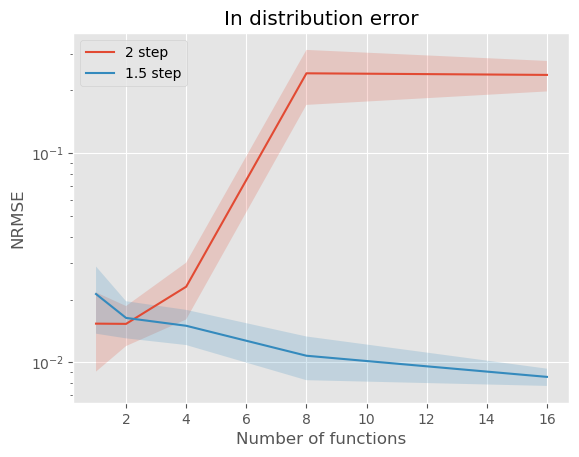

In [21]:
ms = [2**i for i in range(5)]
plt.title('In distribution error')
plt.plot(ms,mean_in_sample_2_2pts, label = '2 step')
plt.fill_between(ms,mean_in_sample_2_2pts - sd_in_sample_2_2pts,mean_in_sample_2_2pts + sd_in_sample_2_2pts,alpha=.2)
plt.yscale('log')
plt.plot(ms,mean_in_sample_1_5_2pts, label = '1.5 step')
plt.fill_between(ms,mean_in_sample_1_5_2pts - sd_in_sample_1_5_2pts,mean_in_sample_1_5_2pts + sd_in_sample_1_5_2pts,alpha=.2)
plt.yscale('log')
plt.ylabel('NRMSE')
plt.xlabel('Number of functions')
plt.legend()
plt.show()

### Out of sample plot

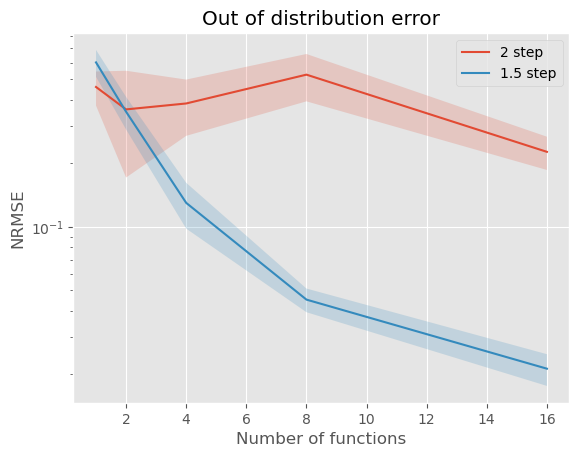

In [90]:
ms = [2**i for i in range(5)]
plt.title('Out of distribution error')
plt.plot(ms,mean_out_sample_2_2pts, label = '2 step')
plt.fill_between(ms,mean_out_sample_2_2pts - sd_out_sample_2_2pts,mean_out_sample_2_2pts + sd_out_sample_2_2pts,alpha=.2)
plt.yscale('log')
plt.plot(ms,mean_out_sample_1_5_2pts, label = '1.5 step')
plt.fill_between(ms,mean_out_sample_1_5_2pts - sd_out_sample_1_5_2pts,mean_out_sample_1_5_2pts + sd_out_sample_1_5_2pts,alpha=.2)
plt.yscale('log')
plt.ylabel('NRMSE')
plt.xlabel('Number of functions')
plt.legend()
plt.show()